In [1]:
from typing import Dict, List, Tuple, Optional, Union
import silence_tensorflow.auto
import time
from utils.models_tuner import *
from utils.data_processing import to_bed

In [ ]:
from ucsc_genomes_downloader import Genome

genome = Genome("hg38", cache_directory=GENOME_CACHE_DIR)

In [3]:
from sklearn.model_selection import StratifiedShuffleSplit, ShuffleSplit

holdouts_generator = StratifiedShuffleSplit(
    n_splits=HOLDOUTS_NUM_SPLIT,
    test_size=TEST_SIZE
)

In [ ]:
from tqdm.auto import tqdm
from epigenomic_dataset import active_enhancers_vs_inactive_enhancers, active_promoters_vs_inactive_promoters
from epigenomic_dataset.utils import normalize_epigenomic_data
from utils.bio_constants import *
import warnings
warnings.filterwarnings('ignore')

all_tuner_results = []
all_input_layer = []
all_output_layer = []

for task, threshold in tqdm((
    (active_enhancers_vs_inactive_enhancers, 0),
    (active_promoters_vs_inactive_promoters, 1)
), desc="Tasks"):
    all_results = []
    task_name = task.__name__

    # We get the task data with binarized labels
    X, y = task(
        binarize=True,
        cell_line=CELL_LINE,
        window_size=WINDOW_SIZE,
        min_active_tpm_value=threshold,
        max_inactive_tpm_value=threshold,
        root="bio_data/epigenomic/"+str(task_name),
        verbose=1
    )
    bed = to_bed(X)

    # Start the main loop, iterating through the holdouts
    for holdout_number, (train_indices, test_indices) in tqdm(
        enumerate(holdouts_generator.split(X, y)),
        total=HOLDOUTS_NUM_SPLIT,
        leave=False,
        desc="Computing Holdouts For {}".format(task_name)
    ):
        # Get the training and test data
        train_bed, test_bed = bed.iloc[train_indices], bed.iloc[test_indices]
        train_X, test_X = X.iloc[train_indices], X.iloc[test_indices]
        train_y, test_y = y.iloc[train_indices], y.iloc[test_indices]

        # Impute and normalize the epigenomic data
        train_X, test_X = normalize_epigenomic_data(train_X, test_X)

        # Flatten the output values
        train_y = train_y.values.flatten()
        test_y = test_y.values.flatten()

        input_layers = {}
        output_layers = {}
        for model in MODELS_TYPE:
            if model == MODEL_TYPE_MMNN:
                check_ffn_param = any("ffnn_parameters" in d for d in all_tuner_results[:2])
                check_cnn_param = any("cnn_parameters" in d for d in all_tuner_results[:2])
                if check_ffn_param and check_cnn_param:
                    input_layers["input_epigenomic_data"] = all_tuner_results[0].get("ffnn_parameters").get("input_epigenomic_data")
                    input_layers["input_sequence_data"] = all_tuner_results[1].get("cnn_parameters").get("input_sequence_data")
                    output_layers["last_hidden_ffnn"] = all_tuner_results[0].get("ffnn_parameters").get("last_hidden_ffnn")
                    output_layers["last_hidden_cnn"] = all_tuner_results[1].get("cnn_parameters").get("last_hidden_cnn")
                    print(f"check_ffn_param: {check_ffn_param} check_cnn_param: {check_cnn_param} input_layers: {input_layers} output_layers: {output_layers} ")
            tuner_result = hyperparameter_tuning(train_X,
                                                test_X,
                                                train_y,
                                                test_y,
                                                train_bed,
                                                test_bed,
                                                genome,
                                                WINDOW_SIZE,
                                                holdout_number,
                                                task_name, model,
                                                input_layers,
                                                output_layers)
            all_tuner_results.append(tuner_result)

In [ ]:
all_tuner_results

In [ ]:
from utils.models.build_binary_classification_mmnn import build_binary_classification_mmnn
from utils.models.build_binary_classification_cnn import build_binary_classification_cnn
from utils.models.build_binary_classification_ffnn import build_binary_classification_ffnn
from tqdm.auto import tqdm
from utils.data_processing import *
from utils.evaluations import train_model
from epigenomic_dataset import active_enhancers_vs_inactive_enhancers, active_promoters_vs_inactive_promoters
from epigenomic_dataset.utils import normalize_epigenomic_data
import time
import warnings
warnings.filterwarnings('ignore')

# Create a list to store all the computed performance
all_binary_classification_performance = []

training_histories = {}

# For each task
for task, threshold in tqdm((
    (active_enhancers_vs_inactive_enhancers, 0),
    (active_promoters_vs_inactive_promoters, 1)
), desc="Tasks"):
    start_time = time.time()
    task_name = task.__name__
    # We get the task data with binarized labels
    X, y = task(
        binarize=True,
        cell_line=CELL_LINE,
        window_size=WINDOW_SIZE,
        min_active_tpm_value=threshold,
        max_inactive_tpm_value=threshold,
        root="bio_data/epigenomic/"+str(task_name),
        verbose=1
    )
    training_histories[task_name] = []

    # Start the main loop, iterating through the holdouts
    for holdout_number, (train_indices, test_indices) in tqdm(
        enumerate(holdouts_generator.split(X, y)),
        total=HOLDOUTS_NUM_SPLIT,
        leave=False,
        desc="Computing Holdouts For {}".format(task_name)
    ):

        for use_feature_selection in tqdm((True, False), desc="Running Feature Selection For {}".format(task_name), leave=False):
            # Get the training and test data
            train_bed, test_bed = bed.iloc[train_indices], bed.iloc[test_indices]
            train_X, test_X = X.iloc[train_indices], X.iloc[test_indices]
            train_y, test_y = y.iloc[train_indices], y.iloc[test_indices]

            # Impute and normalize the epigenomic data
            train_X, test_X = normalize_epigenomic_data(train_X, test_X)

            # Flatten the output values
            train_y = train_y.values.flatten()
            test_y = test_y.values.flatten()

            if use_feature_selection:
                kept_features, discarded_features = execute_boruta_feature_selection(
                    X_train=pd.DataFrame(train_X),
                    y_train=train_y,
                    holdout_number=holdout_number,
                    task_name=task_name,
                    max_iter=20
                )

                if len(kept_features) > 0:
                    train_X = train_X[:,kept_features]
                    test_X = test_X[:,kept_features]

            # Get the number of features of this specific dataset
            number_of_features = train_X.shape[1]
            ffnn_parameters = all_tuner_results[0].get("ffnn_parameters")
            cnn_parameters = all_tuner_results[1].get("cnn_parameters")
            mmnn_parameters = all_tuner_results[2].get("mmnn_parameters")

            ffnn, input_epigenomic_data, last_hidden_ffnn = build_binary_classification_ffnn(input_shape=number_of_features, hp_param=ffnn_parameters)
            cnn, input_sequence_data, last_hidden_cnn = build_binary_classification_cnn(window_size=WINDOW_SIZE, hp_param=cnn_parameters)
            mmnn_simple = build_binary_classification_mmnn(hp_param_ffnn=ffnn_parameters,
                                                            hp_param_cnn=cnn_parameters,
                                                            hp_param_mmnn=mmnn_parameters,
                                                            input_shape=number_of_features,
                                                            window_size=WINDOW_SIZE
            )
            
            mmnn_boosted = build_binary_classification_mmnn(
                hp_param_mmnn=mmnn_parameters,
                input_sequence_data=input_sequence_data,
                input_epigenomic_data=input_epigenomic_data,
                last_hidden_ffnn=last_hidden_ffnn,
                last_hidden_cnn=last_hidden_cnn
            )
            
            for model, train_sequence, test_sequence in tqdm(
                (
                    (ffnn, get_ffnn_sequence(train_X, train_y), get_ffnn_sequence(test_X, test_y)),
                    (cnn, get_cnn_sequence(genome, train_bed, train_y), get_cnn_sequence(genome, test_bed, test_y)),
                    (mmnn_simple, get_mmnn_sequence(genome, train_bed, train_X, train_y), get_mmnn_sequence(genome, test_bed, test_X, test_y)),
                    (mmnn_boosted, get_mmnn_sequence(genome, train_bed, train_X, train_y), get_mmnn_sequence(genome, test_bed, test_X, test_y)),
                ),
                desc="Training models",
                leave=False
            ):

                # We compute the model performance
                history, performance = train_model(
                    model,
                    model.name+"V1",
                    task_name,
                    CELL_LINE,
                    train_sequence,
                    test_sequence,
                    holdout_number,
                    use_feature_selection,
                    start_time
                )
                training_histories[task_name].append(history)
                # We chain the computed performance to the performance list
                all_binary_classification_performance.append(performance)

                start_time = time.time()

# We convert the computed performance list into a DataFrame
all_binary_classification_performance = pd.concat(all_binary_classification_performance)

In [8]:
all_binary_classification_performance.to_csv(f"all_binary_classification_performance.csv", index=False)

In [9]:
all_binary_classification_performance

loss  accuracy    recall  precision     AUROC     AUPRC  f1_score  \
0   0.148190  0.956091  0.187243   0.647226  0.811951  0.358458  0.290456   
1   0.148476  0.956072  0.197368   0.638298  0.808314  0.361206  0.301508   
0   0.193074  0.952003  0.000000   0.000000  0.505954  0.048193  0.000000   
1   0.193035  0.951963  0.000000   0.000000  0.511552  0.048369  0.000000   
0   0.152179  0.955361  0.123045   0.698598  0.808821  0.357955  0.209237   
..       ...       ...       ...        ...       ...       ...       ...   
1   0.555913  0.758672  0.539124   0.527868  0.779245  0.517455  0.533437   
0   0.397336  0.813451  0.581503   0.651900  0.864227  0.659626  0.614693   
1   0.403303  0.808029  0.571009   0.639991  0.857548  0.641662  0.603536   
0   0.404070  0.801337  0.776398   0.584134  0.873934  0.683917  0.666681   
1   0.423366  0.789758  0.760759   0.566414  0.860321  0.649436  0.649357   

    balanced_accuracy  specificity  miss_rate  ...  markedness     LR_pos  \
0            0.591049     0.994855   0.812757  ...    0.607667  36.389324   
1            0.595862     0.994356   0.802632  ...    0.599161  34.971321   
0            0.500000     1.000000   1.000000  ...   -0.047997   0.000000   
1            0.500000     1.000000   1.000000  ...   -0.048037   0.000000   
0            0.560184     0.997324   0.876955  ...    0.656148  45.971432   
..                ...          ...        ...  ...         ...        ...   
1            0.686649     0.834174   0.460876  ...    0.368204   3.251143   
0            0.737360     0.893217   0.418497  ...    0.513134   5.445647   
1            0.730274     0.889539   0.428991  ...    0.497736   5.169335   
0            0.793155     0.809913   0.223602  ...    0.497423   4.084431   
1            0.780245     0.799731   0.239241  ...    0.473134   3.798682   

      LR_neg       DOR  run_type                  model_name  \
0   0.816961  1.445279     train  BinaryClassificationFFNNV1   
1   0.807187  1.474405      test  BinaryClassificationFFNNV1   
0   1.000000  1.000000     train   BinaryClassificationCNNV1   
1   1.000000  1.000000      test   BinaryClassificationCNNV1   
0   0.879308  1.273680     train                      MMNNV1   
..       ...       ...       ...                         ...   
1   0.552494  2.191308      test   BinaryClassificationCNNV1   
0   0.468527  2.807495     train                      MMNNV1   
1   0.482262  2.707470      test                      MMNNV1   
0   0.276082  3.834544     train               BoostedMMNNV1   
1   0.299152  3.550520      test               BoostedMMNNV1   

                                      task  holdout_number  \
0   active_enhancers_vs_inactive_enhancers               0   
1   active_enhancers_vs_inactive_enhancers               0   
0   active_enhancers_vs_inactive_enhancers               0   
1   active_enhancers_vs_inactive_enhancers               0   
0   active_enhancers_vs_inactive_enhancers               0   
..                                     ...             ...   
1   active_promoters_vs_inactive_promoters               9   
0   active_promoters_vs_inactive_promoters               9   
1   active_promoters_vs_inactive_promoters               9   
0   active_promoters_vs_inactive_promoters               9   
1   active_promoters_vs_inactive_promoters               9   

    use_feature_selection  elapsed_time  
0                    True        223.78  
1                    True        223.78  
0                    True        244.98  
1                    True        244.98  
0                    True        289.92  
..                    ...           ...  
1                   False       1742.15  
0                   False        564.20  
1                   False        564.20  
0                   False        889.48  
1                   False        889.48  

[320 rows x 33 columns]

In [10]:
all_binary_classification_performance[all_binary_classification_performance['run_type'] == 'test'].sort_values(by='AUPRC', ascending=False)

loss  accuracy    recall  precision     AUROC     AUPRC  f1_score  \
1   0.389686  0.811433  0.645540   0.627973  0.864838  0.667554  0.636635   
1   0.389268  0.813736  0.641236   0.634656  0.866268  0.667007  0.637929   
1   0.397754  0.809681  0.667840   0.618702  0.864033  0.665621  0.642333   
1   0.387973  0.813435  0.642214   0.633661  0.866085  0.664636  0.637909   
1   0.401631  0.812835  0.504304   0.681470  0.863778  0.661813  0.579651   
..       ...       ...       ...        ...       ...       ...       ...   
1   0.228638  0.951963  0.000000   0.000000  0.496028  0.047674  0.000000   
1   0.199247  0.951963  0.000000   0.000000  0.495419  0.047596  0.000000   
1   0.199948  0.951963  0.000000   0.000000  0.497886  0.047397  0.000000   
1   0.192886  0.951963  0.000000   0.000000  0.494943  0.047300  0.000000   
1   0.194977  0.951963  0.000000   0.000000  0.482650  0.045856  0.000000   

    balanced_accuracy  specificity  miss_rate  ...  markedness    LR_pos  \
1            0.757011     0.868483   0.354460  ...    0.504892  4.908411   
1            0.757147     0.873058   0.358764  ...    0.510838  5.051388   
1            0.763150     0.858459   0.332160  ...    0.501267  4.718365   
1            0.757266     0.872318   0.357786  ...    0.510047  5.029773   
1            0.711620     0.918937   0.495696  ...    0.524992  6.221132   
..                ...          ...        ...  ...         ...       ...   
1            0.500000     1.000000   1.000000  ...   -0.048037  0.000000   
1            0.500000     1.000000   1.000000  ...   -0.048037  0.000000   
1            0.500000     1.000000   1.000000  ...   -0.048037  0.000000   
1            0.500000     1.000000   1.000000  ...   -0.048037  0.000000   
1            0.500000     1.000000   1.000000  ...   -0.048037  0.000000   

      LR_neg       DOR  run_type                  model_name  \
1   0.408137  3.115420      test               BoostedMMNNV1   
1   0.410928  3.117715      test               BoostedMMNNV1   
1   0.386925  3.222079      test               BoostedMMNNV1   
1   0.410155  3.119735      test               BoostedMMNNV1   
1   0.539424  2.467651      test  BinaryClassificationFFNNV1   
..       ...       ...       ...                         ...   
1   1.000000  1.000000      test   BinaryClassificationCNNV1   
1   1.000000  1.000000      test   BinaryClassificationCNNV1   
1   1.000000  1.000000      test   BinaryClassificationCNNV1   
1   1.000000  1.000000      test   BinaryClassificationCNNV1   
1   1.000000  1.000000      test   BinaryClassificationCNNV1   

                                      task  holdout_number  \
1   active_promoters_vs_inactive_promoters               0   
1   active_promoters_vs_inactive_promoters               3   
1   active_promoters_vs_inactive_promoters               0   
1   active_promoters_vs_inactive_promoters               3   
1   active_promoters_vs_inactive_promoters               3   
..                                     ...             ...   
1   active_enhancers_vs_inactive_enhancers               2   
1   active_enhancers_vs_inactive_enhancers               9   
1   active_enhancers_vs_inactive_enhancers               9   
1   active_enhancers_vs_inactive_enhancers               6   
1   active_enhancers_vs_inactive_enhancers               8   

    use_feature_selection  elapsed_time  
1                    True        741.58  
1                   False        786.45  
1                   False        535.91  
1                    True        520.51  
1                   False        141.41  
..                    ...           ...  
1                    True        277.76  
1                   False        399.21  
1                    True        337.09  
1                    True        394.75  
1                   False        369.69  

[160 rows x 33 columns]

(<Figure size 2160x1800 with 30 Axes>,
 array([[<AxesSubplot:title={'center':'Loss'}, xlabel='Epochs', ylabel='Loss'>,
         <AxesSubplot:title={'center':'Accuracy'}, xlabel='Epochs', ylabel='Accuracy'>,
         <AxesSubplot:title={'center':'Recall'}, xlabel='Epochs', ylabel='Recall'>,
         <AxesSubplot:title={'center':'Precision'}, xlabel='Epochs', ylabel='Precision'>,
         <AxesSubplot:title={'center':'AUROC'}, xlabel='Epochs', ylabel='AUROC'>,
         <AxesSubplot:title={'center':'AUPRC'}, xlabel='Epochs', ylabel='AUPRC'>],
        [<AxesSubplot:title={'center':'F1 Score'}, xlabel='Epochs', ylabel='F1 Score'>,
         <AxesSubplot:title={'center':'Balanced Accuracy'}, xlabel='Epochs', ylabel='Balanced Accuracy'>,
         <AxesSubplot:title={'center':'Specificity'}, xlabel='Epochs', ylabel='Specificity'>,
         <AxesSubplot:title={'center':'Miss rate'}, xlabel='Epochs', ylabel='Miss rate'>,
         <AxesSubplot:title={'center':'Fall out'}, xlabel='Epochs', ylabel='

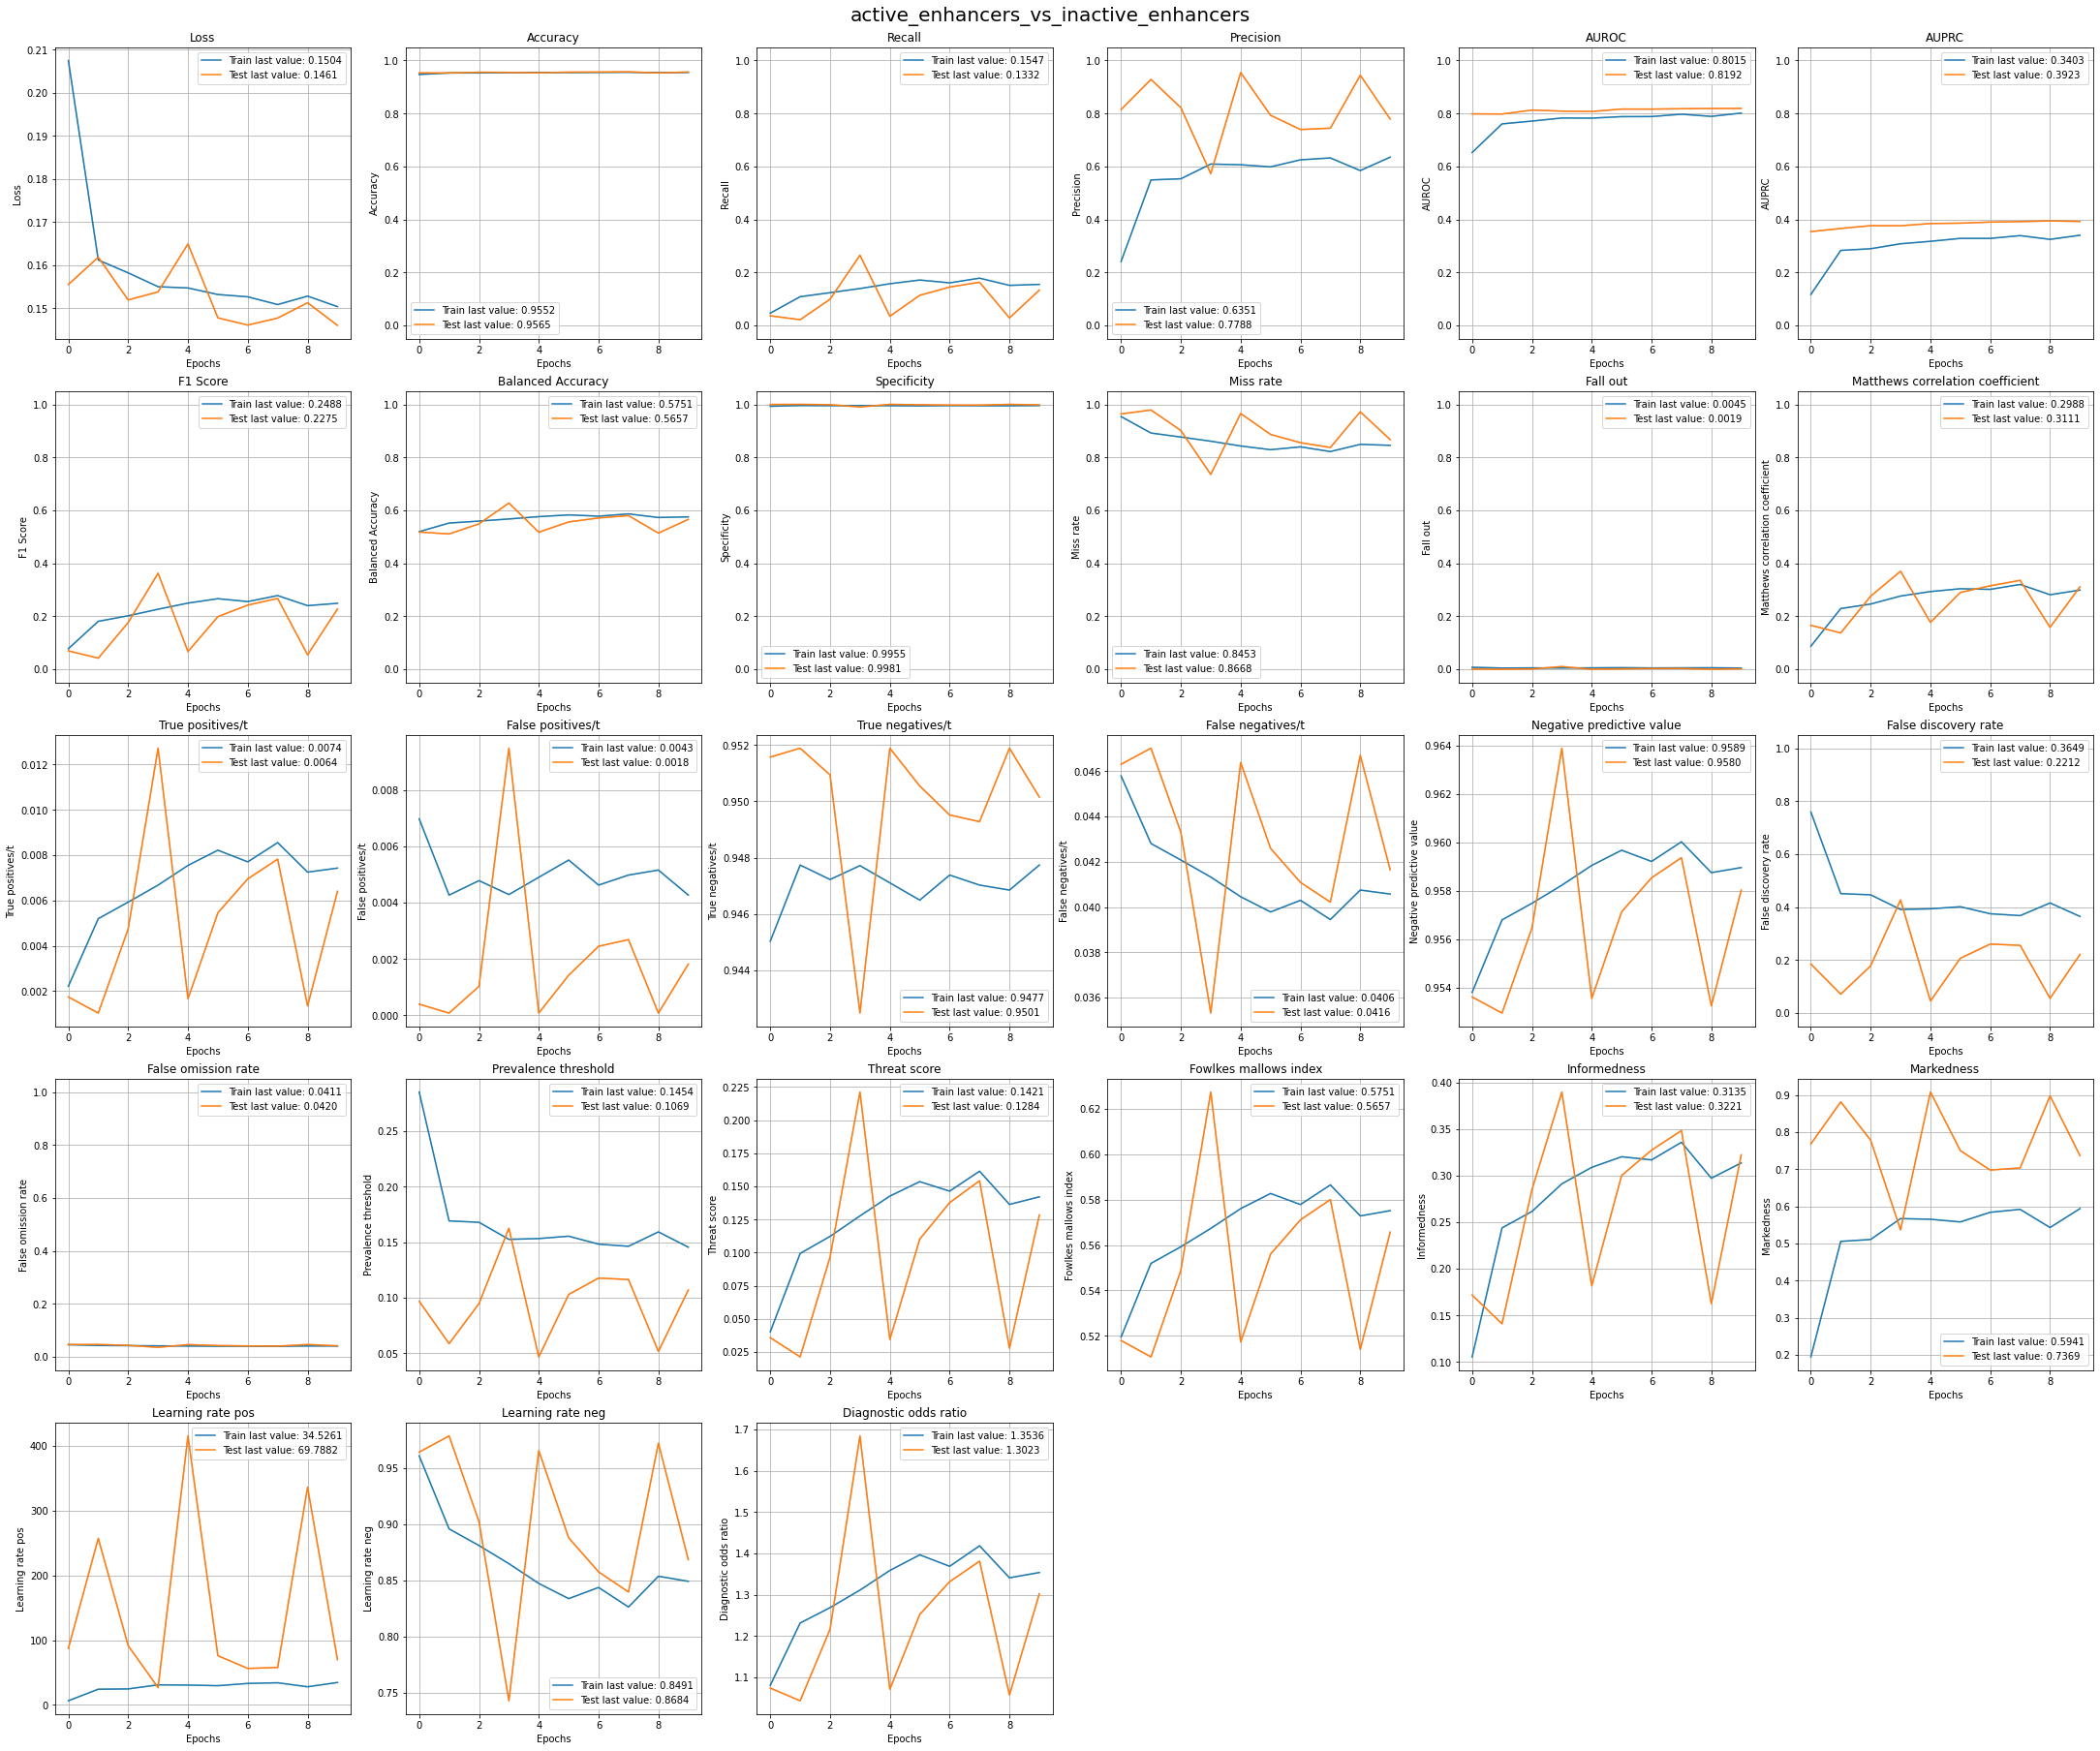

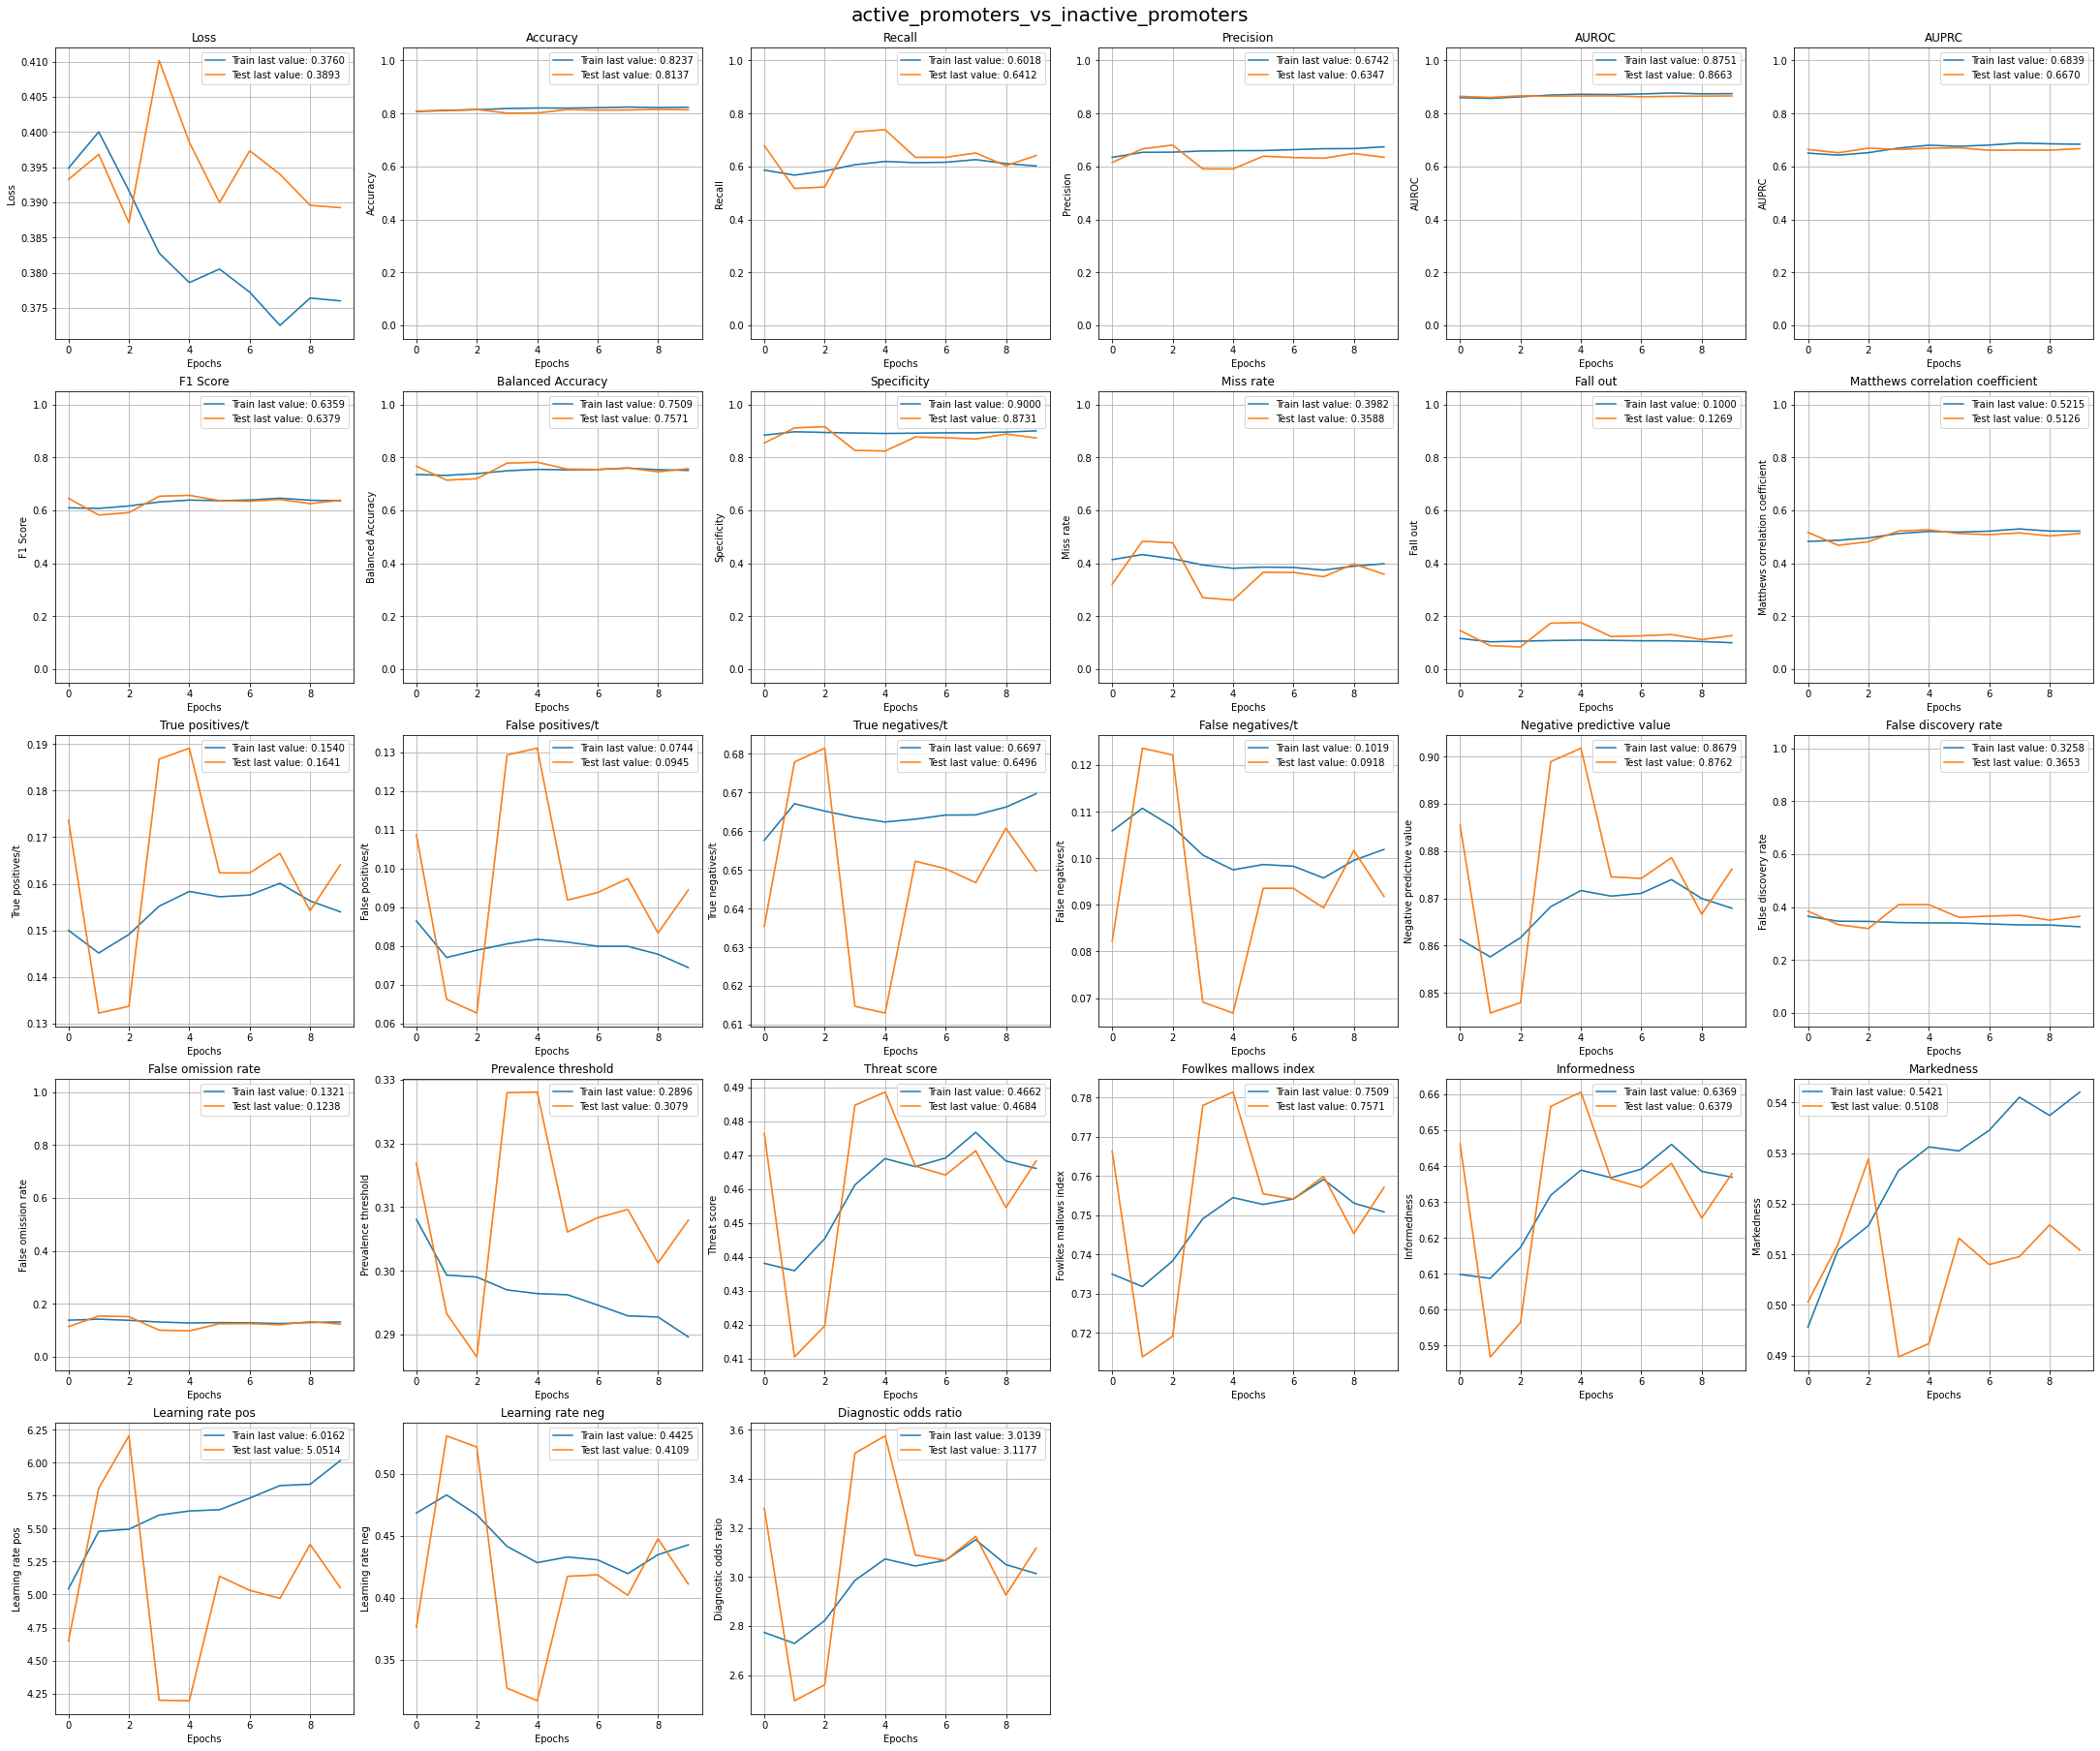

In [141]:
from plot_keras_history import plot_history

plot_history(training_histories["active_enhancers_vs_inactive_enhancers"][14], title="active_enhancers_vs_inactive_enhancers", graphs_per_row=6)
plot_history(training_histories["active_promoters_vs_inactive_promoters"][31], title="active_promoters_vs_inactive_promoters", graphs_per_row=6)

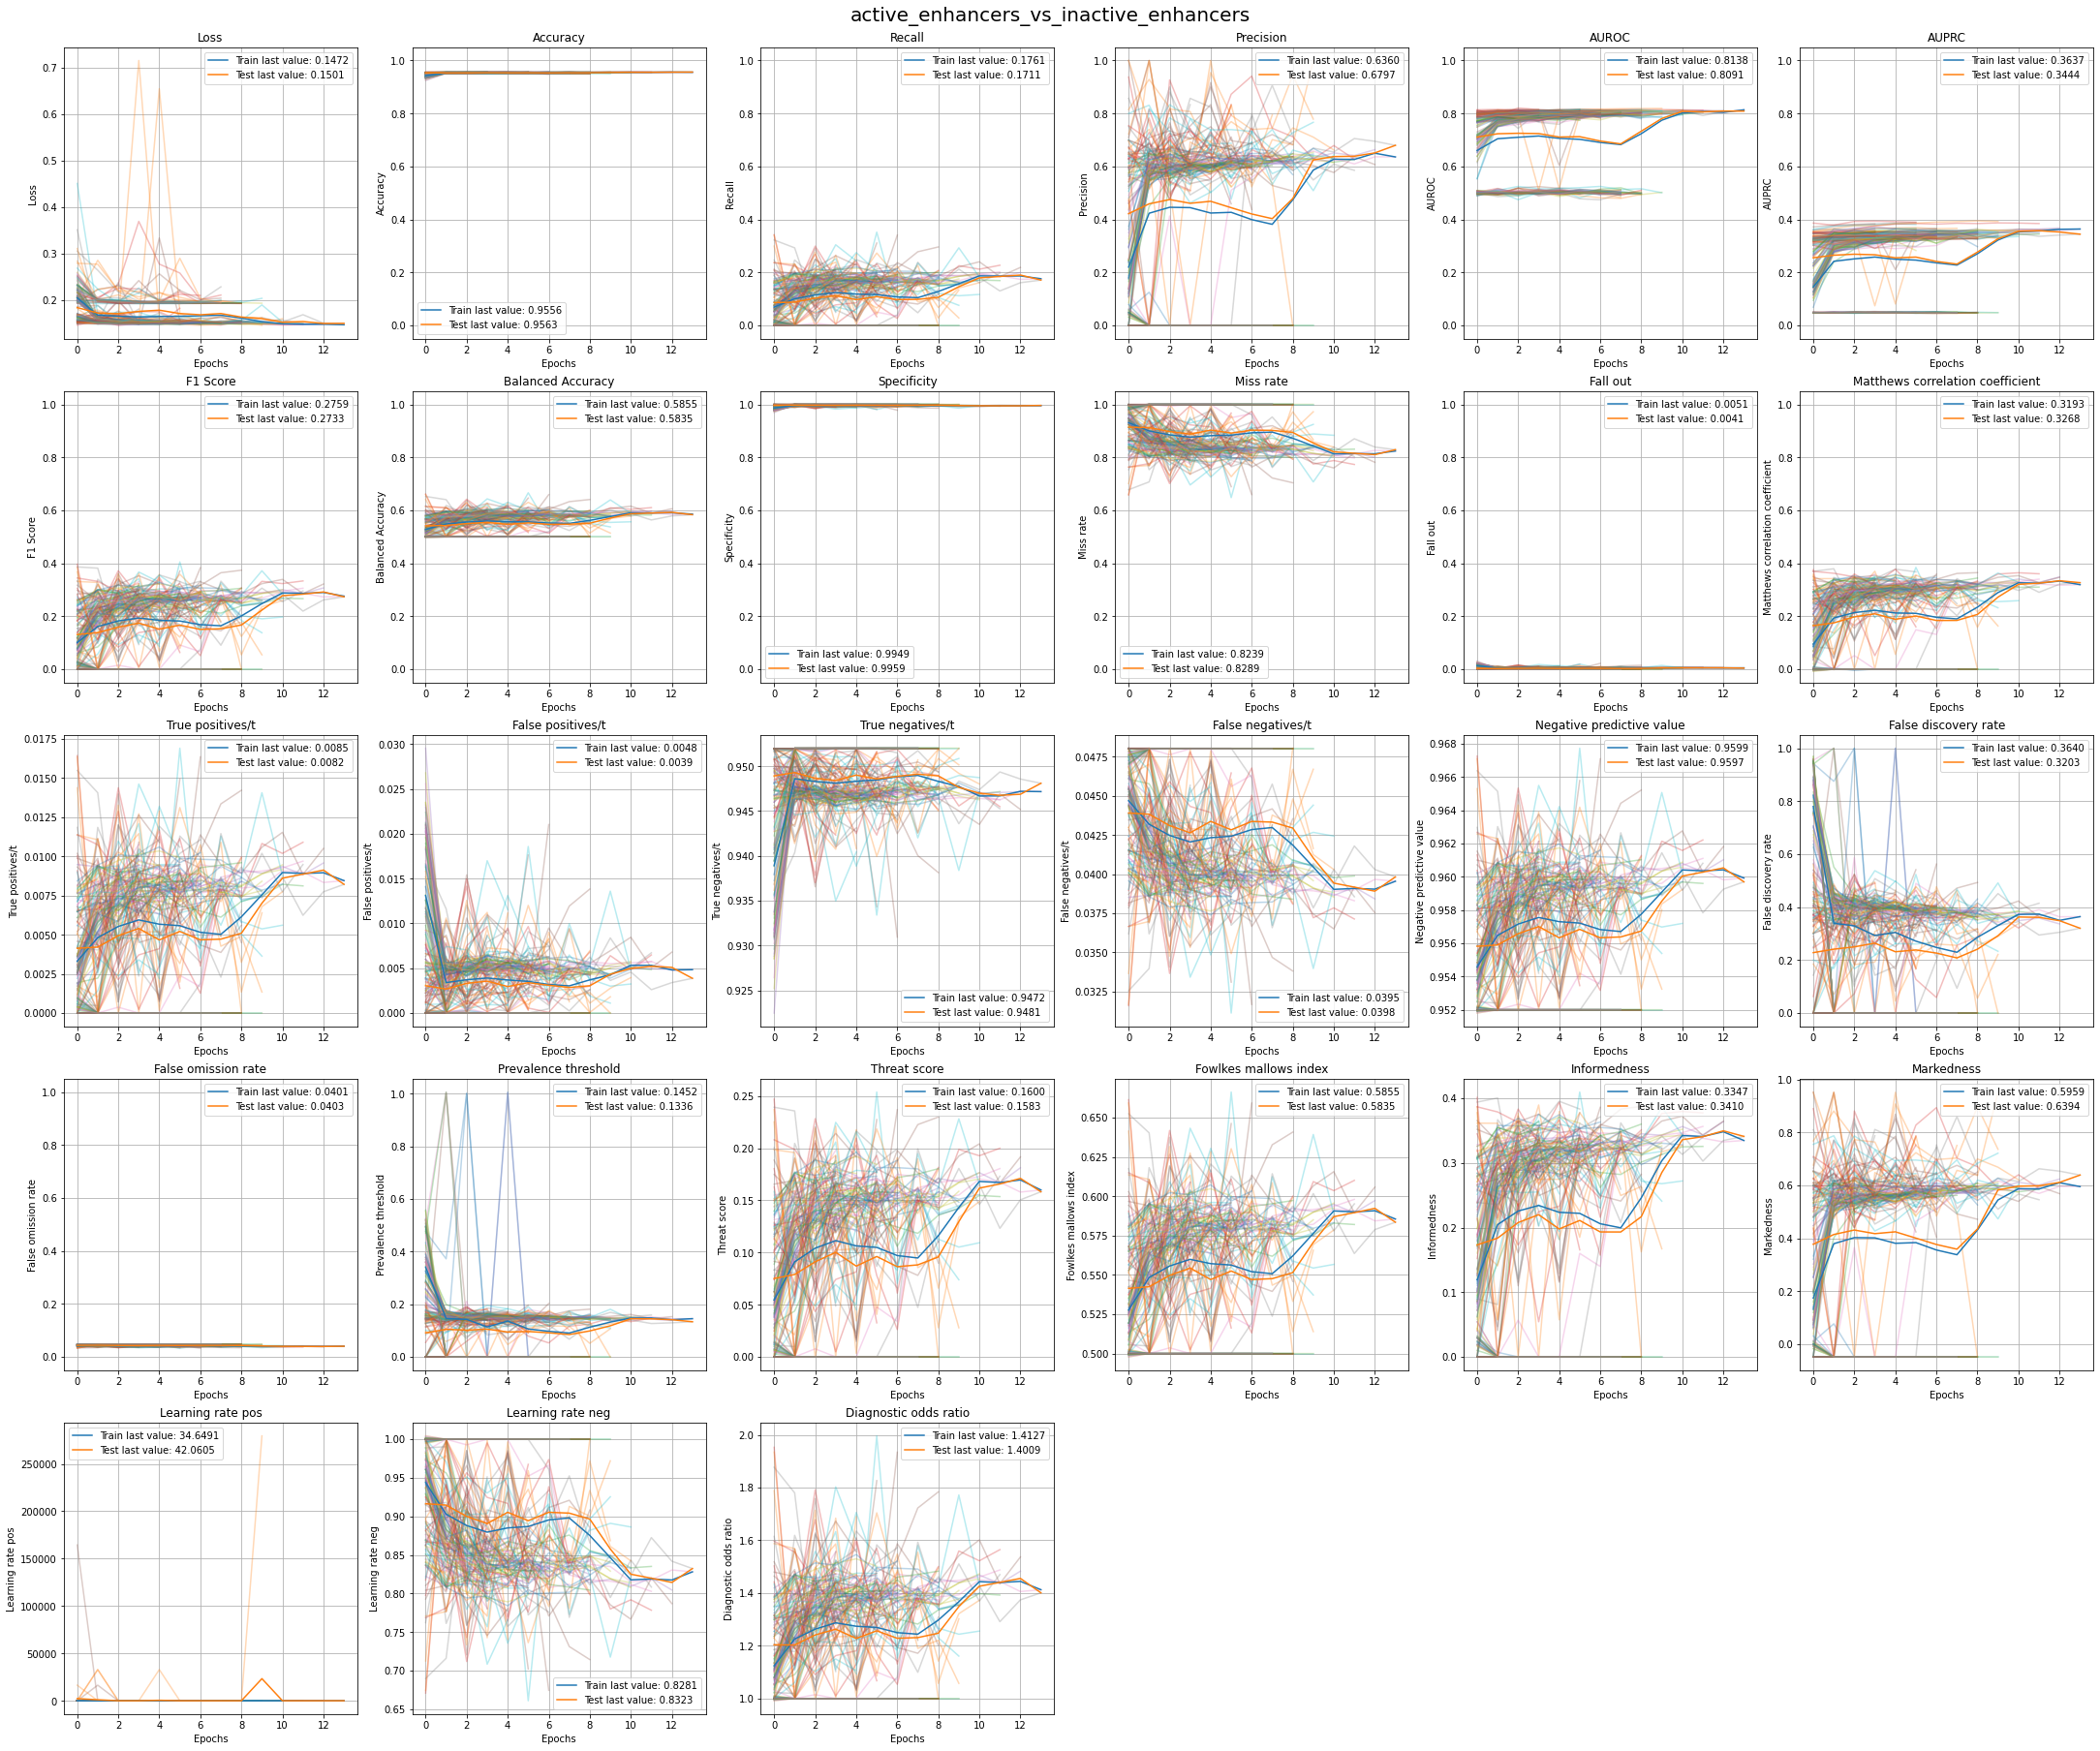

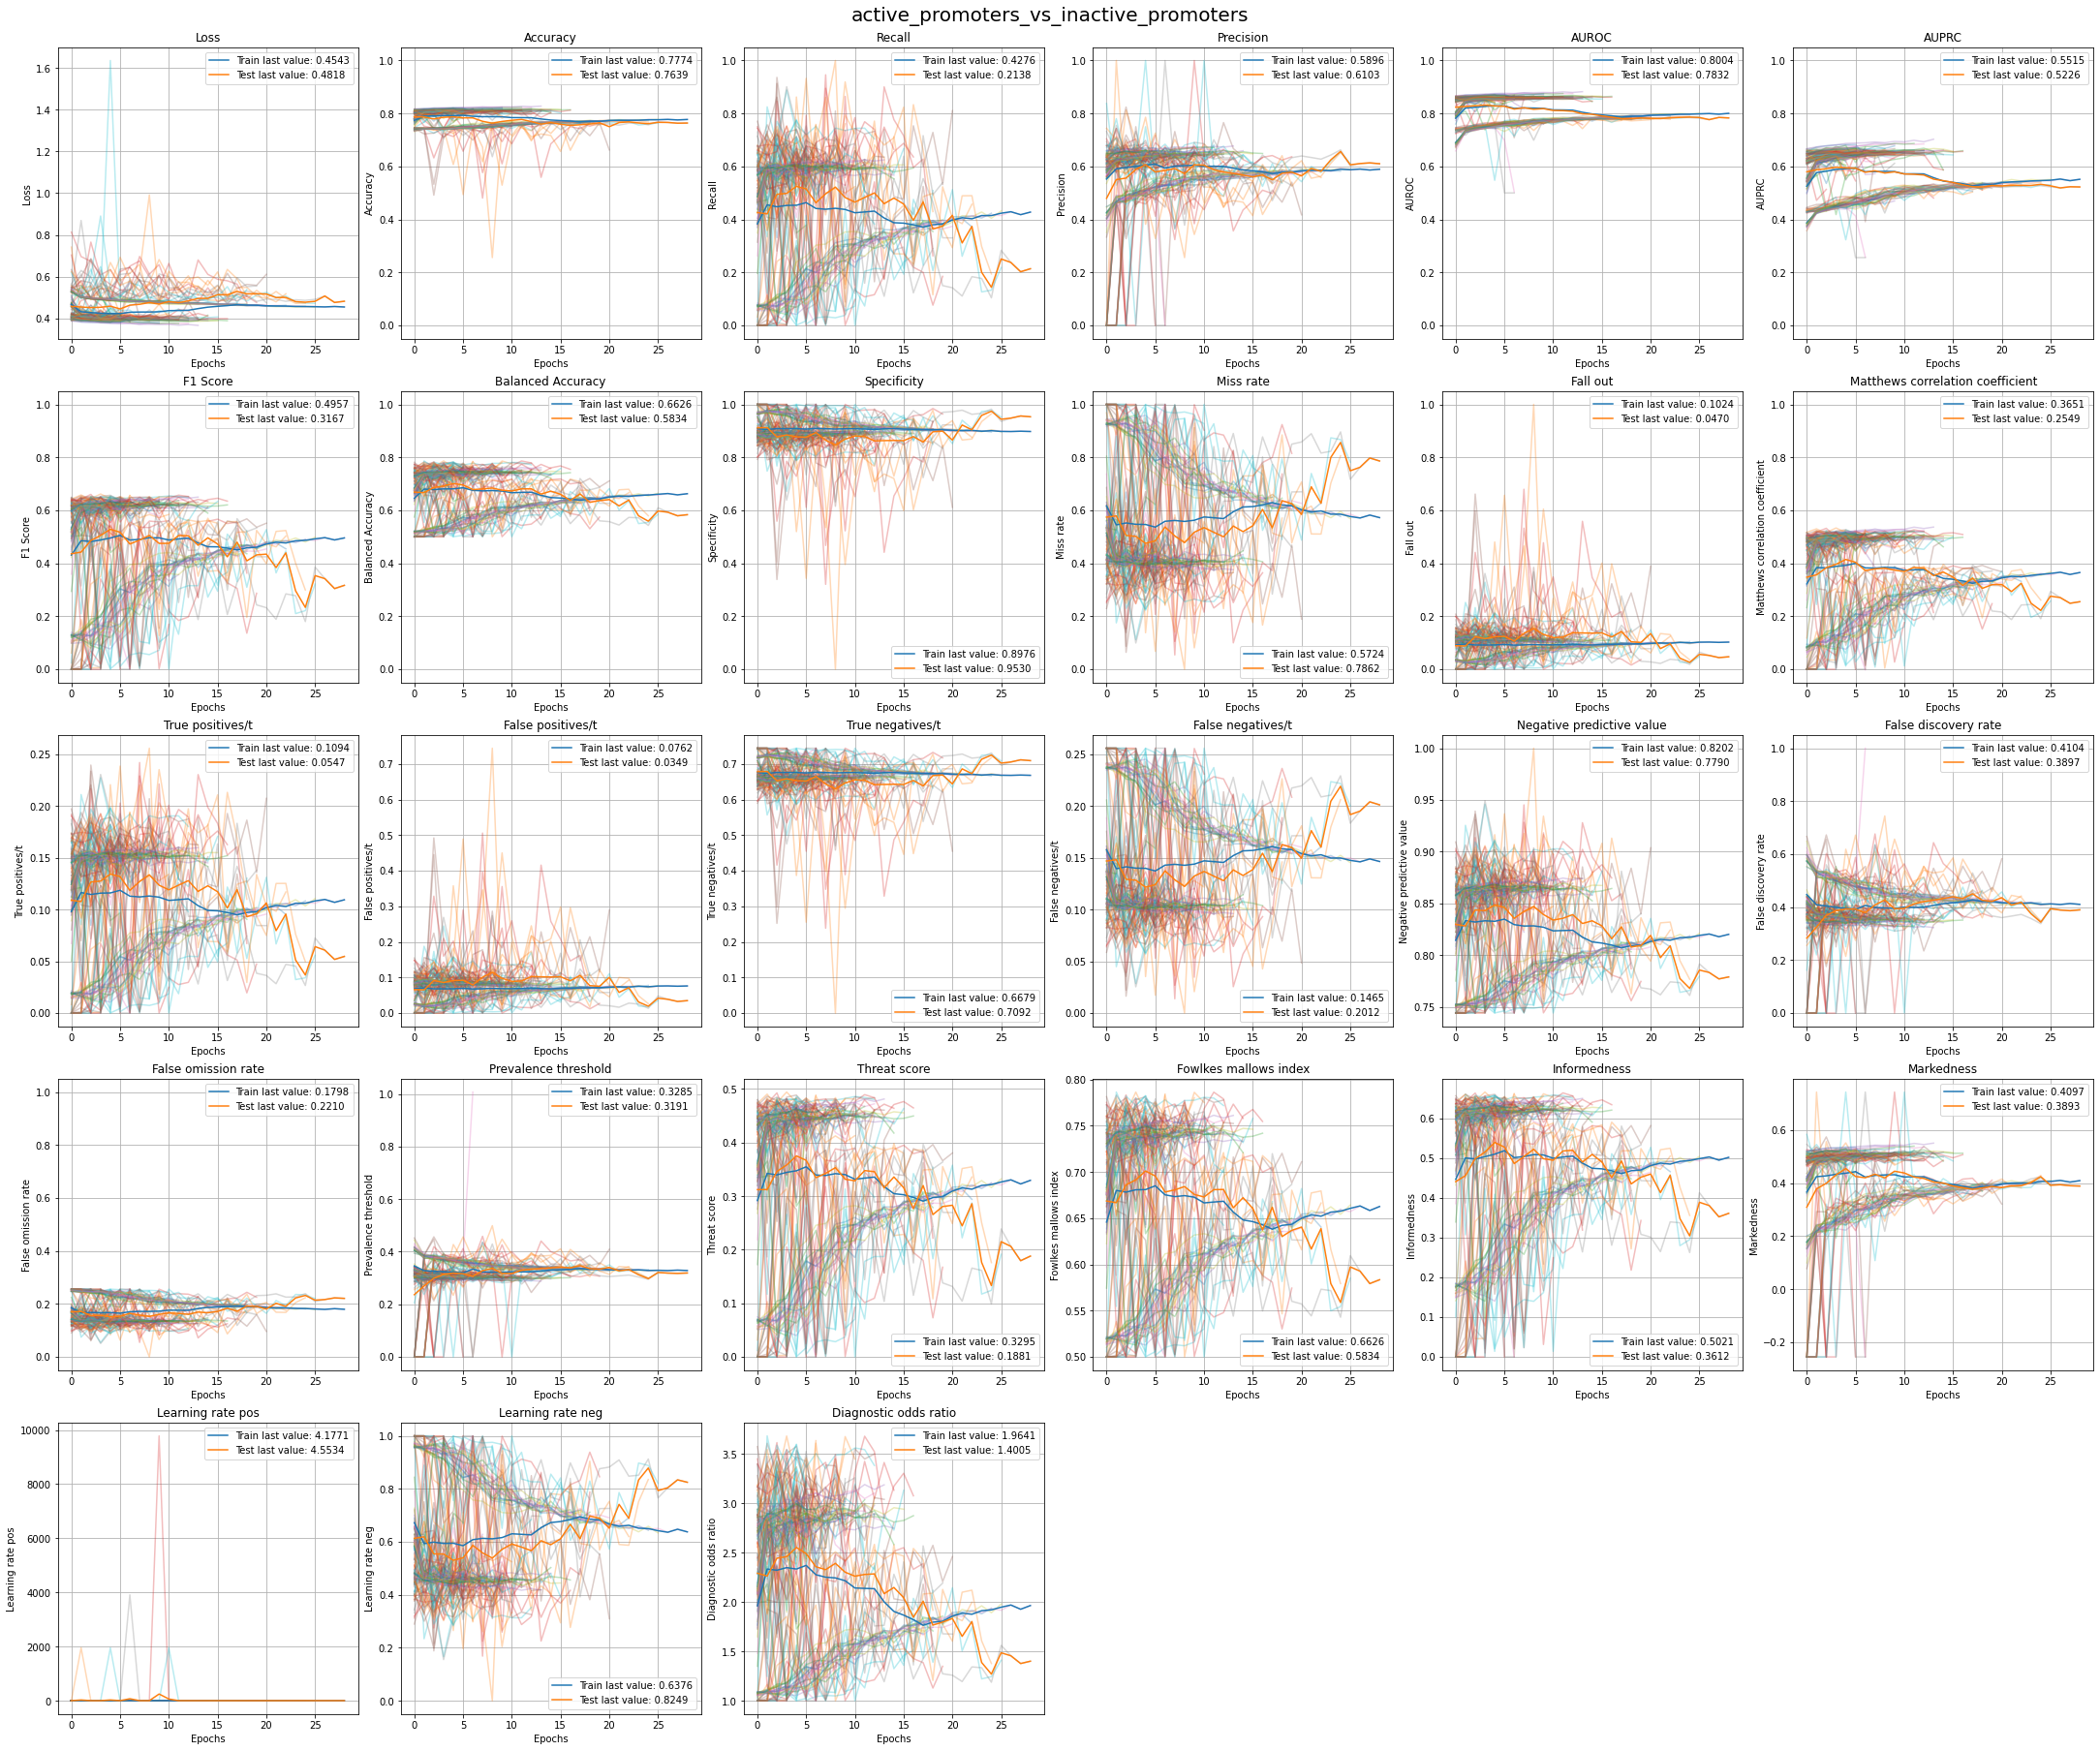

In [11]:
from plot_keras_history import plot_history

for region, x in training_histories.items():
  plot_history(training_histories[region], title=region, graphs_per_row=6)

In [13]:
# Slightly adapting the dataframe in order to visualiza it better
all_binary_classification_performance["use_feature_selection"] = [
    "Feature Selection" if use_selection else "No Feature Selection"
    for use_selection in all_binary_classification_performance["use_feature_selection"]
]
all_performance = all_binary_classification_performance.drop(columns=["holdout_number"])

Rendering barplots: 100%|██████████| 28/28 [00:12<00:00,  2.29it/s]


((<Figure size 1600x1560 with 1 Axes>,
  <Figure size 1600x1560 with 1 Axes>,
  <Figure size 1600x1560 with 1 Axes>,
  <Figure size 1600x1560 with 1 Axes>,
  <Figure size 1600x1560 with 1 Axes>,
  <Figure size 1600x1560 with 1 Axes>,
  <Figure size 1600x1560 with 1 Axes>,
  <Figure size 1600x1560 with 1 Axes>,
  <Figure size 1600x1560 with 1 Axes>,
  <Figure size 1600x1560 with 1 Axes>,
  <Figure size 1600x1560 with 1 Axes>,
  <Figure size 1600x1560 with 1 Axes>,
  <Figure size 1600x1560 with 1 Axes>,
  <Figure size 1600x1560 with 1 Axes>,
  <Figure size 1600x1560 with 1 Axes>,
  <Figure size 1600x1560 with 1 Axes>,
  <Figure size 1600x1560 with 1 Axes>,
  <Figure size 1600x1560 with 1 Axes>,
  <Figure size 1600x1560 with 1 Axes>,
  <Figure size 1600x1560 with 1 Axes>,
  <Figure size 1600x1560 with 1 Axes>,
  <Figure size 1600x1560 with 1 Axes>,
  <Figure size 1600x1560 with 1 Axes>,
  <Figure size 1600x1560 with 1 Axes>,
  <Figure size 1600x1560 with 1 Axes>,
  <Figure size 1600x1560 

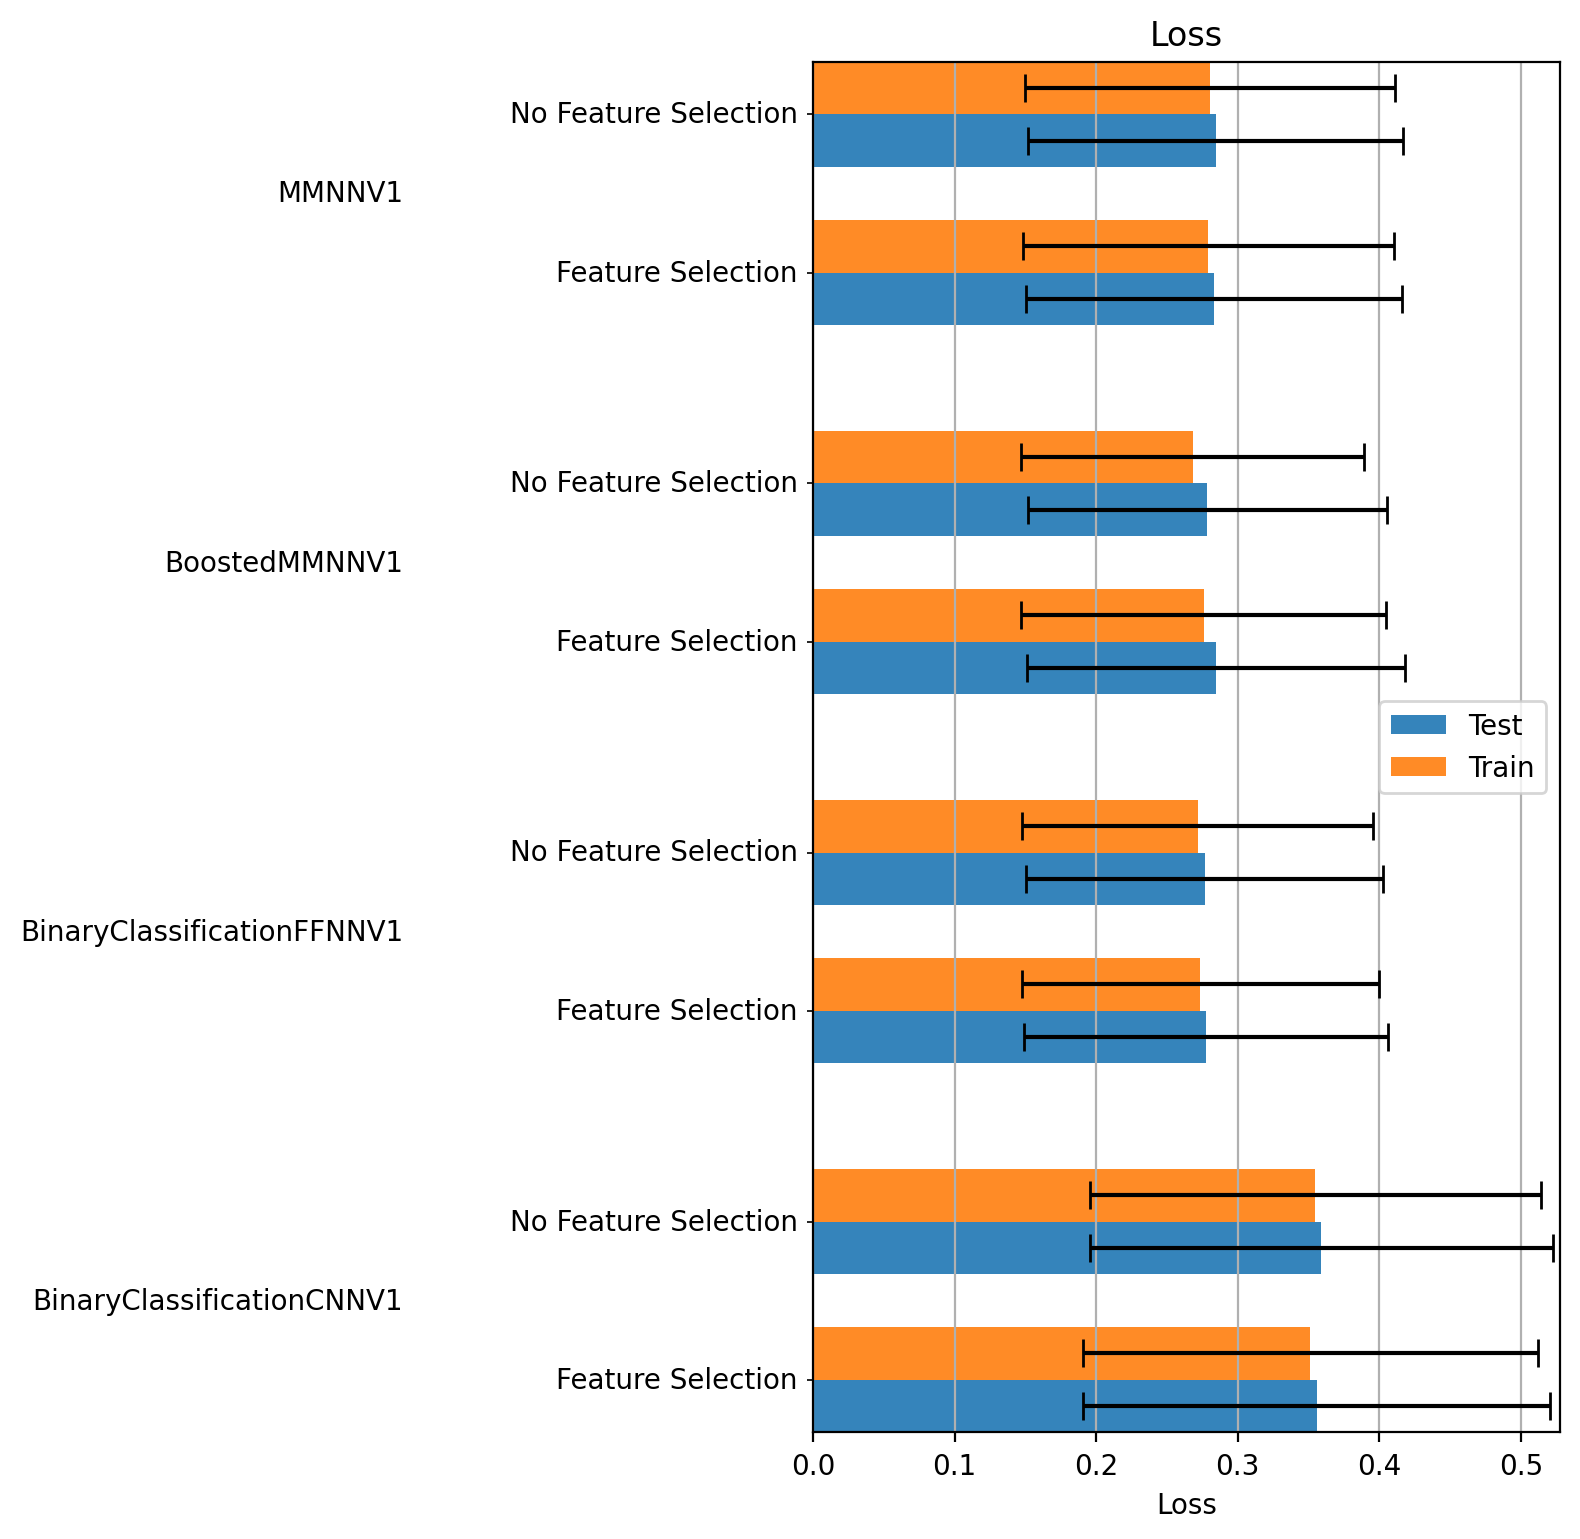

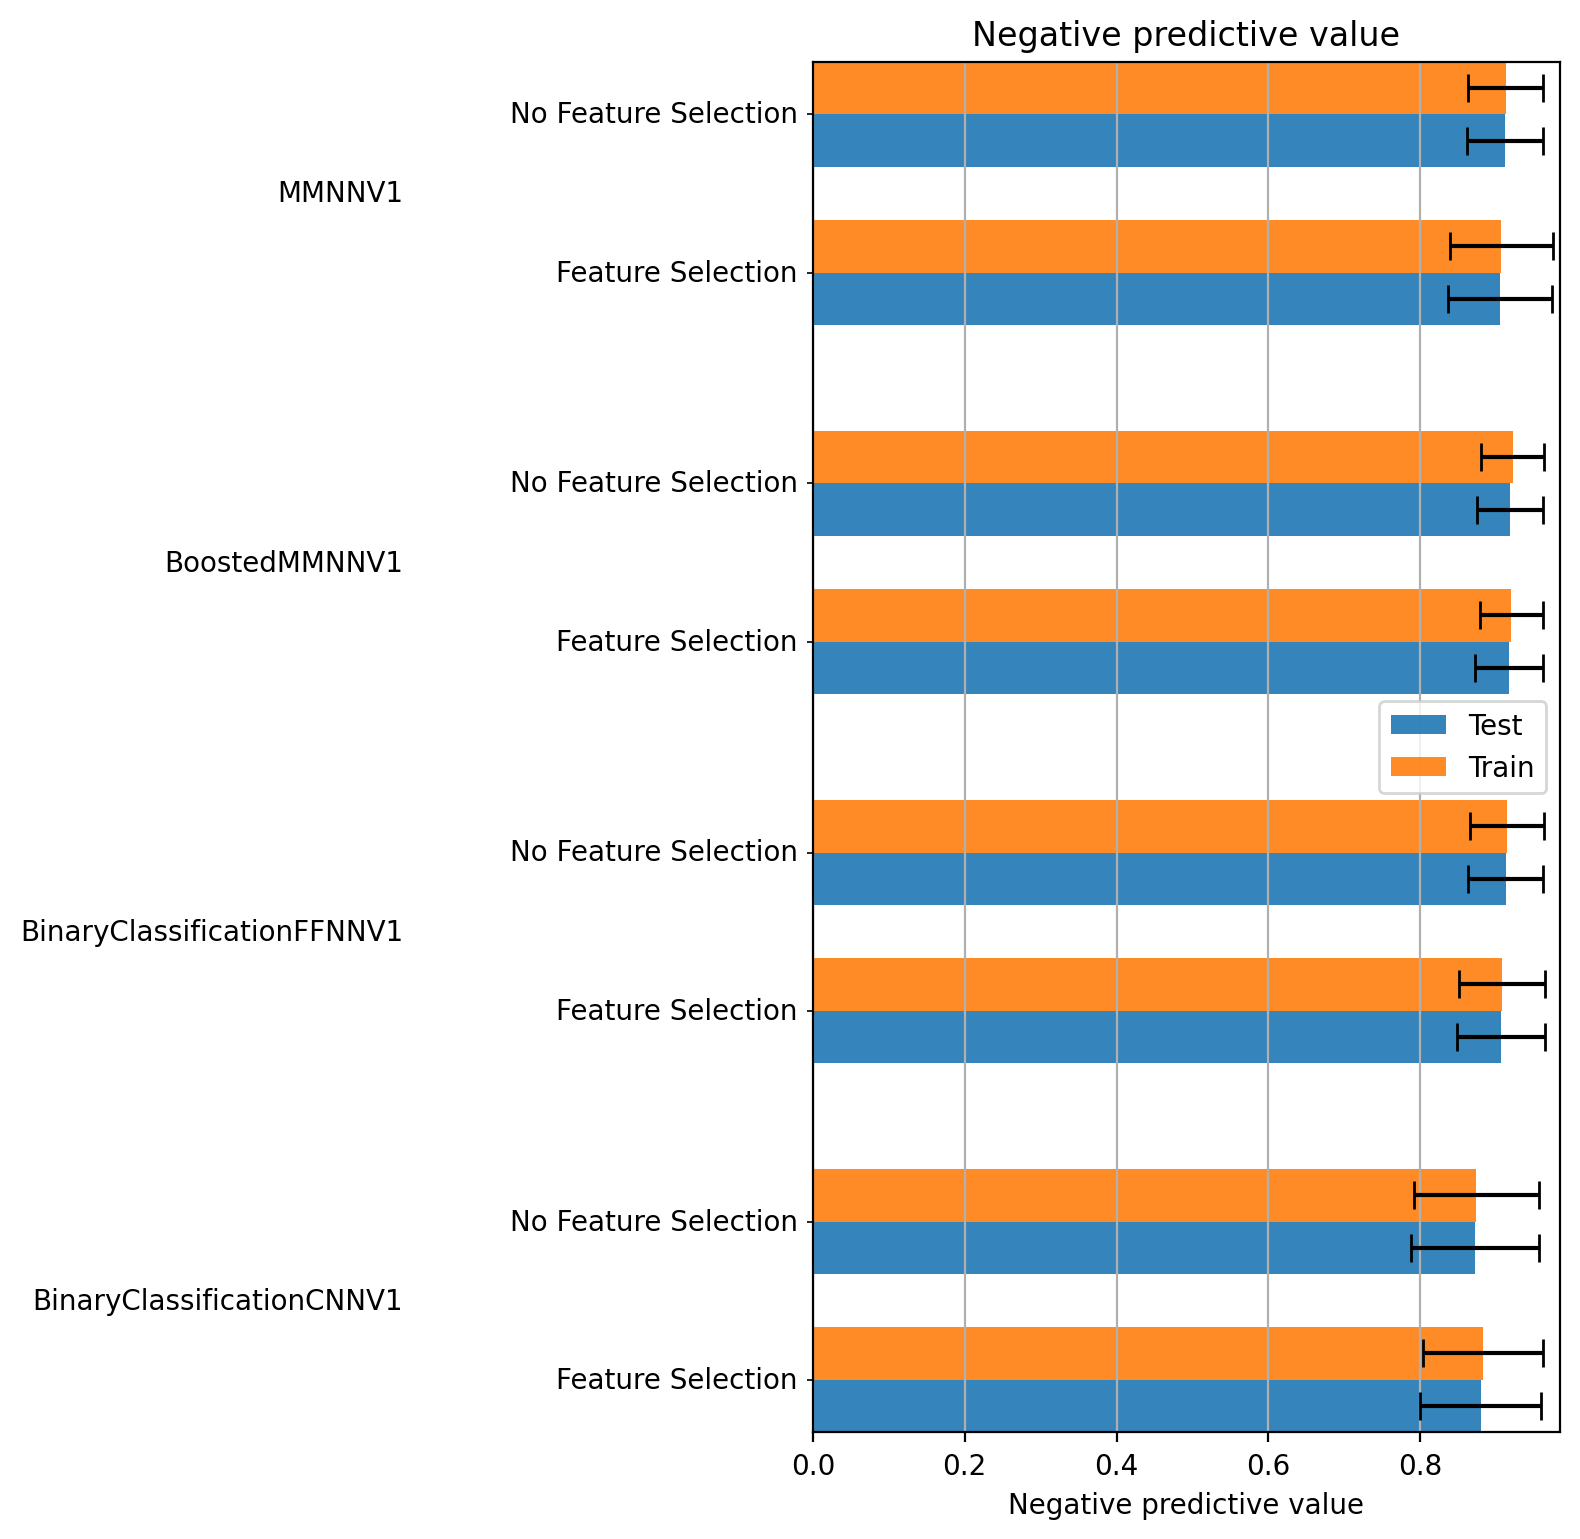

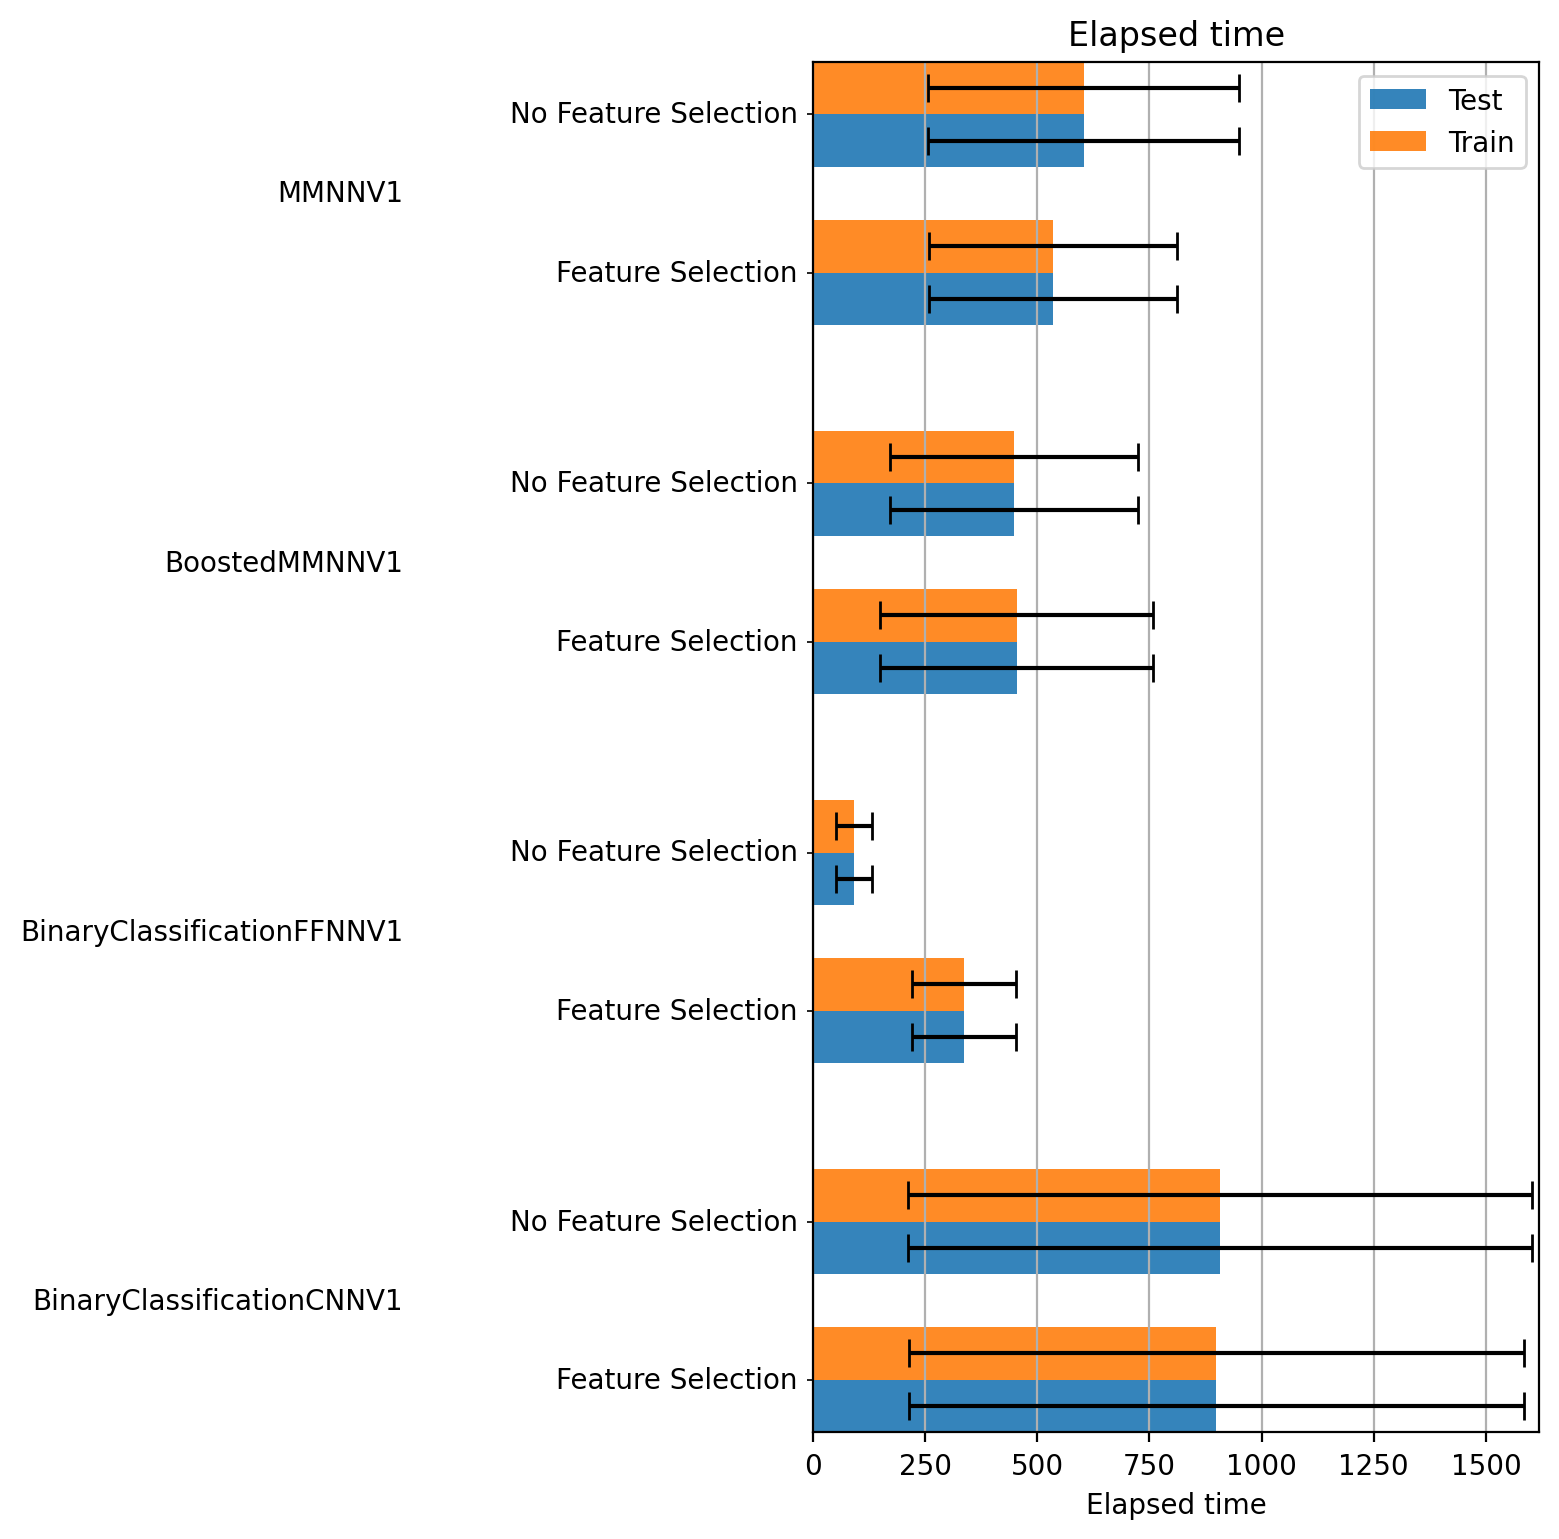

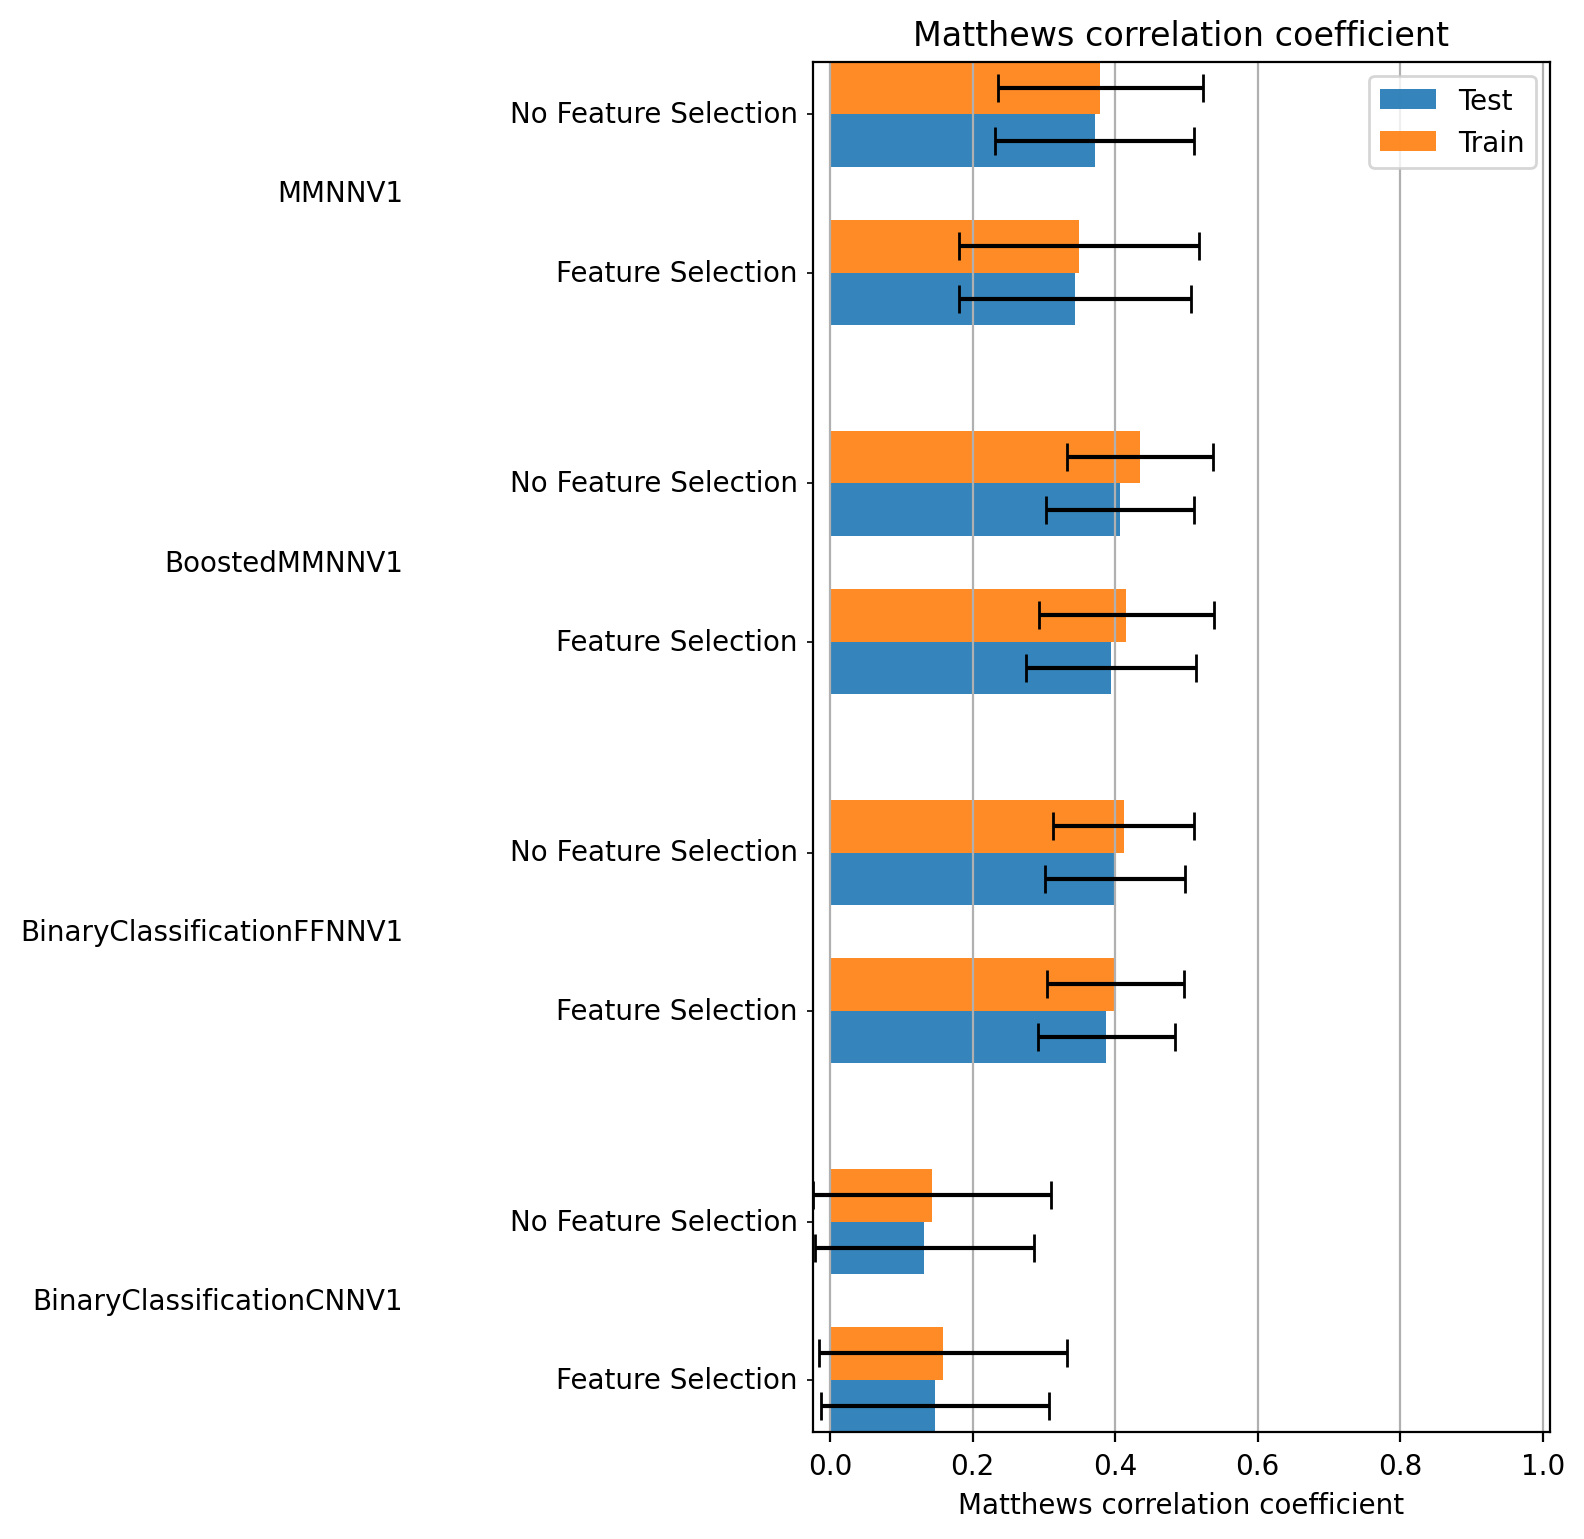

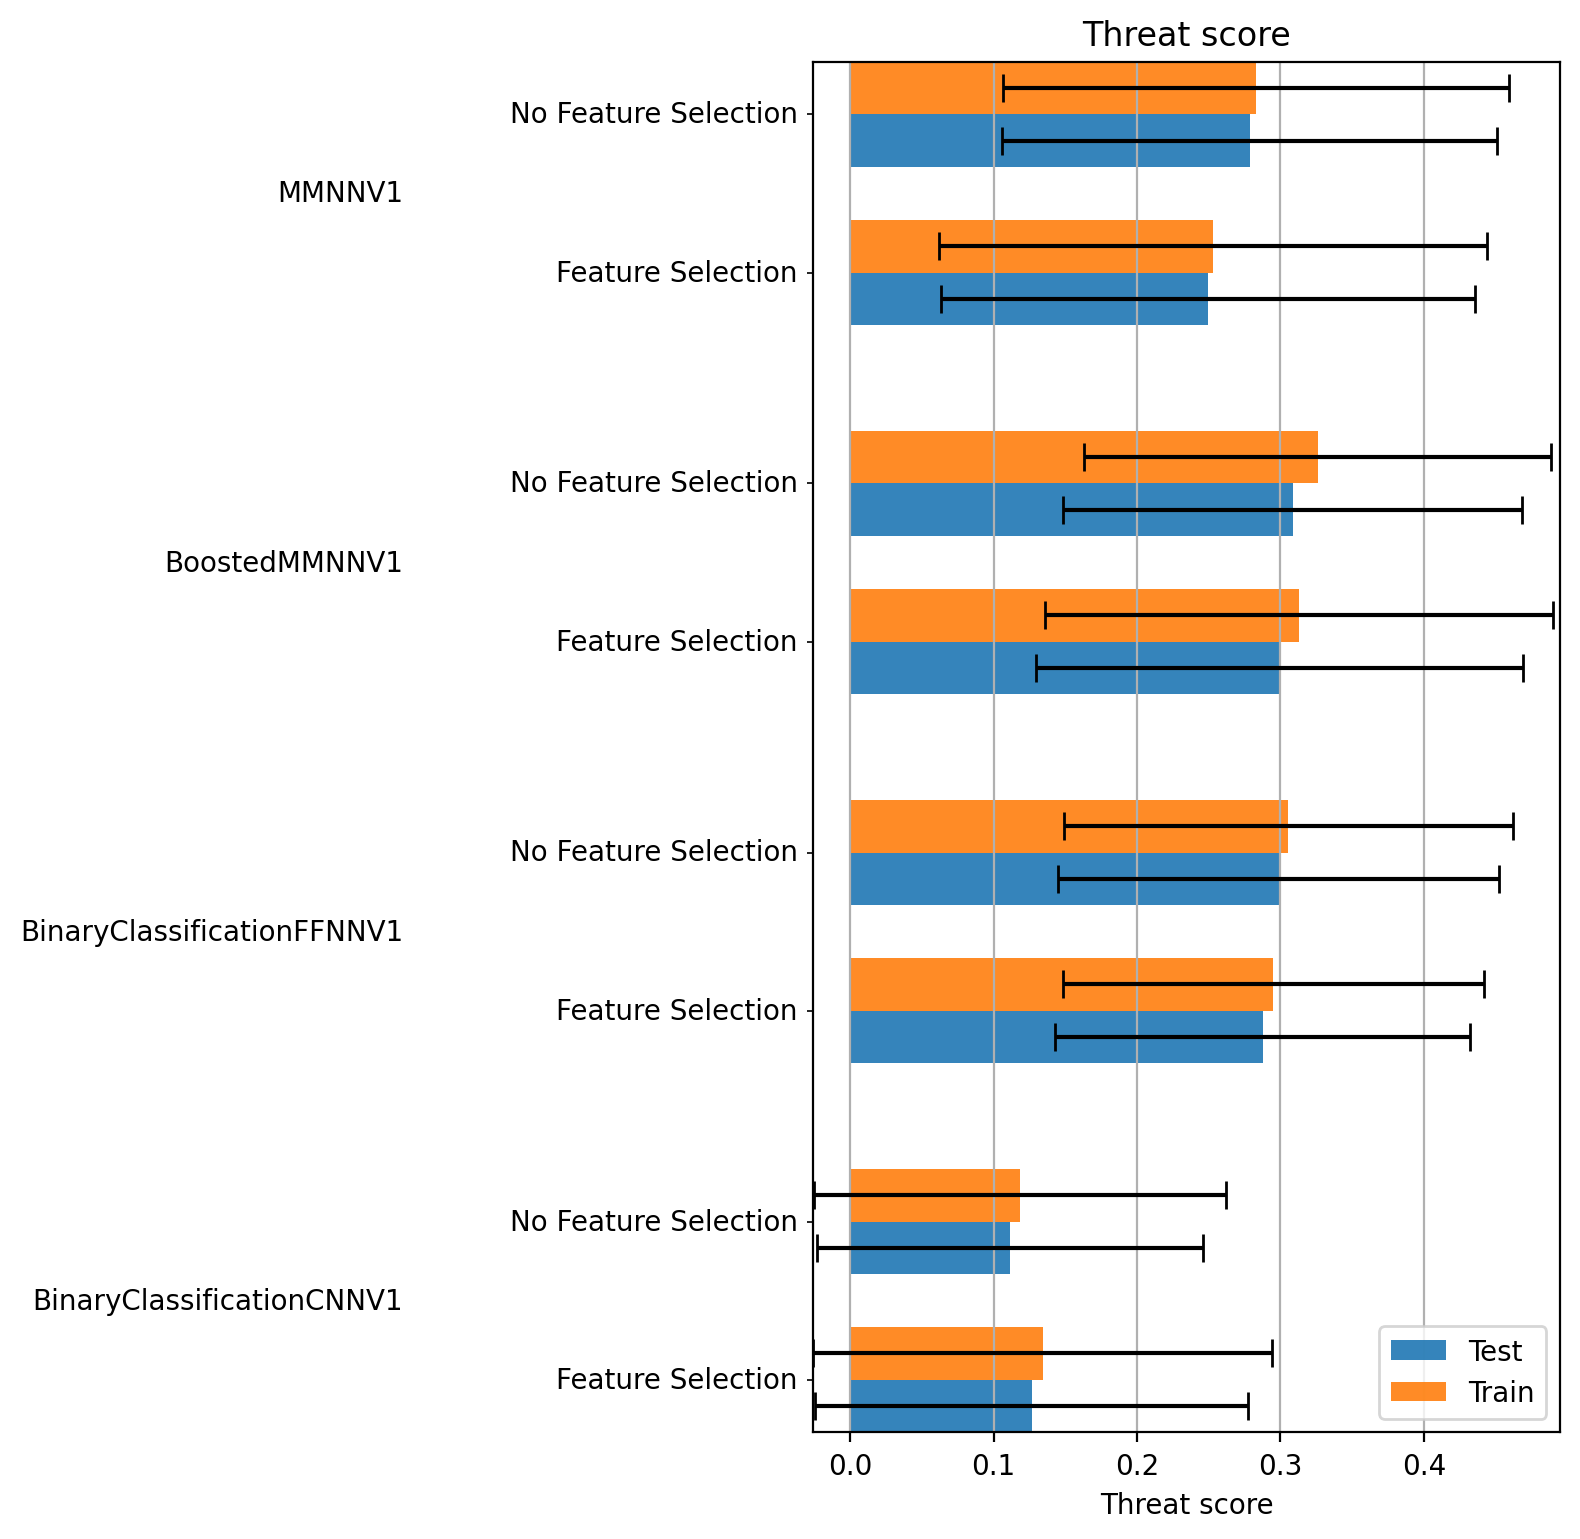

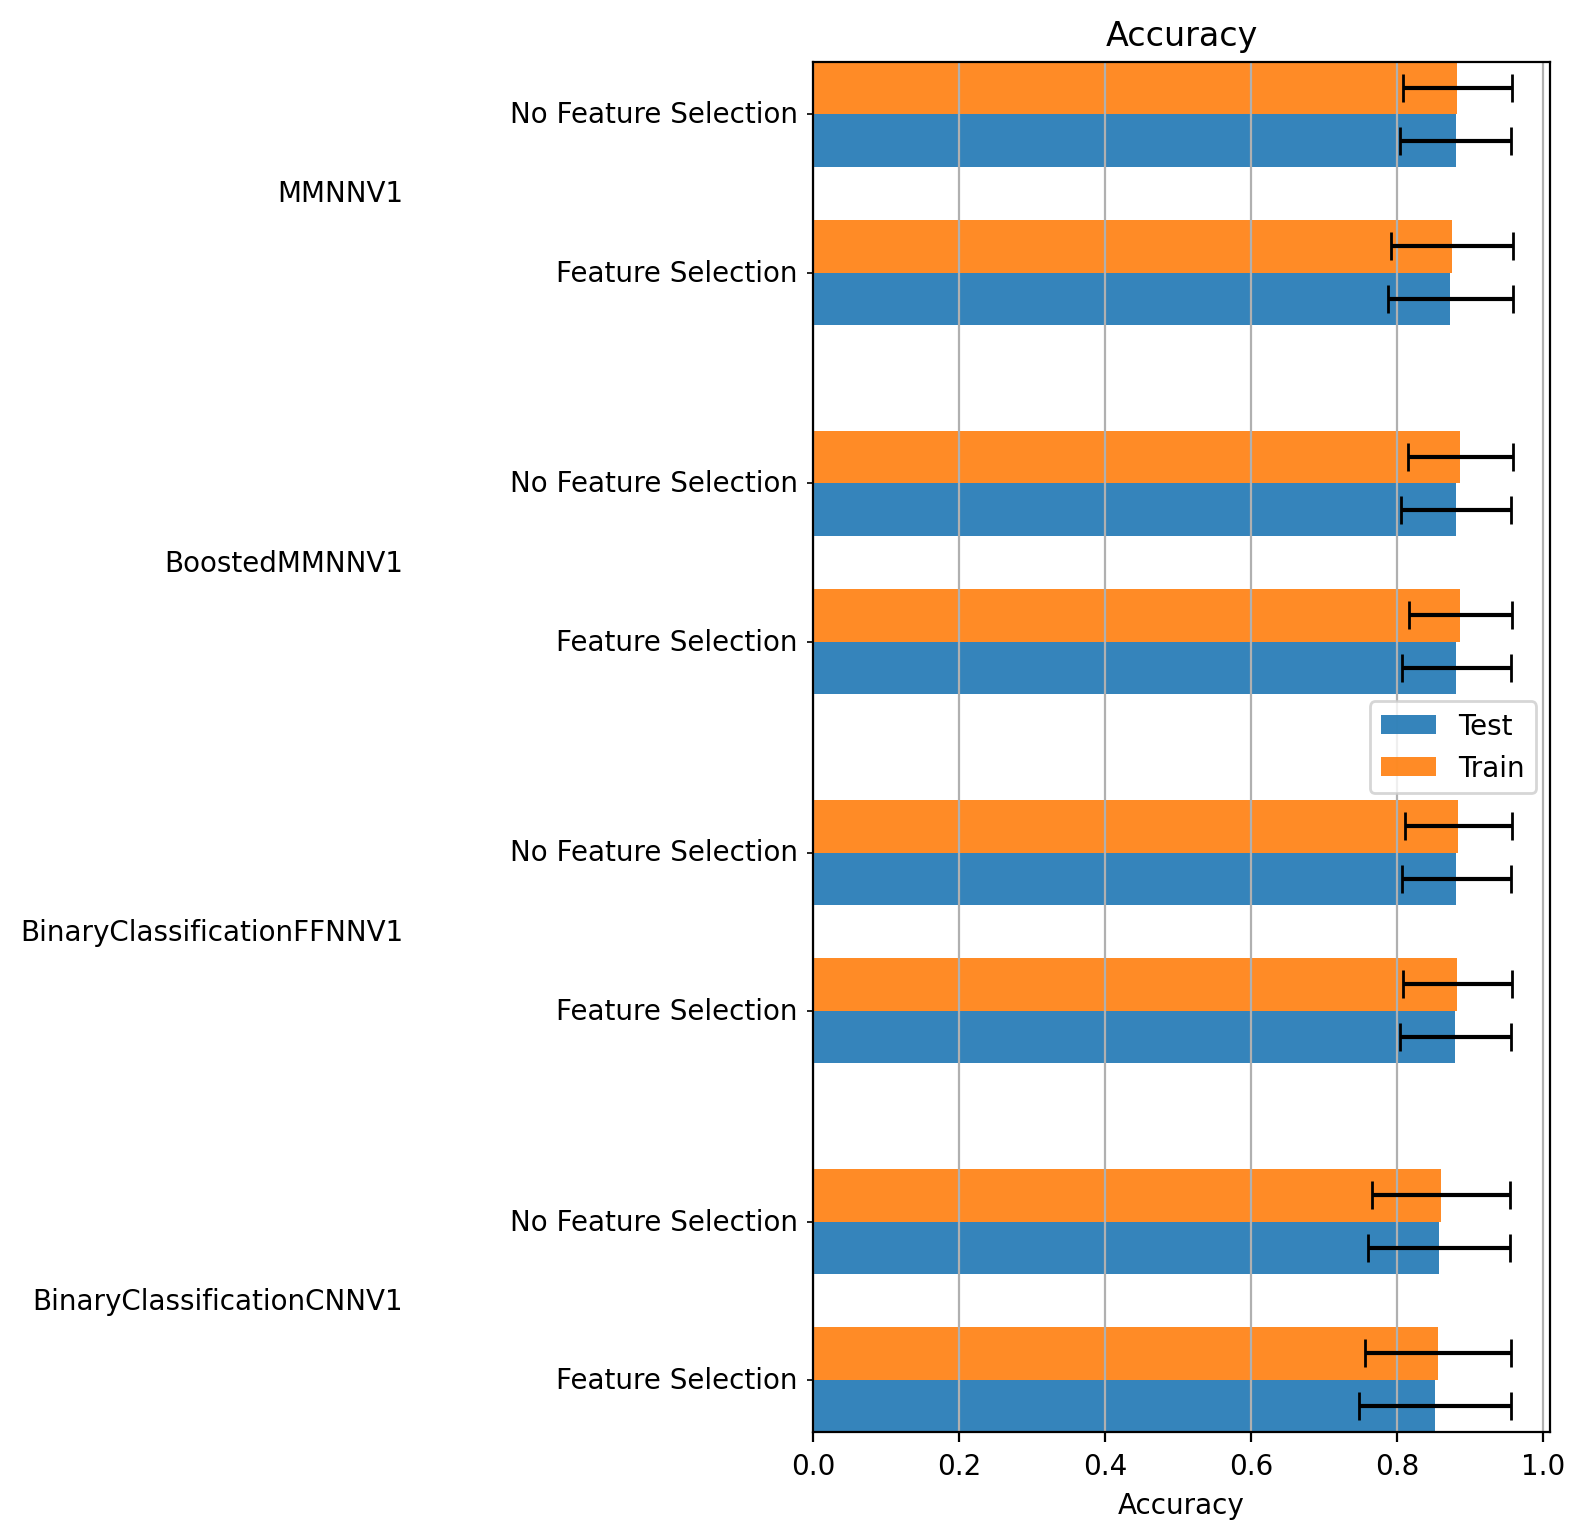

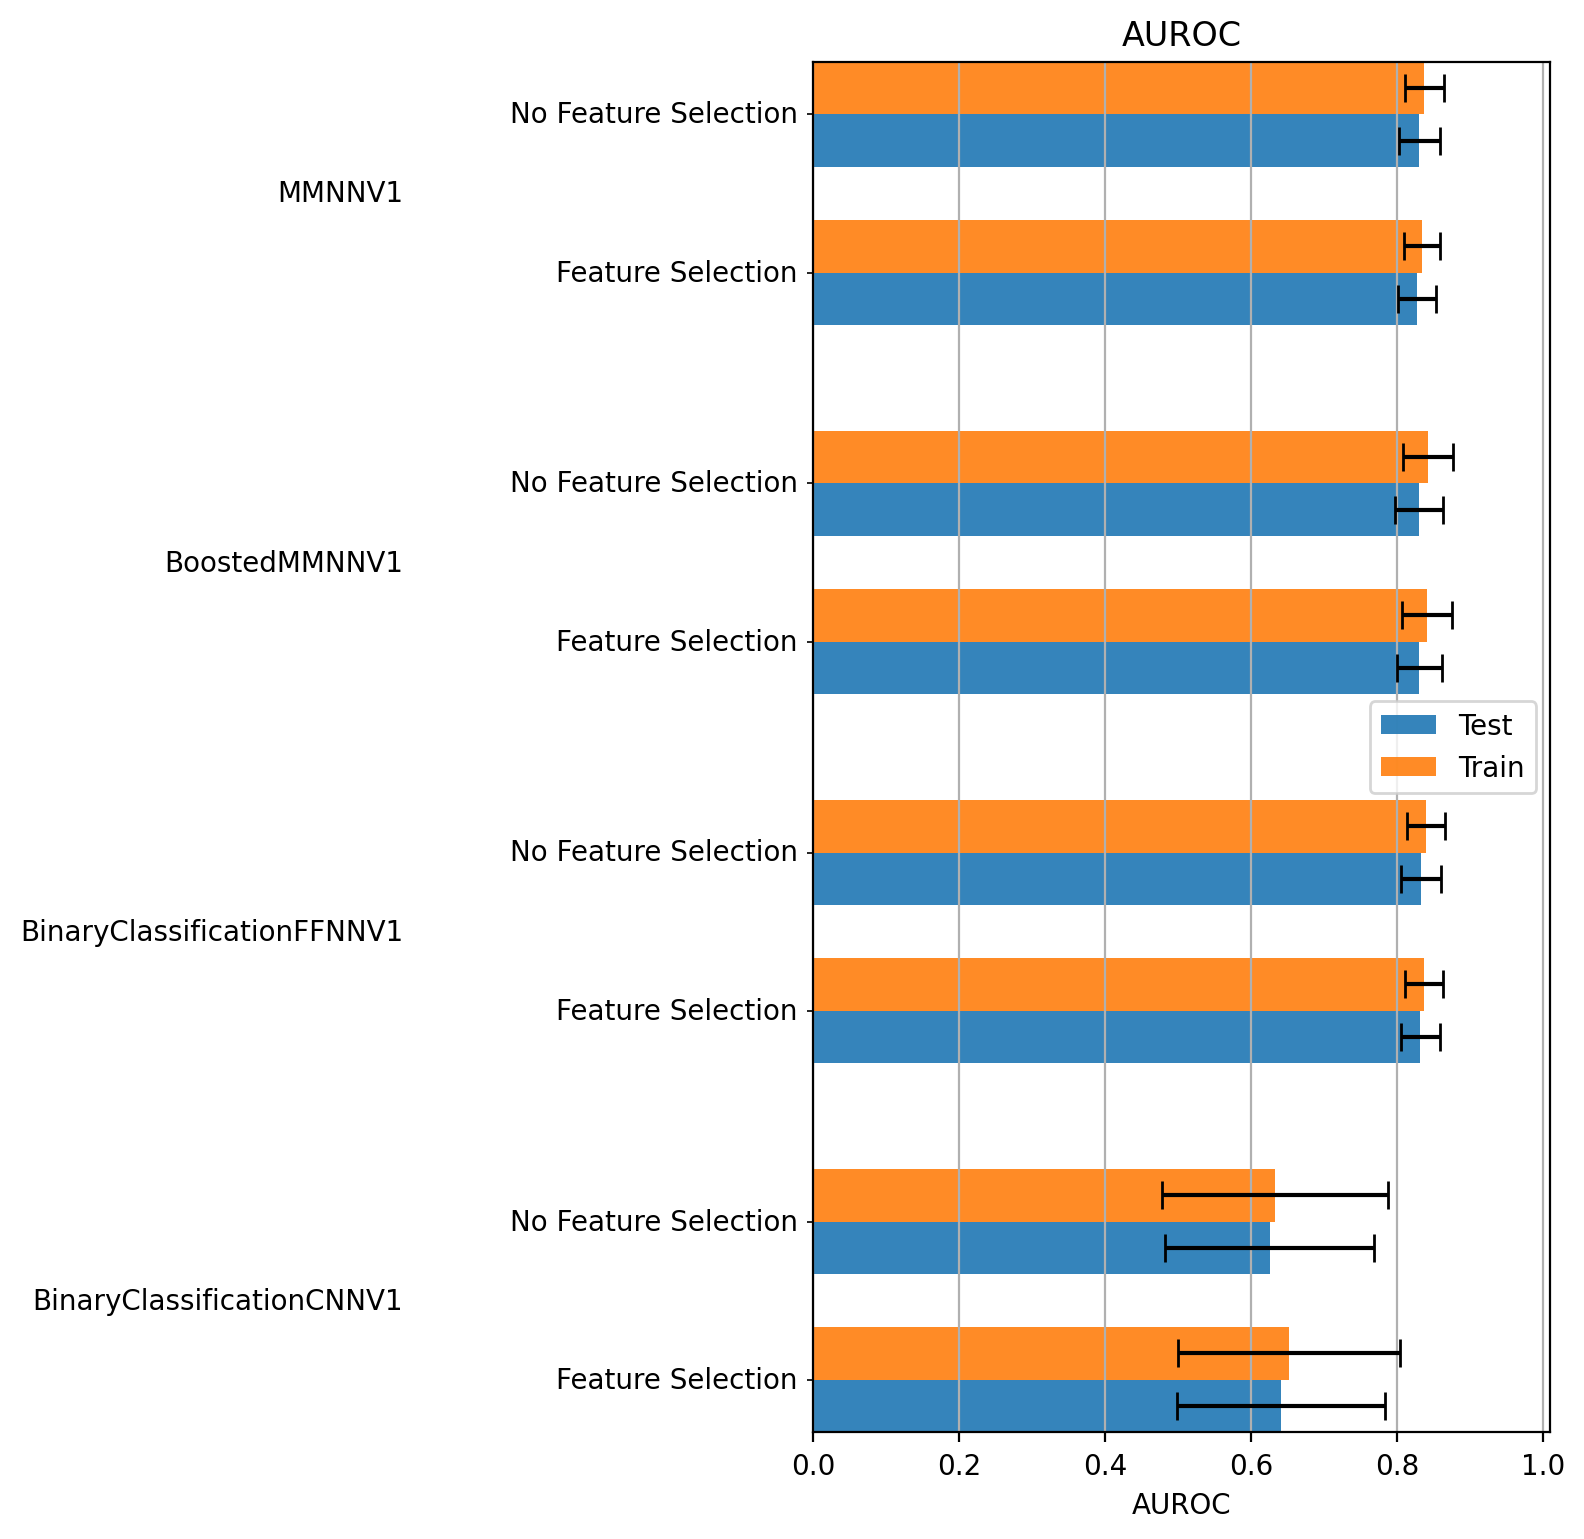

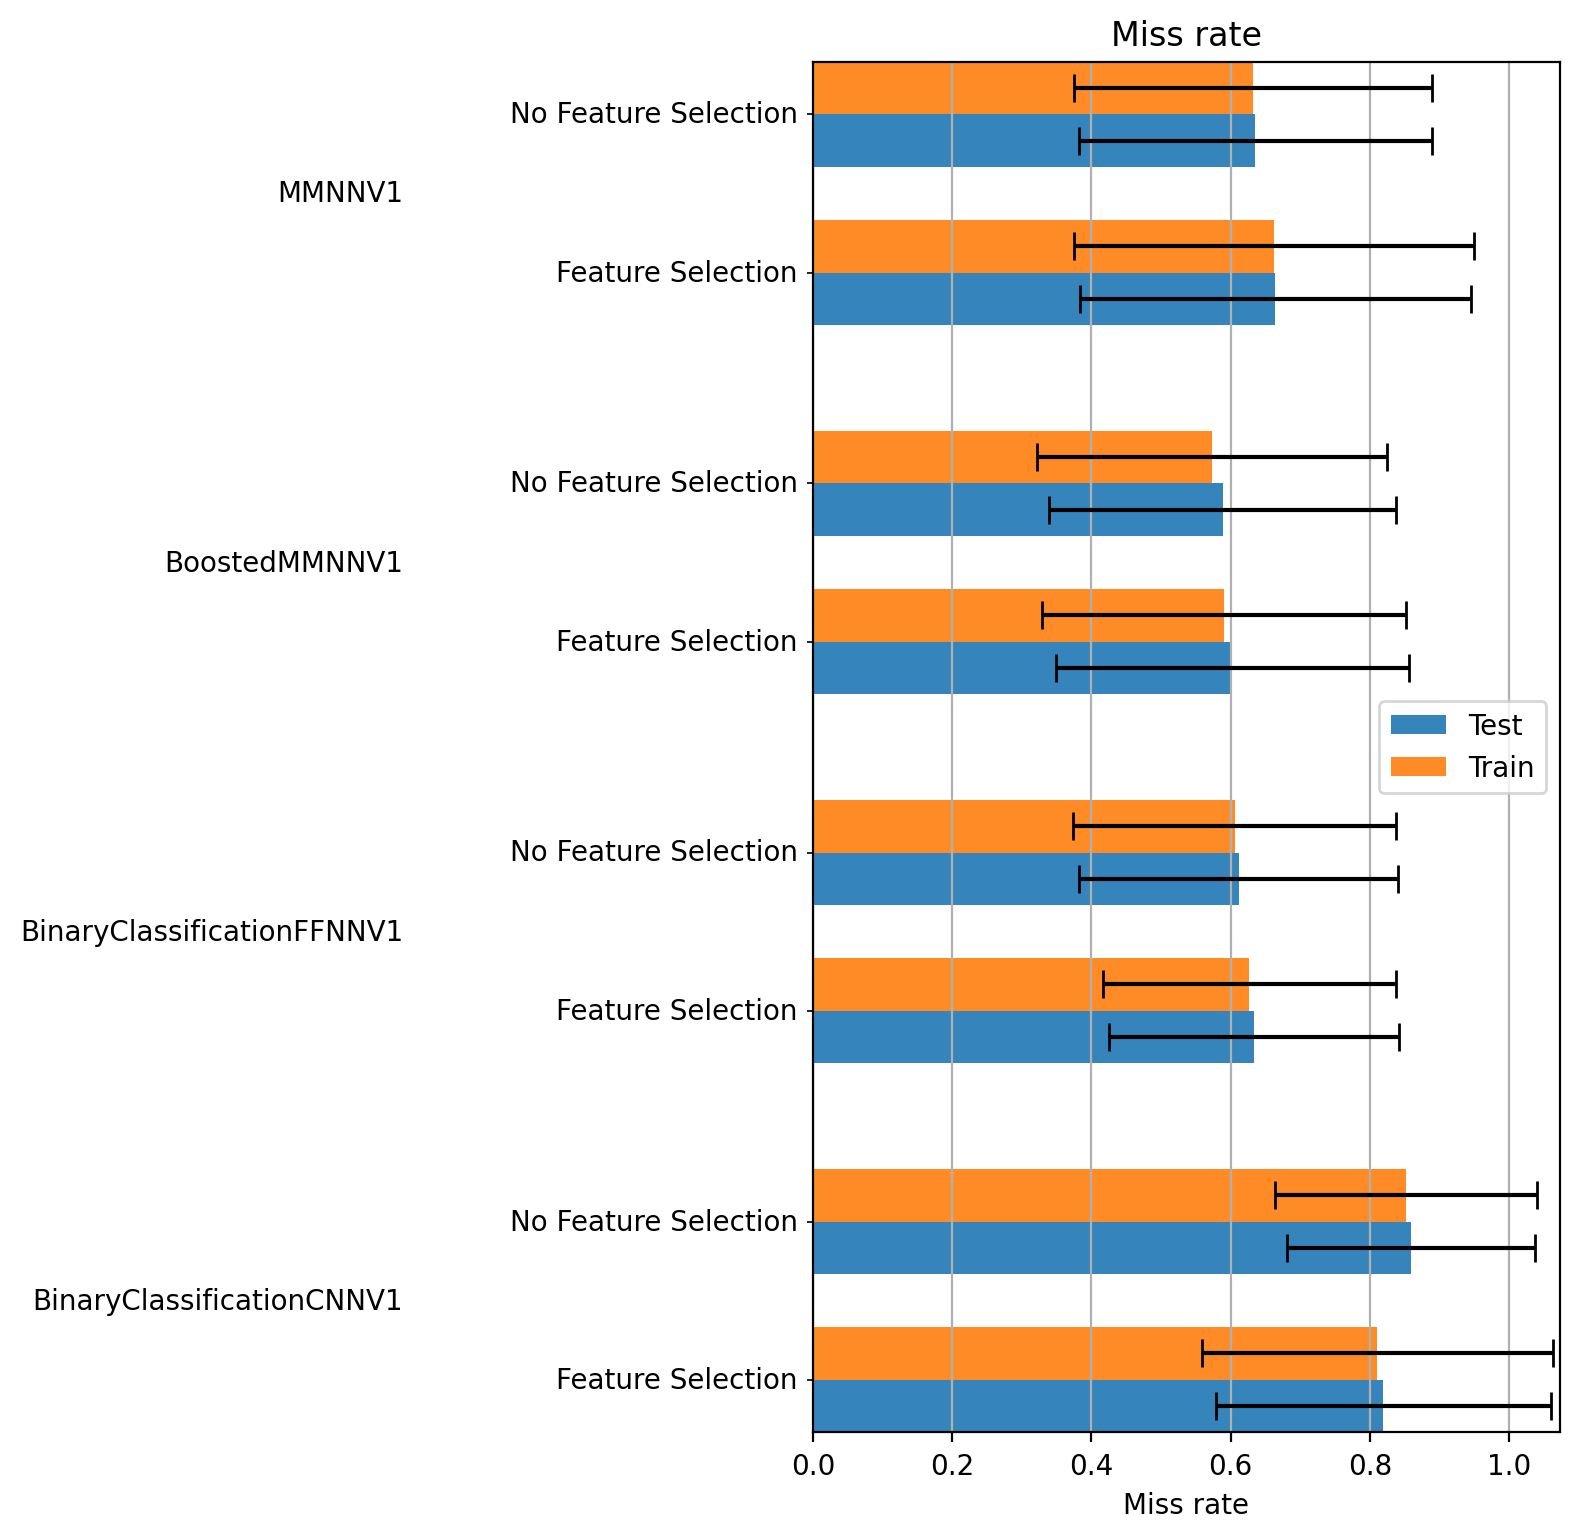

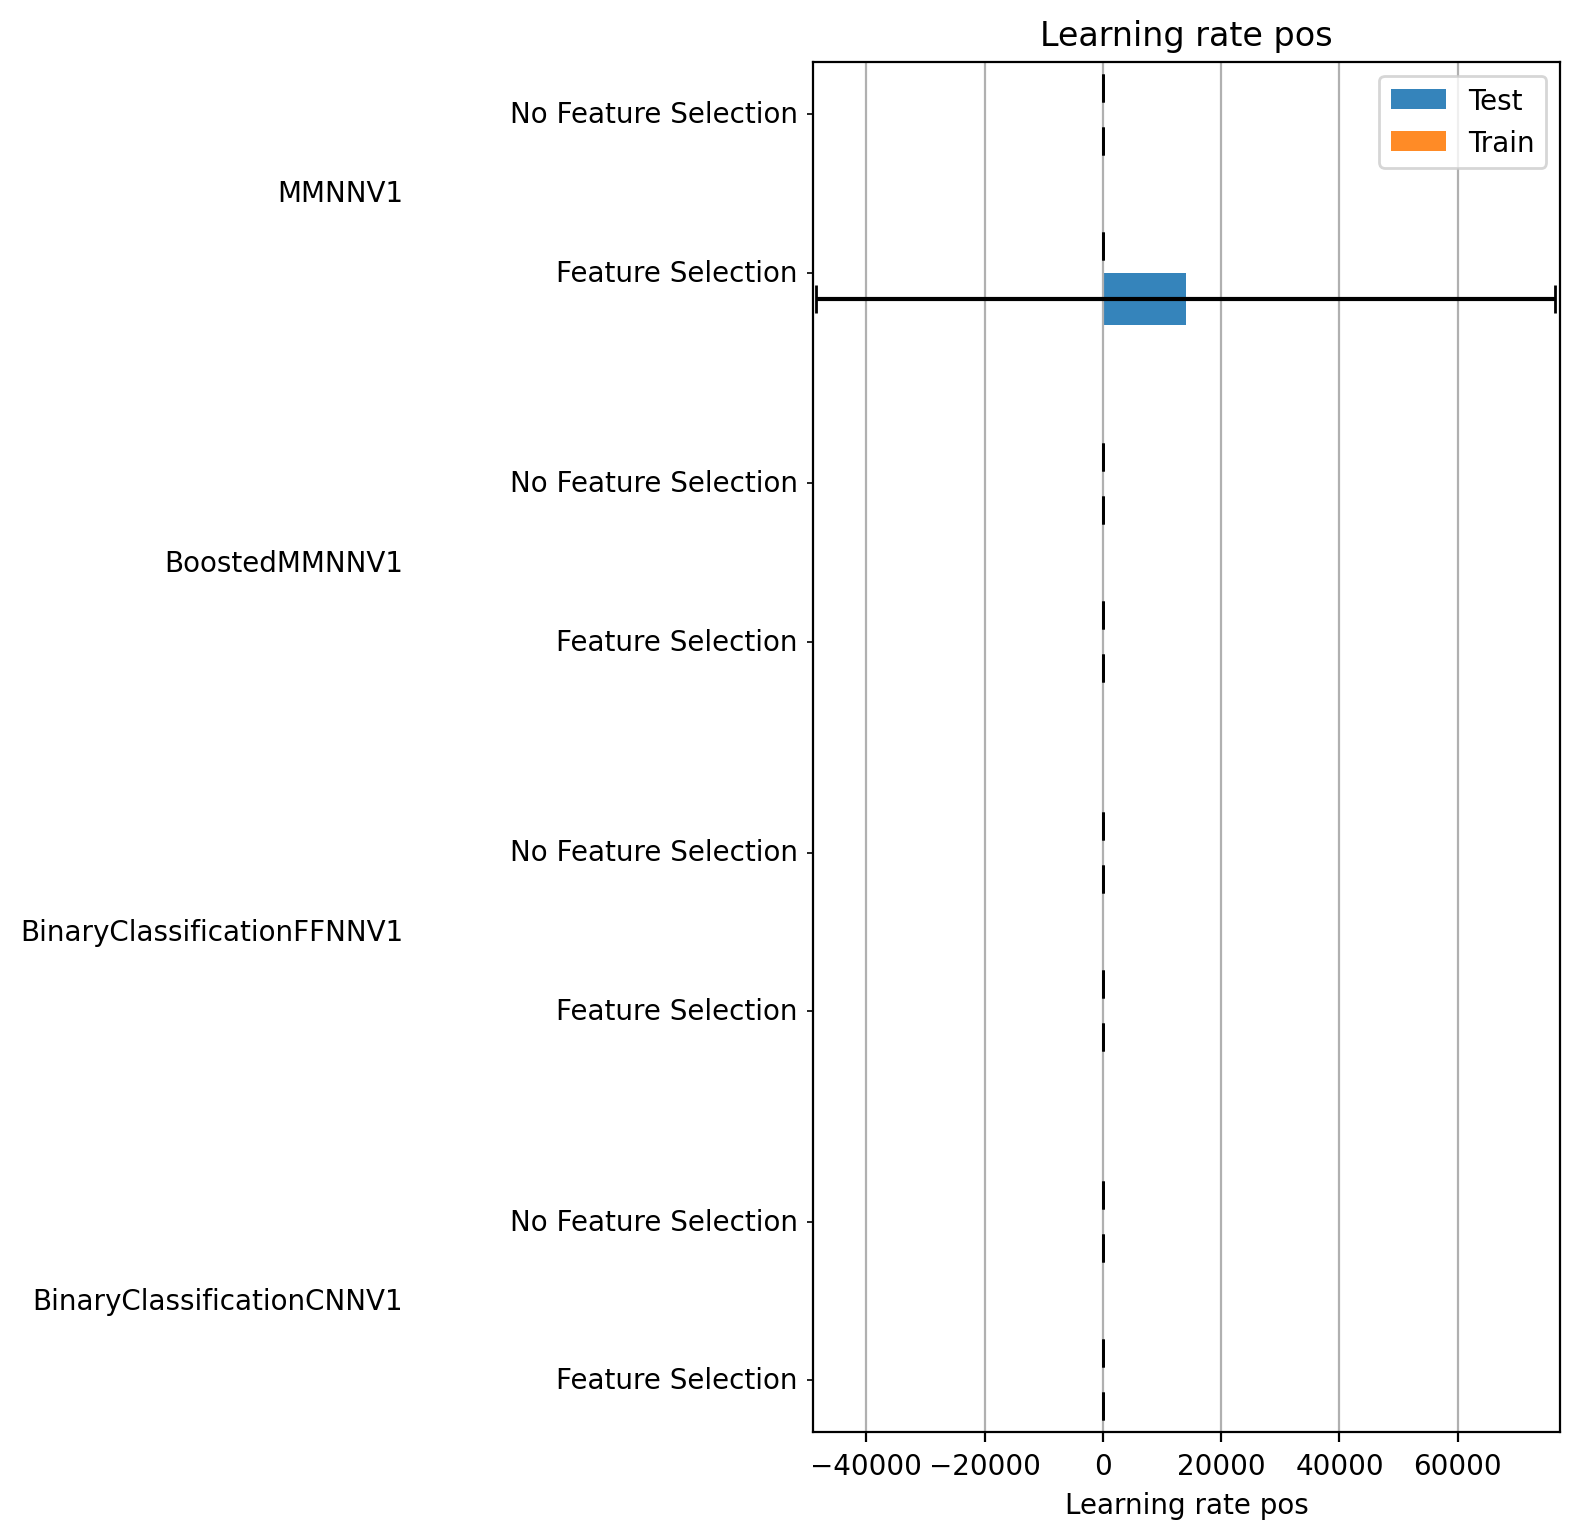

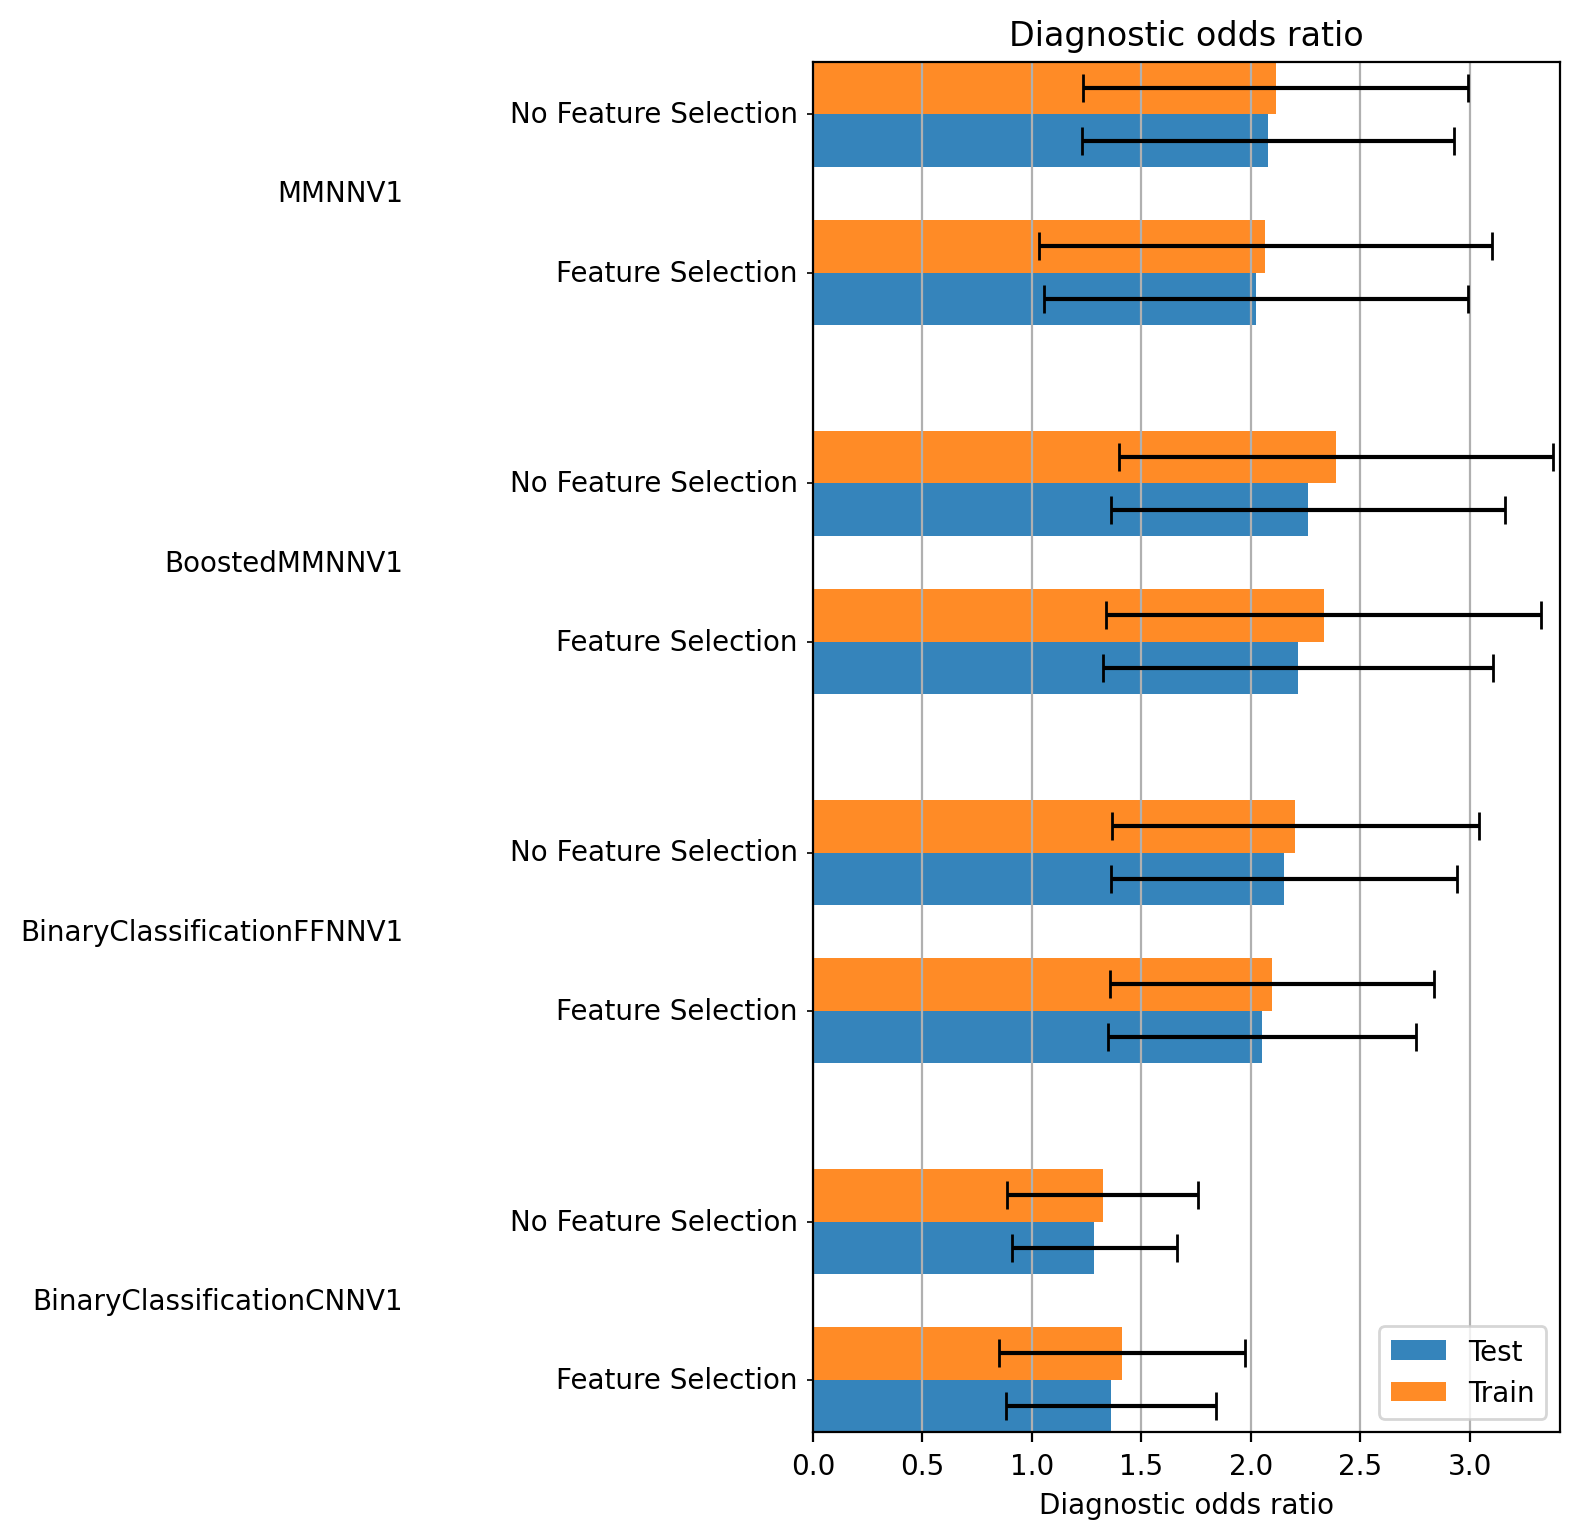

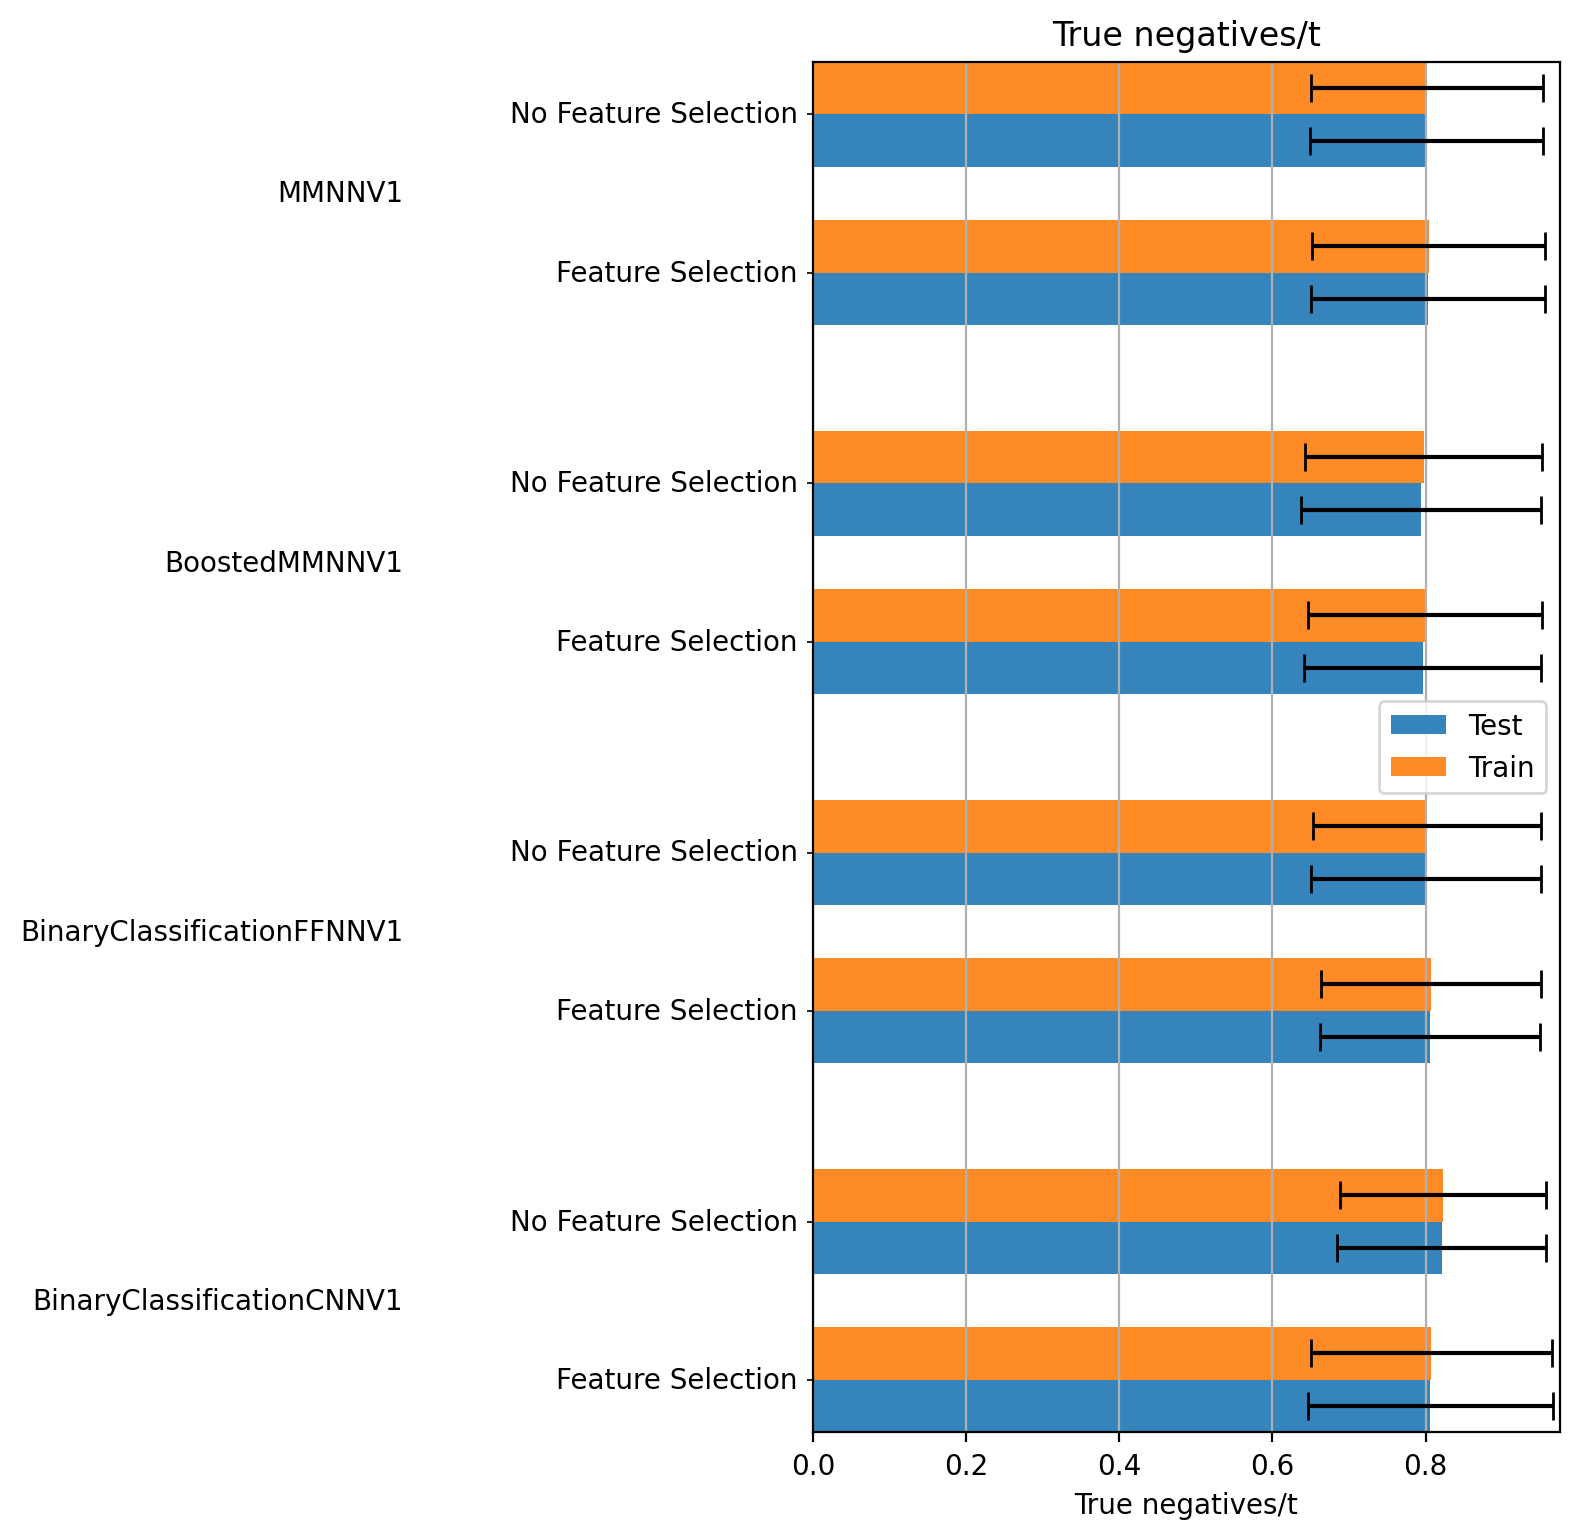

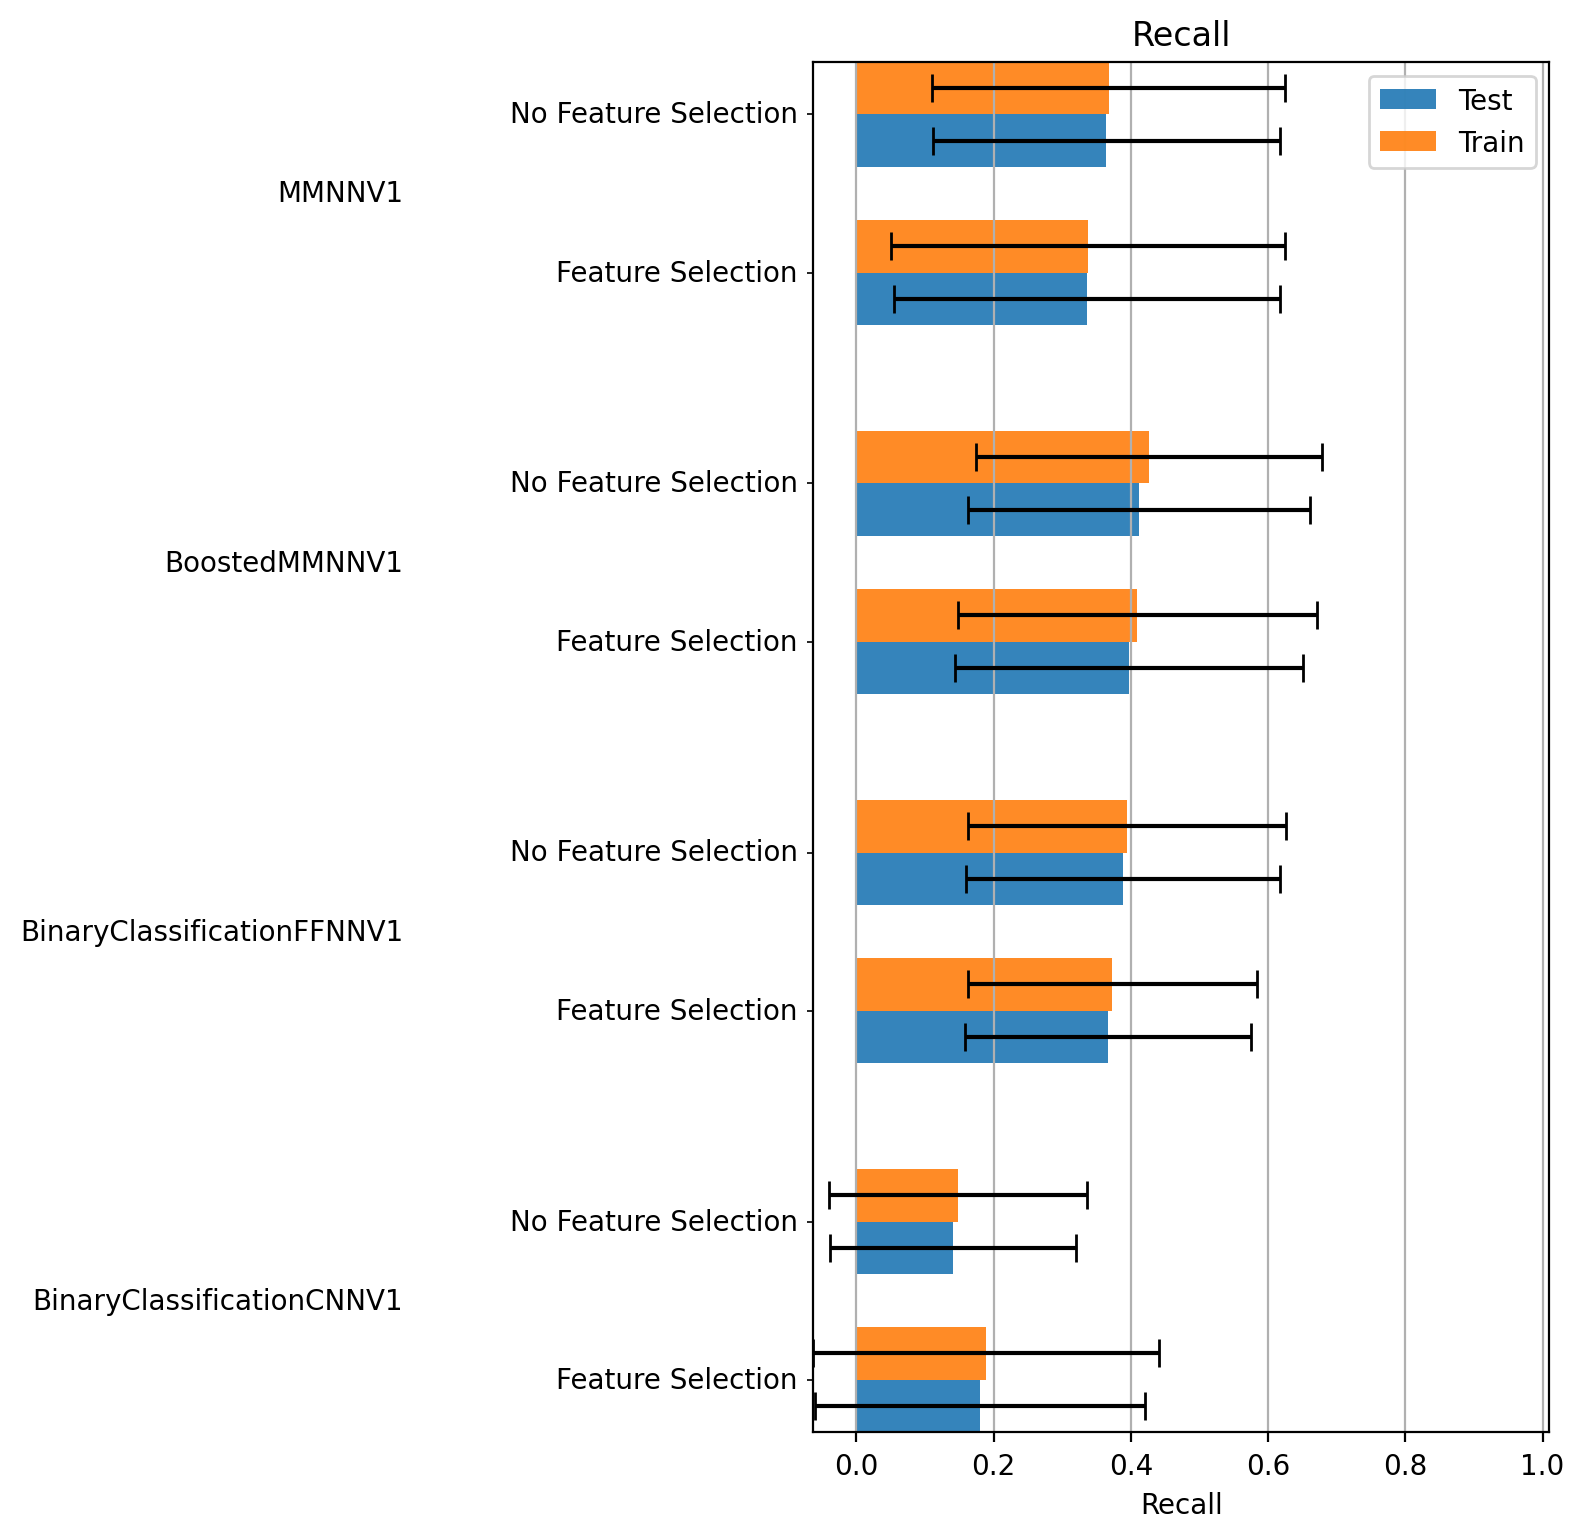

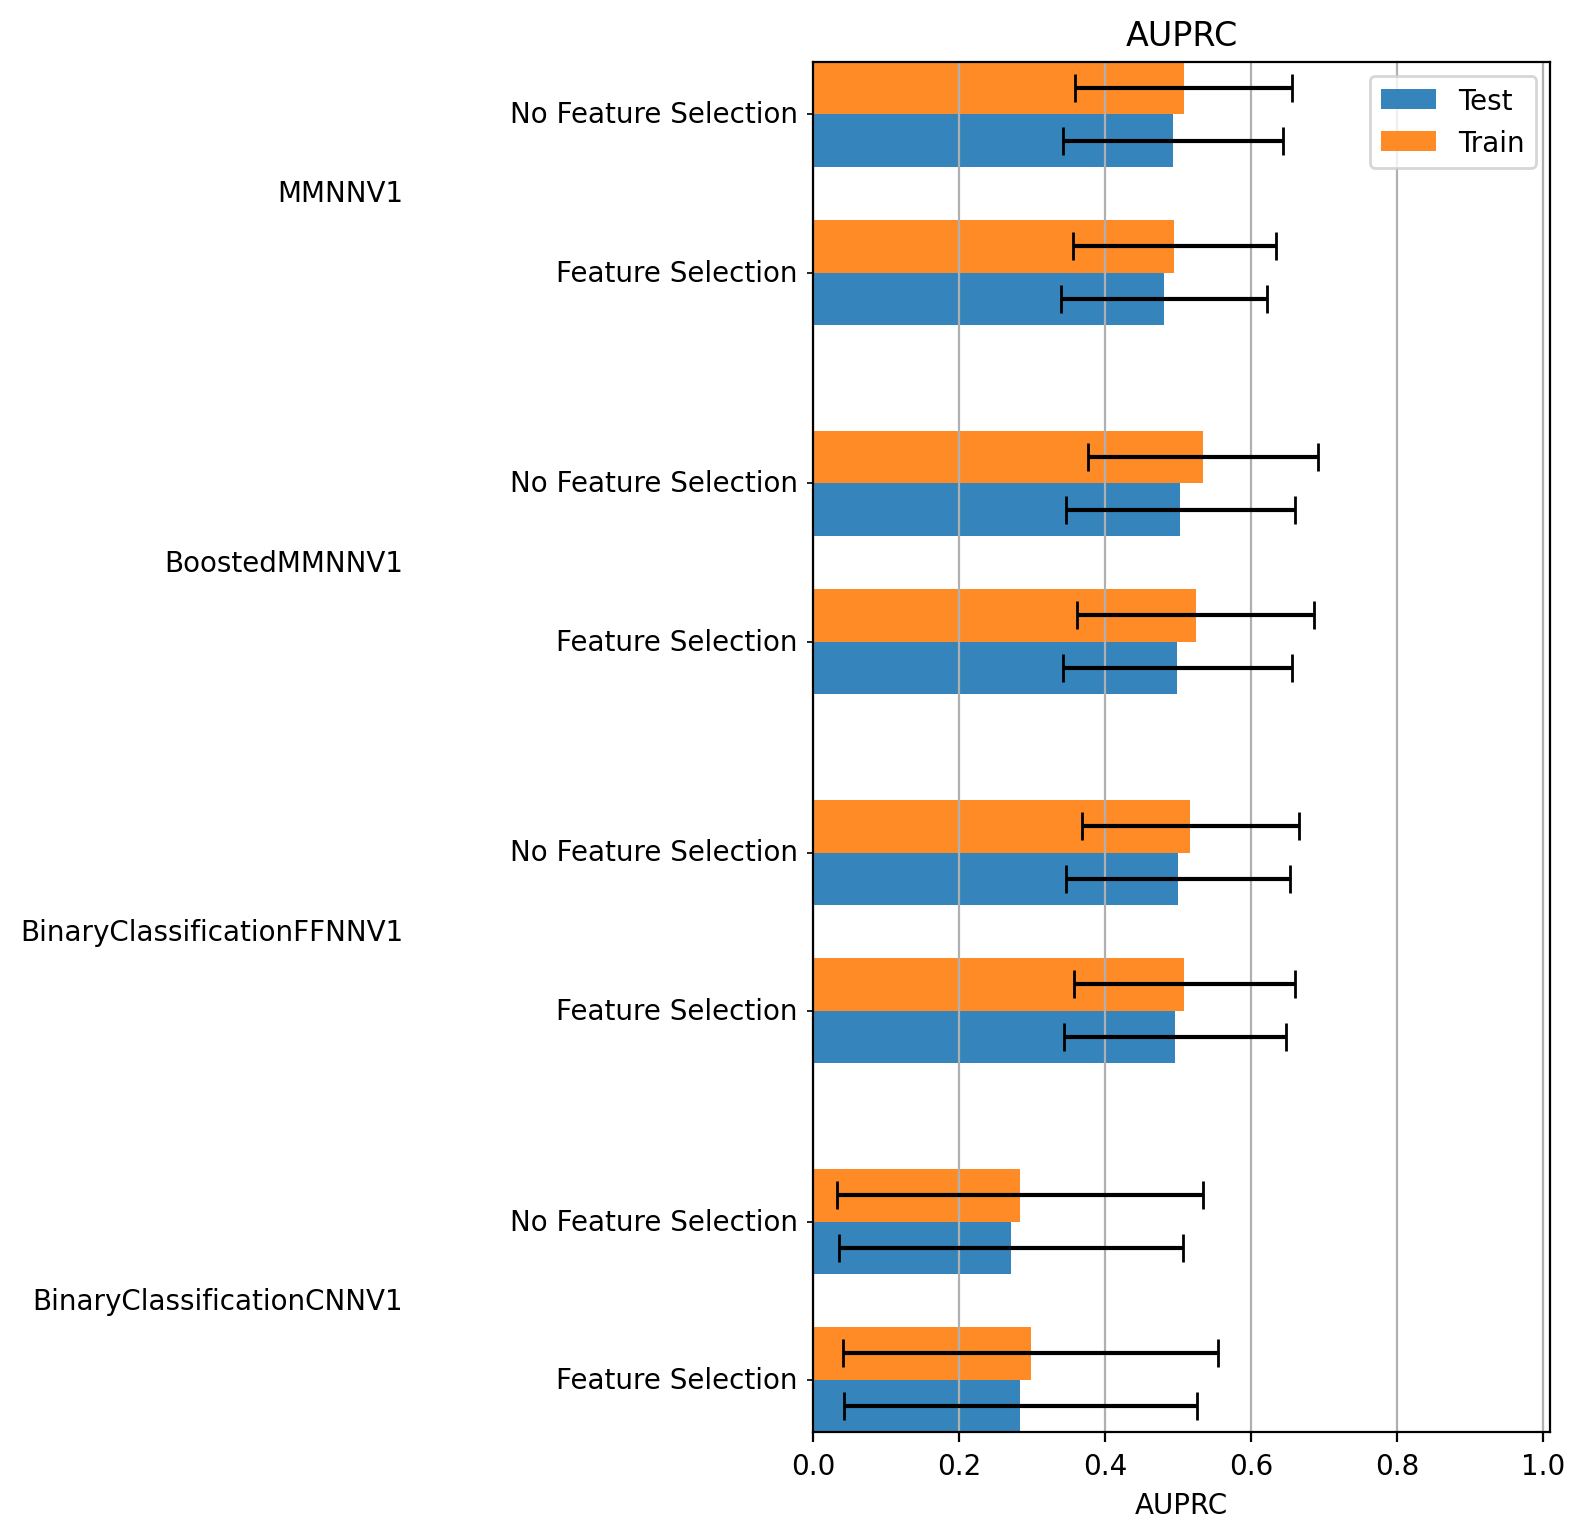

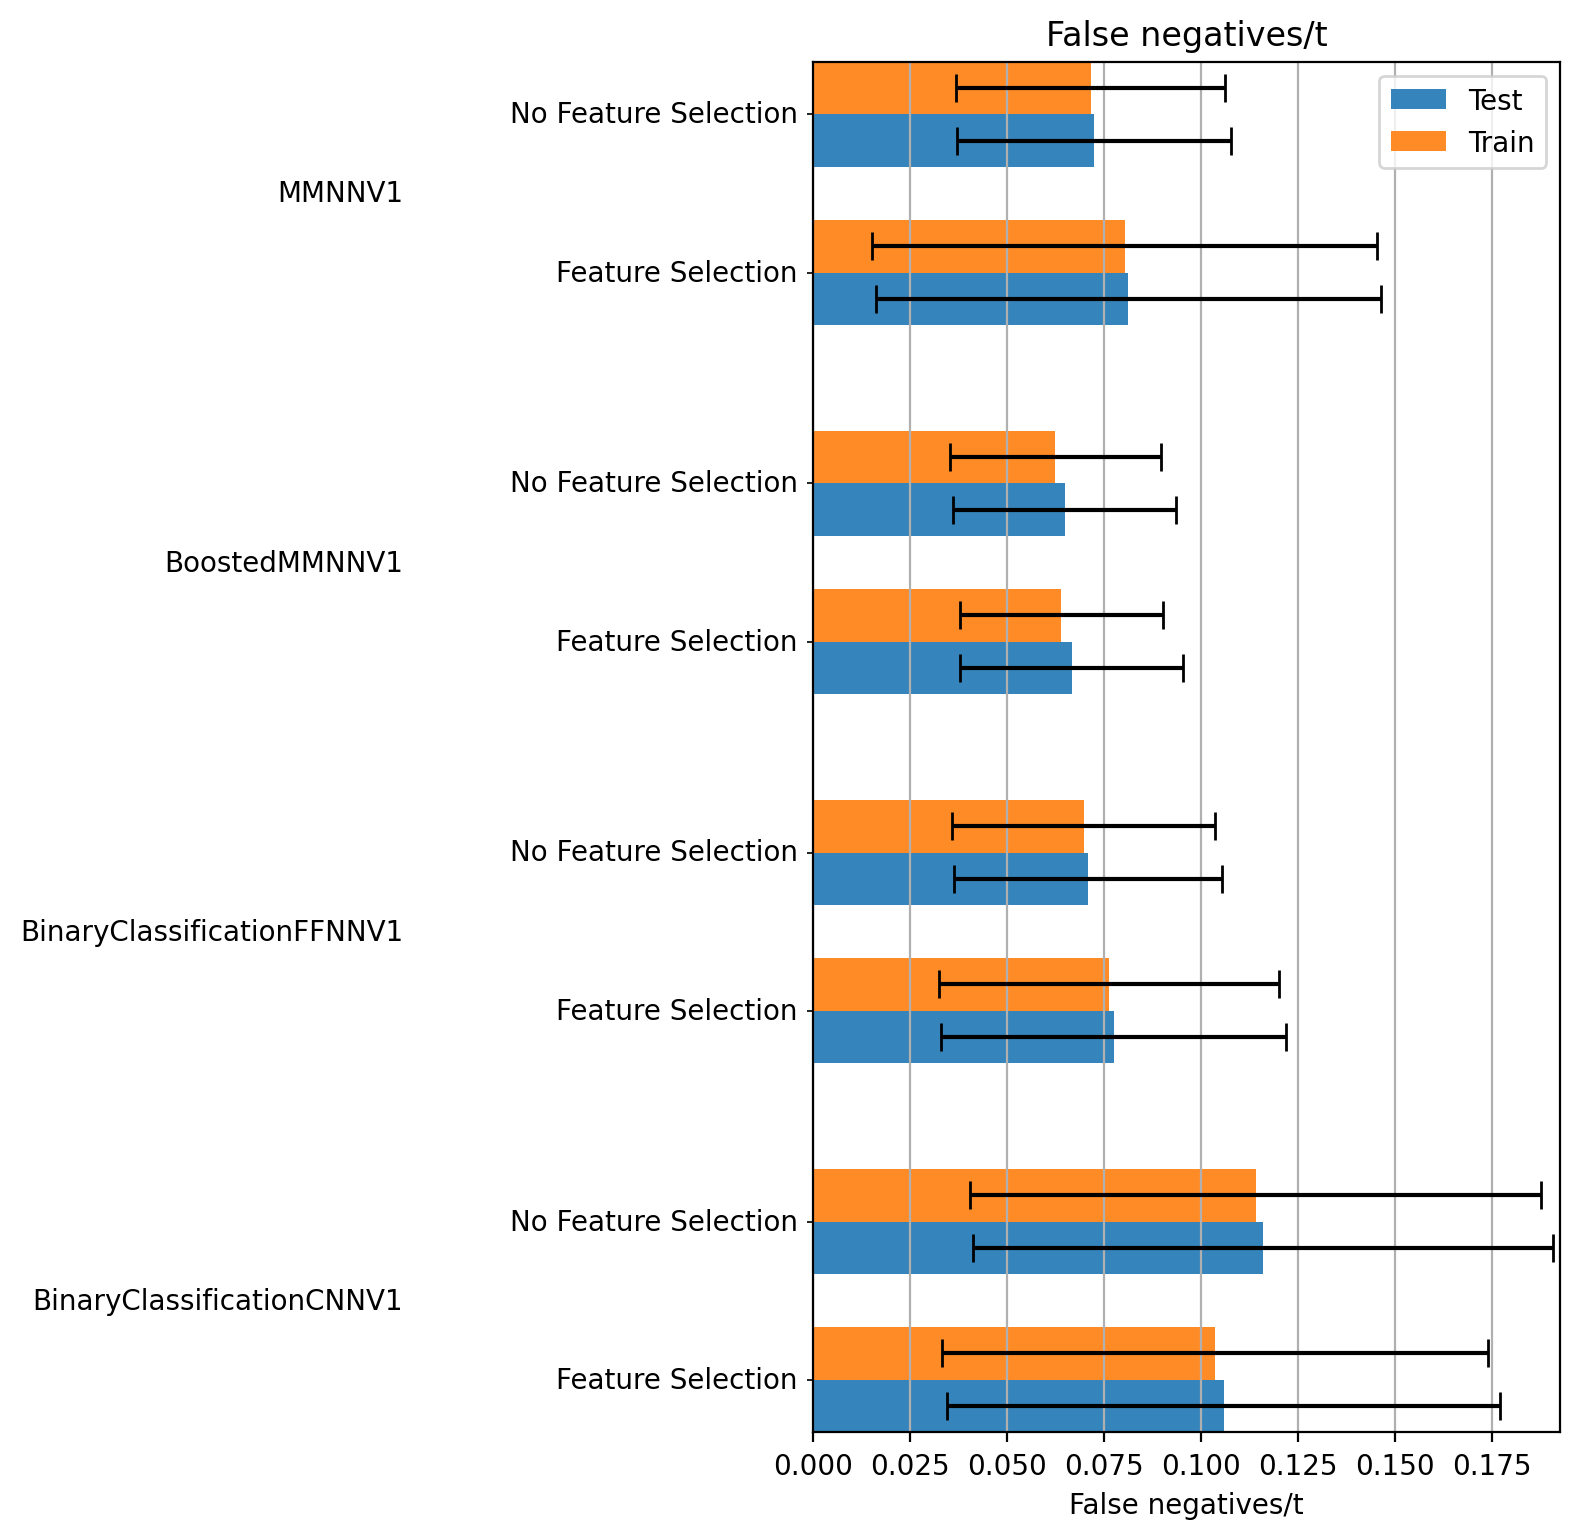

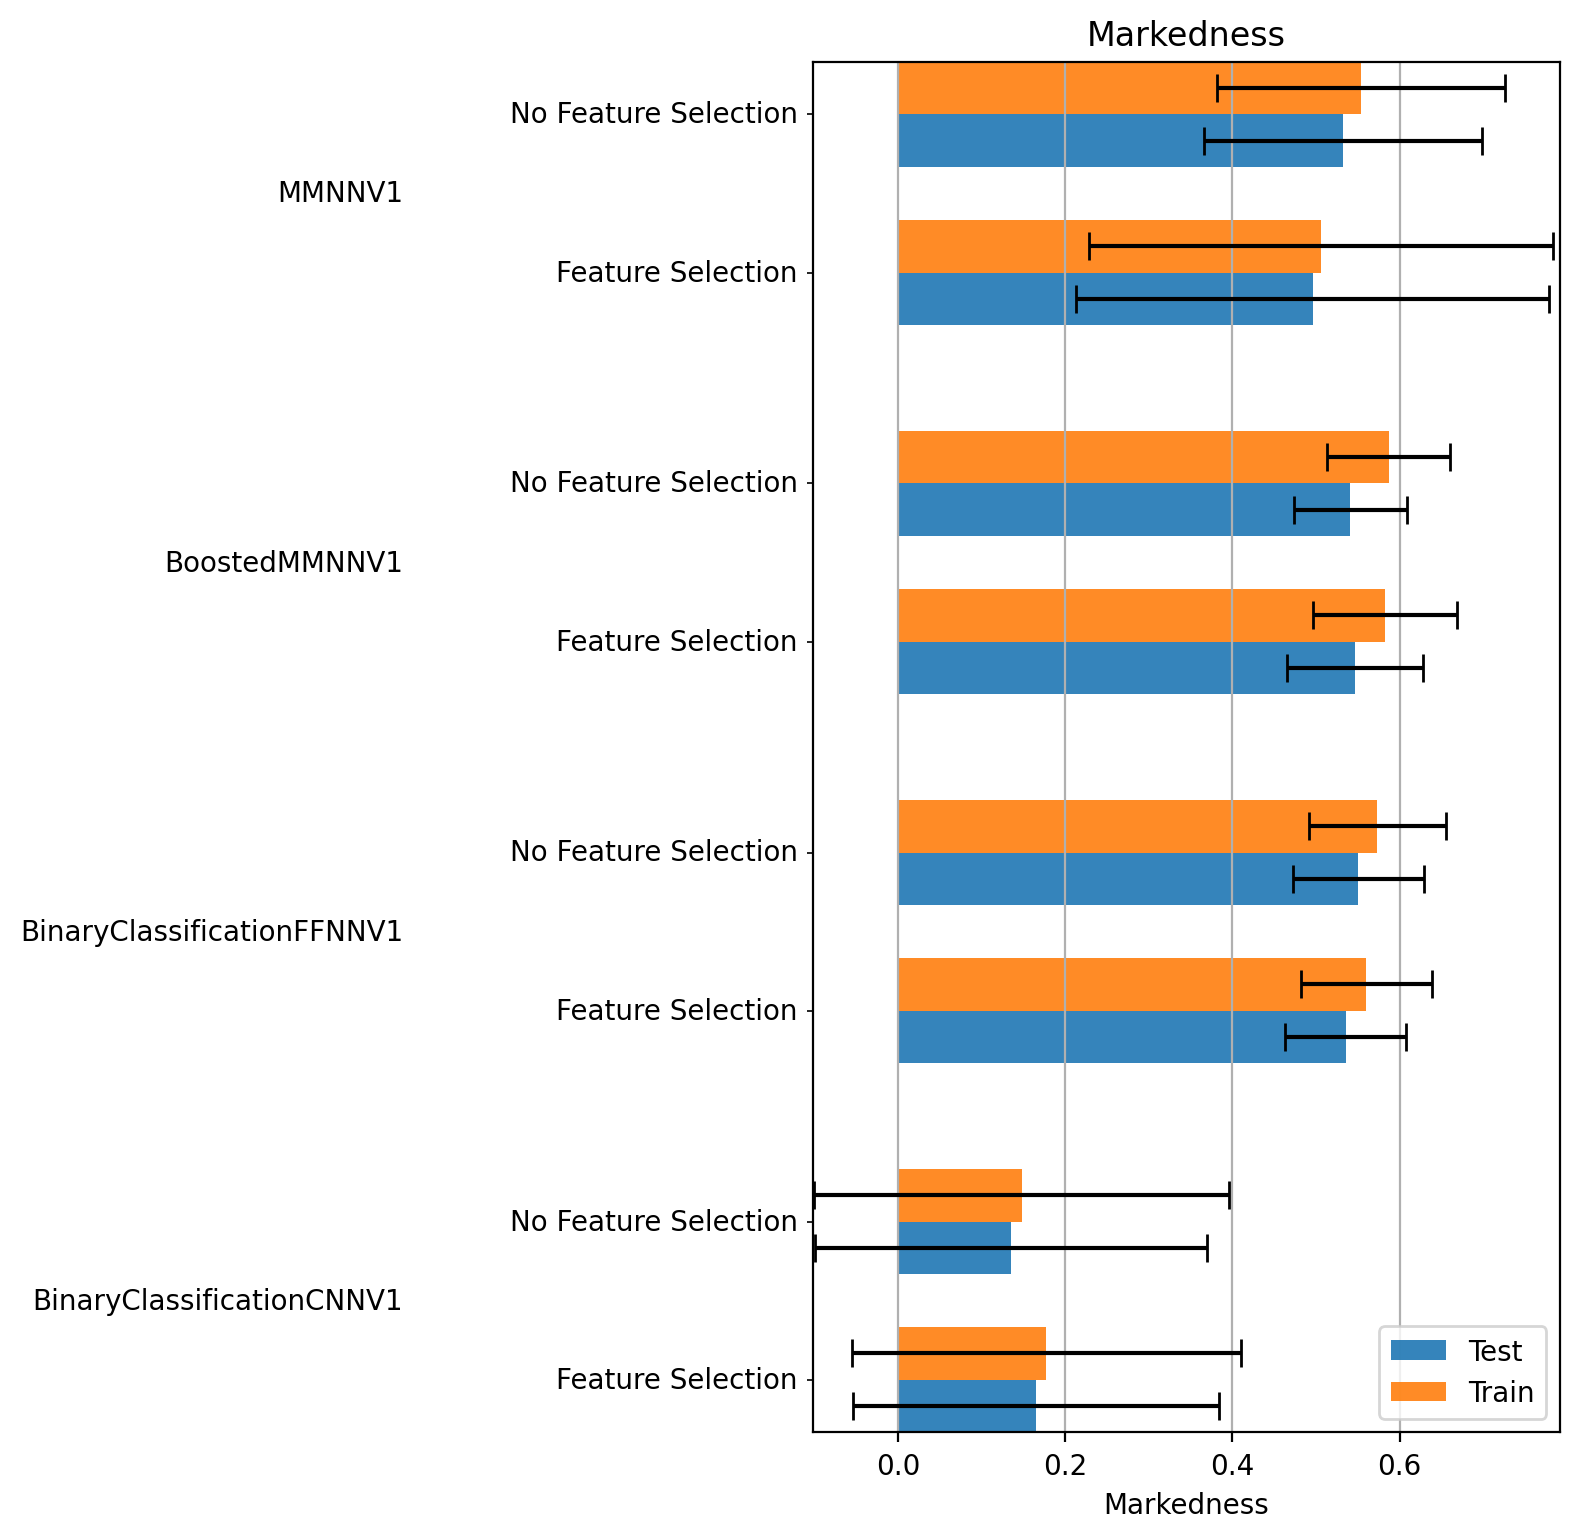

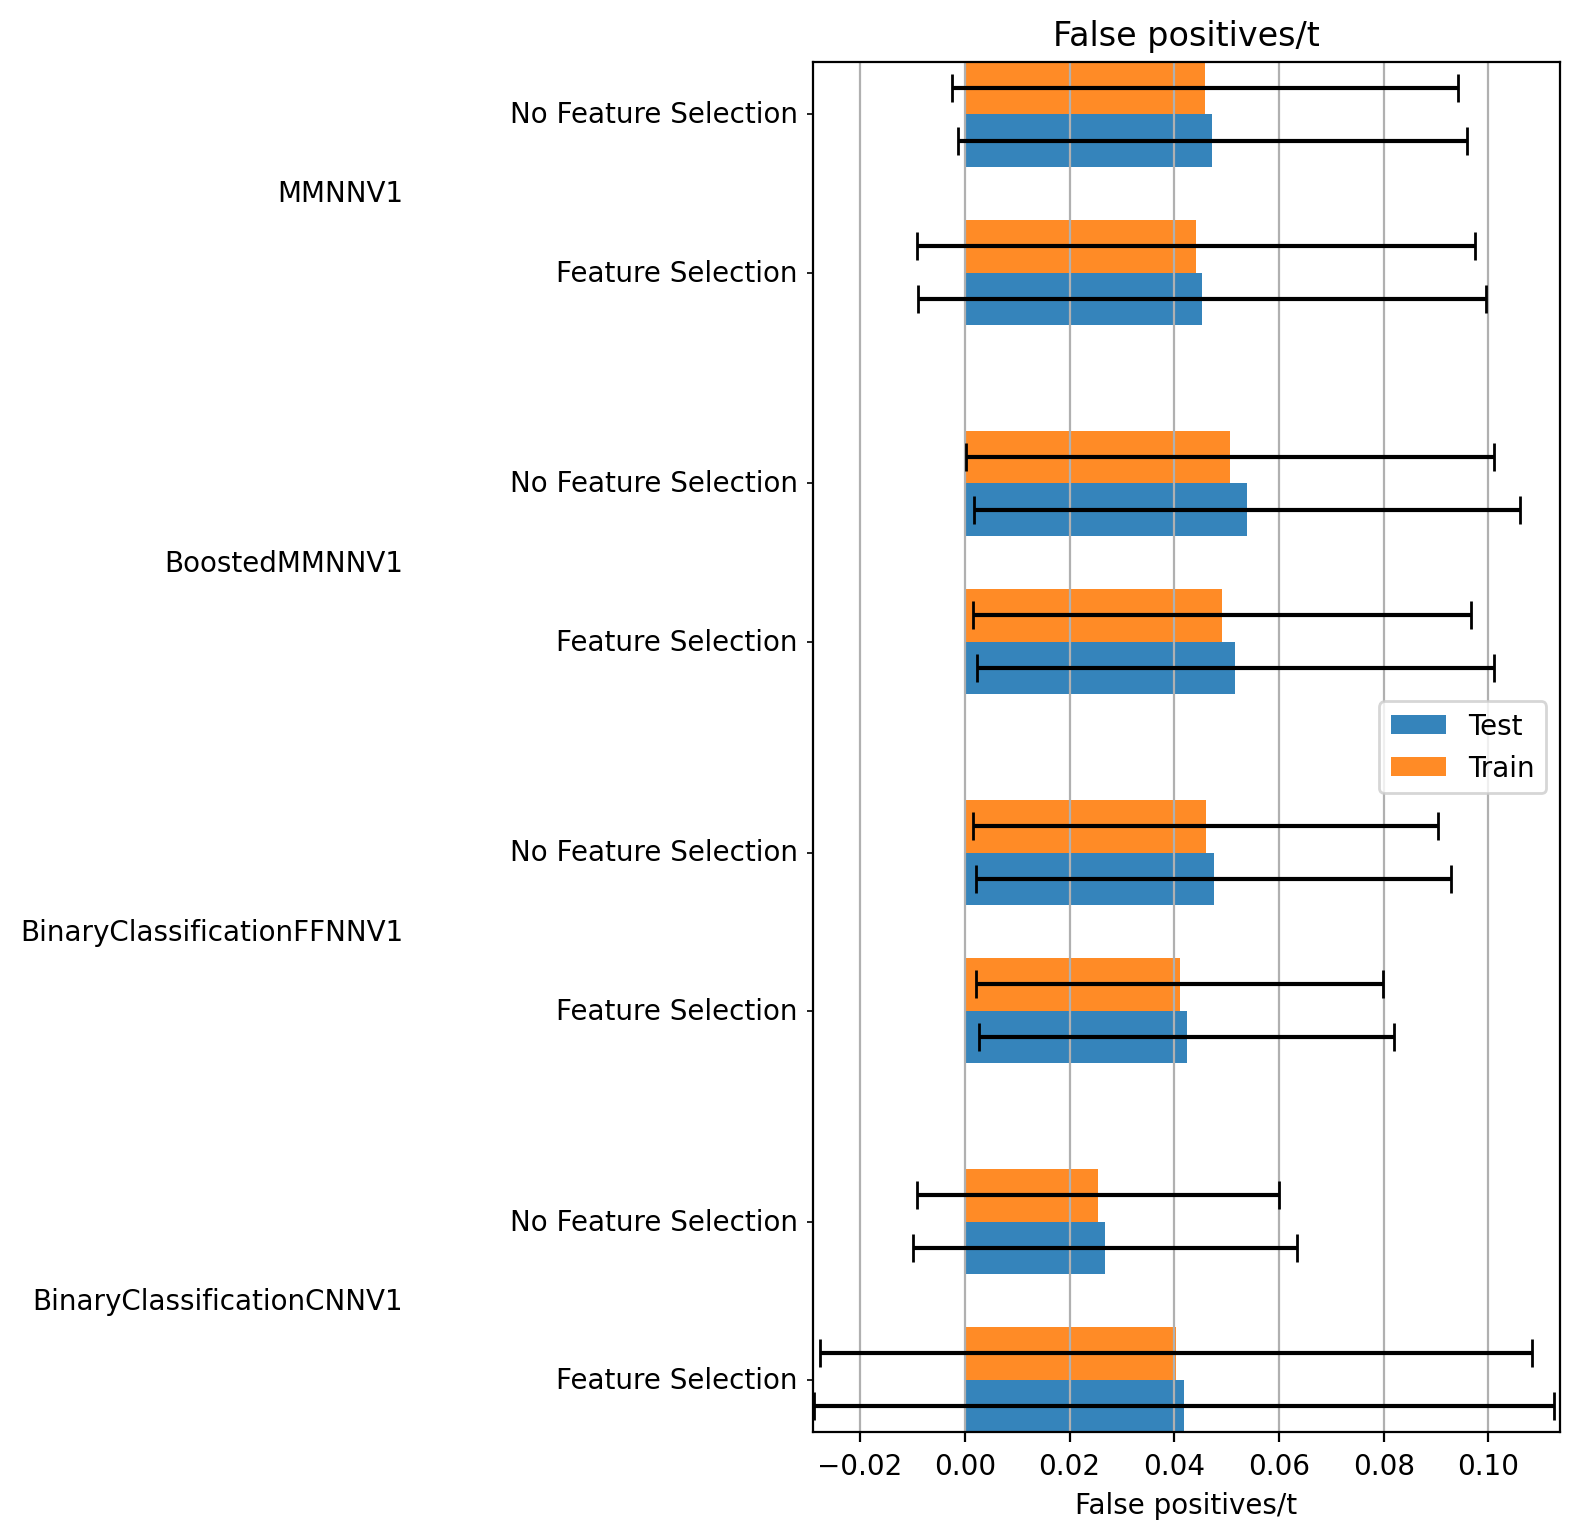

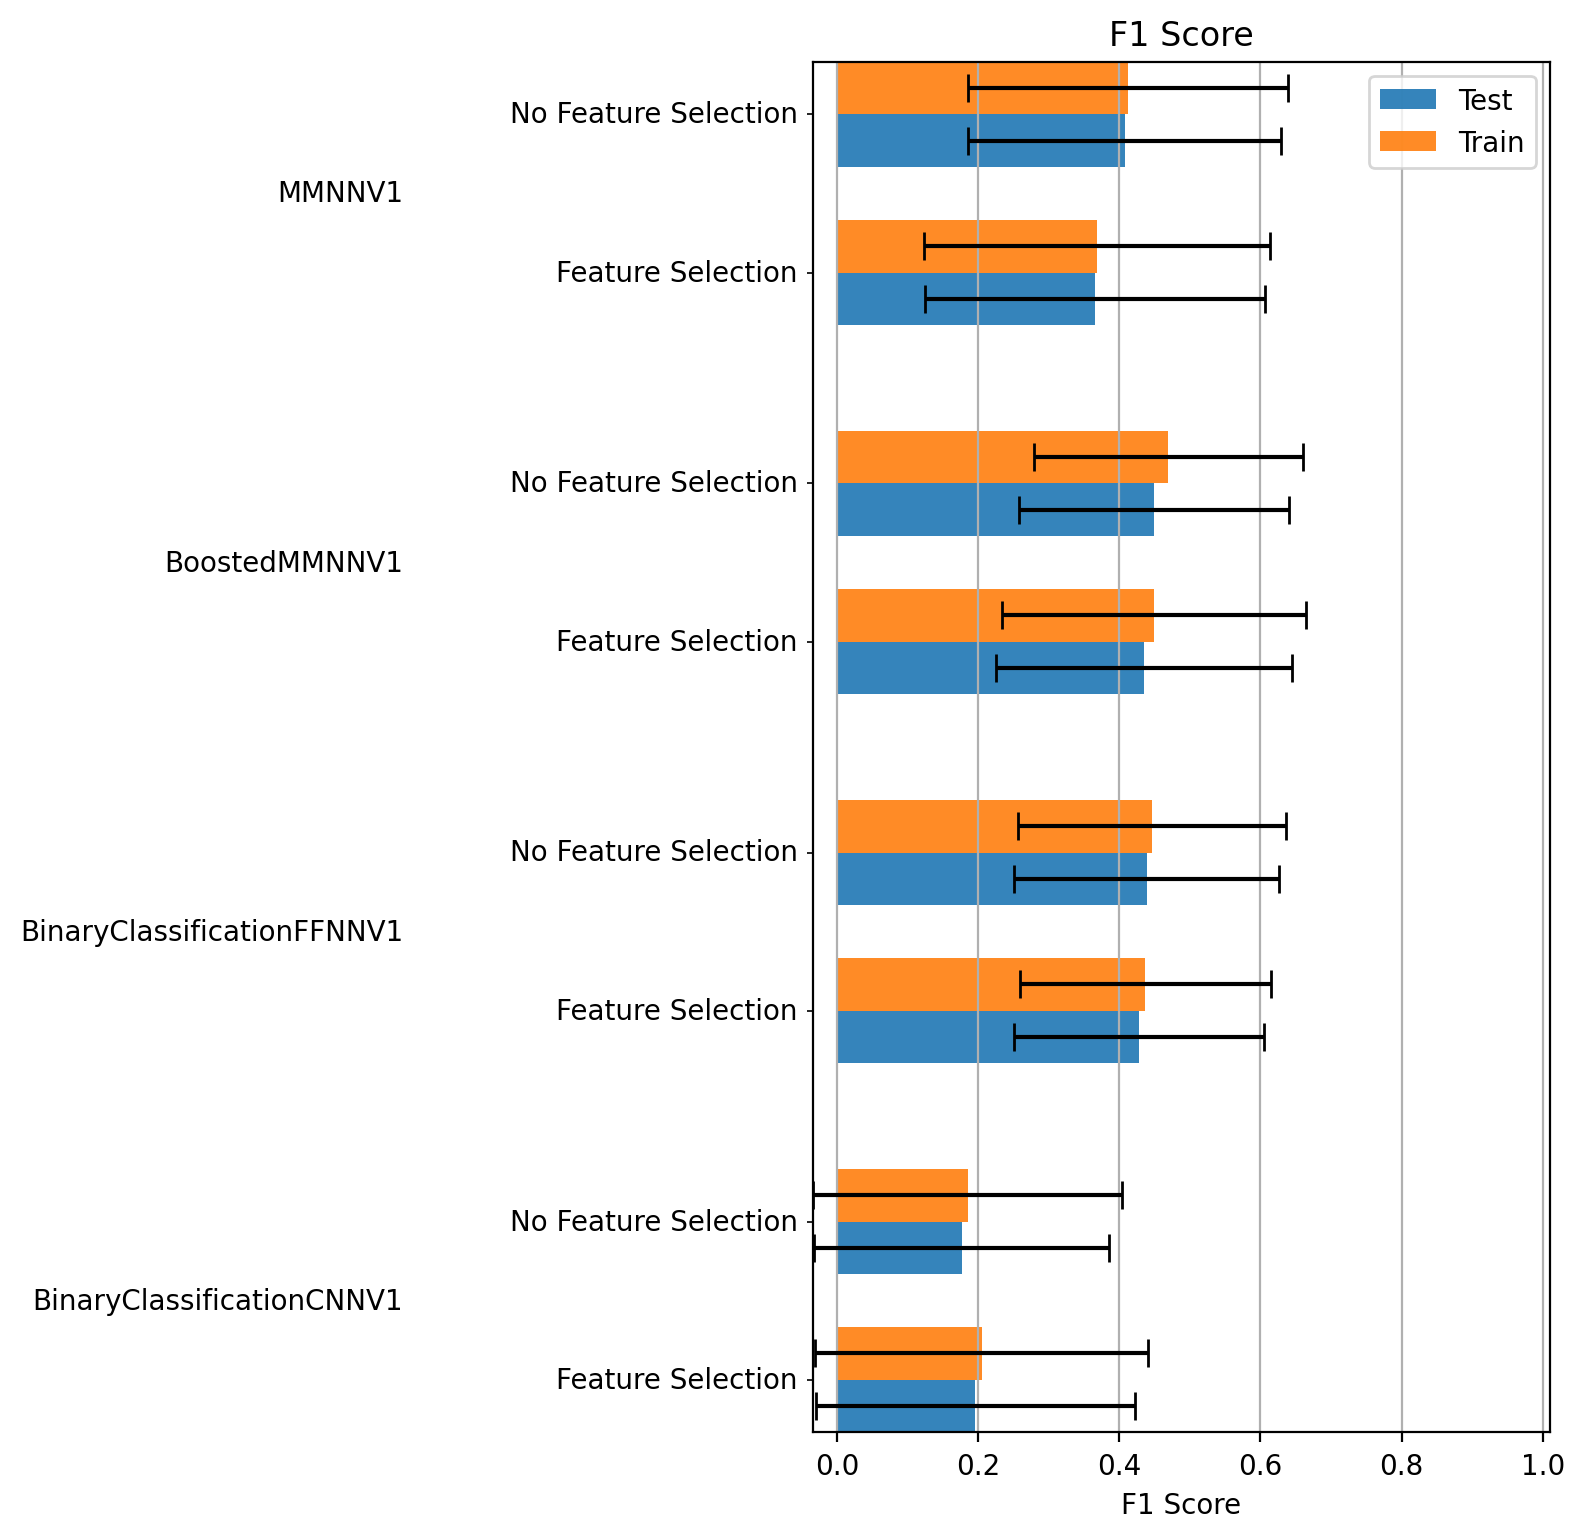

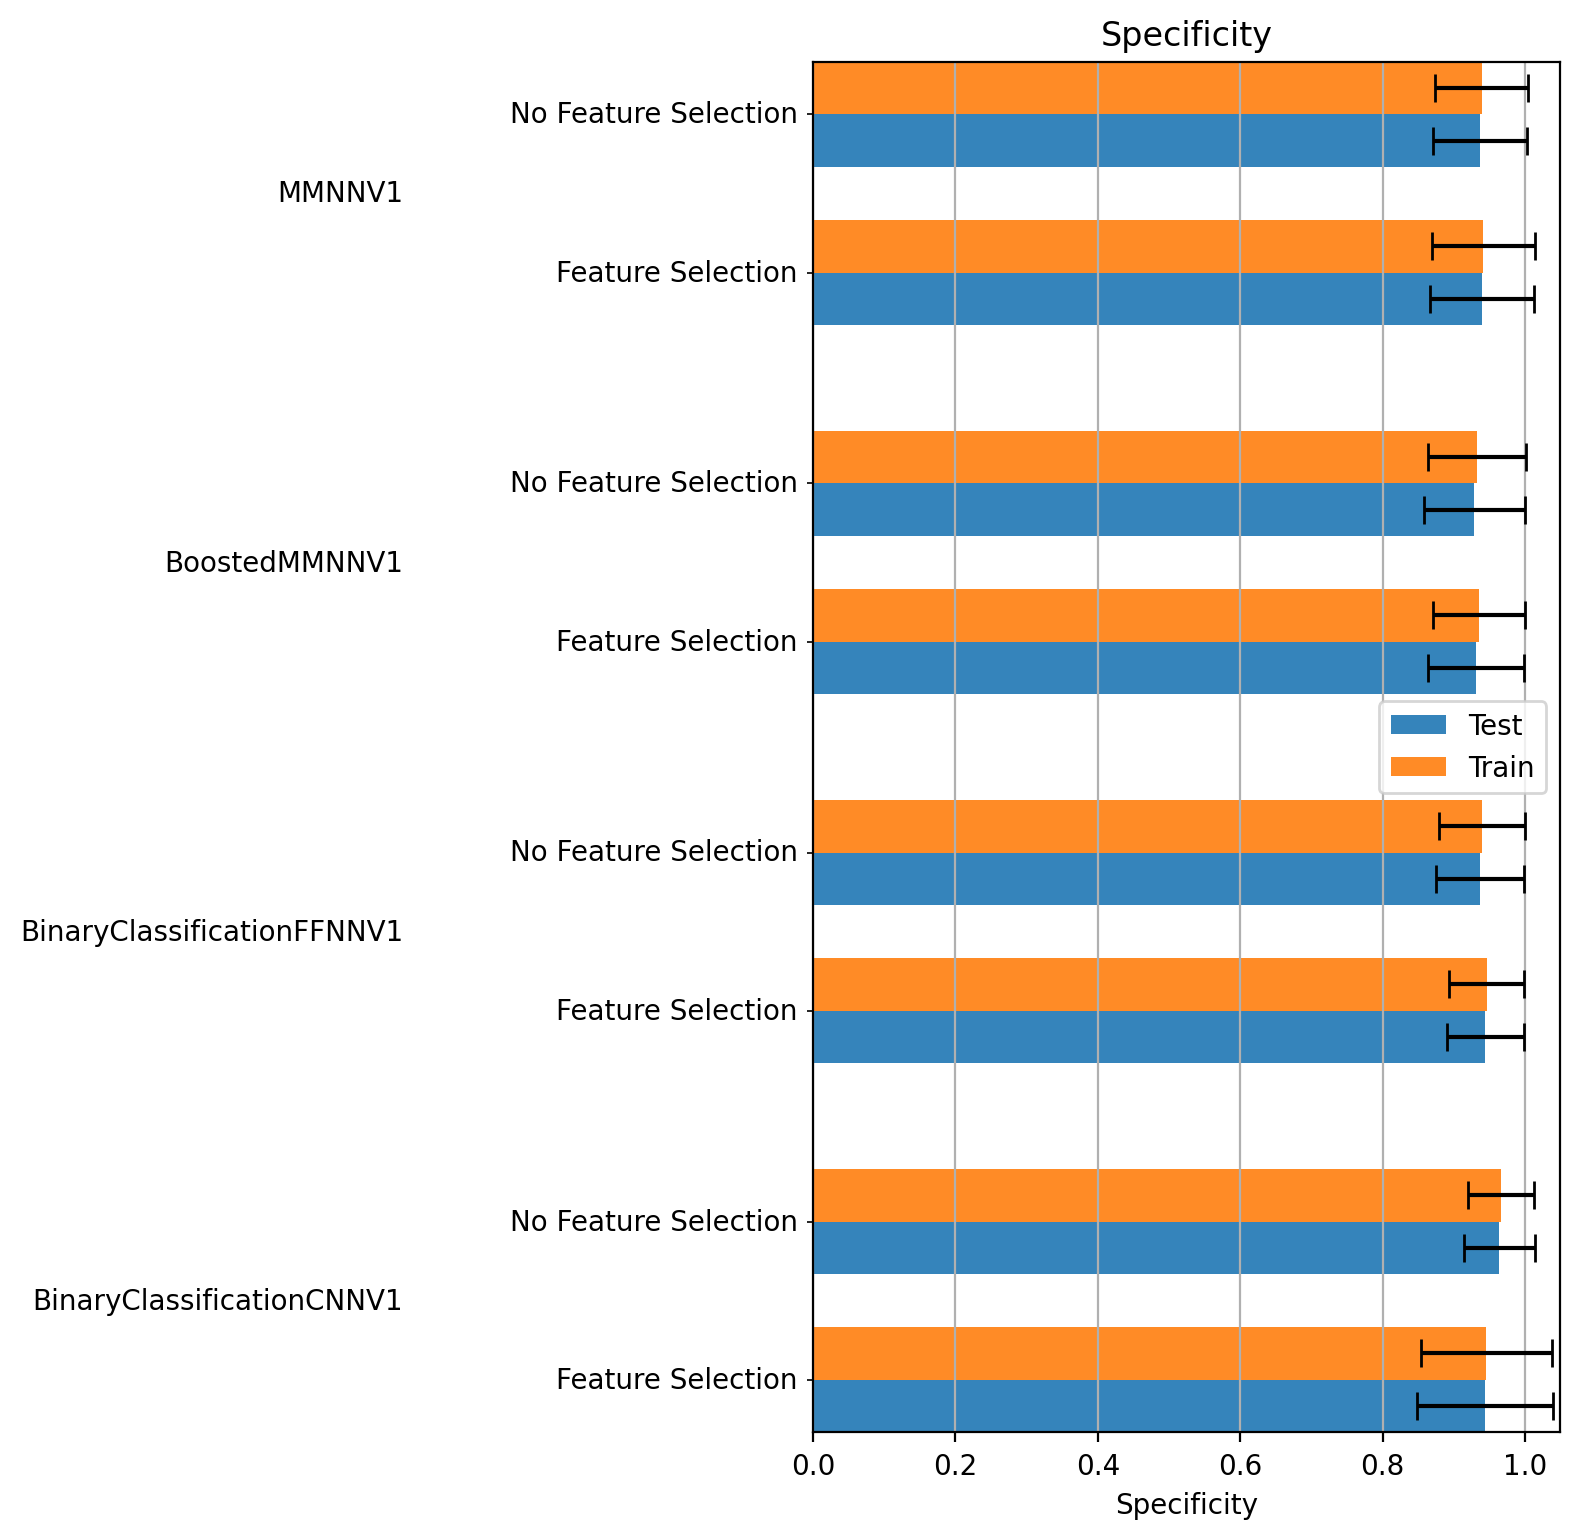

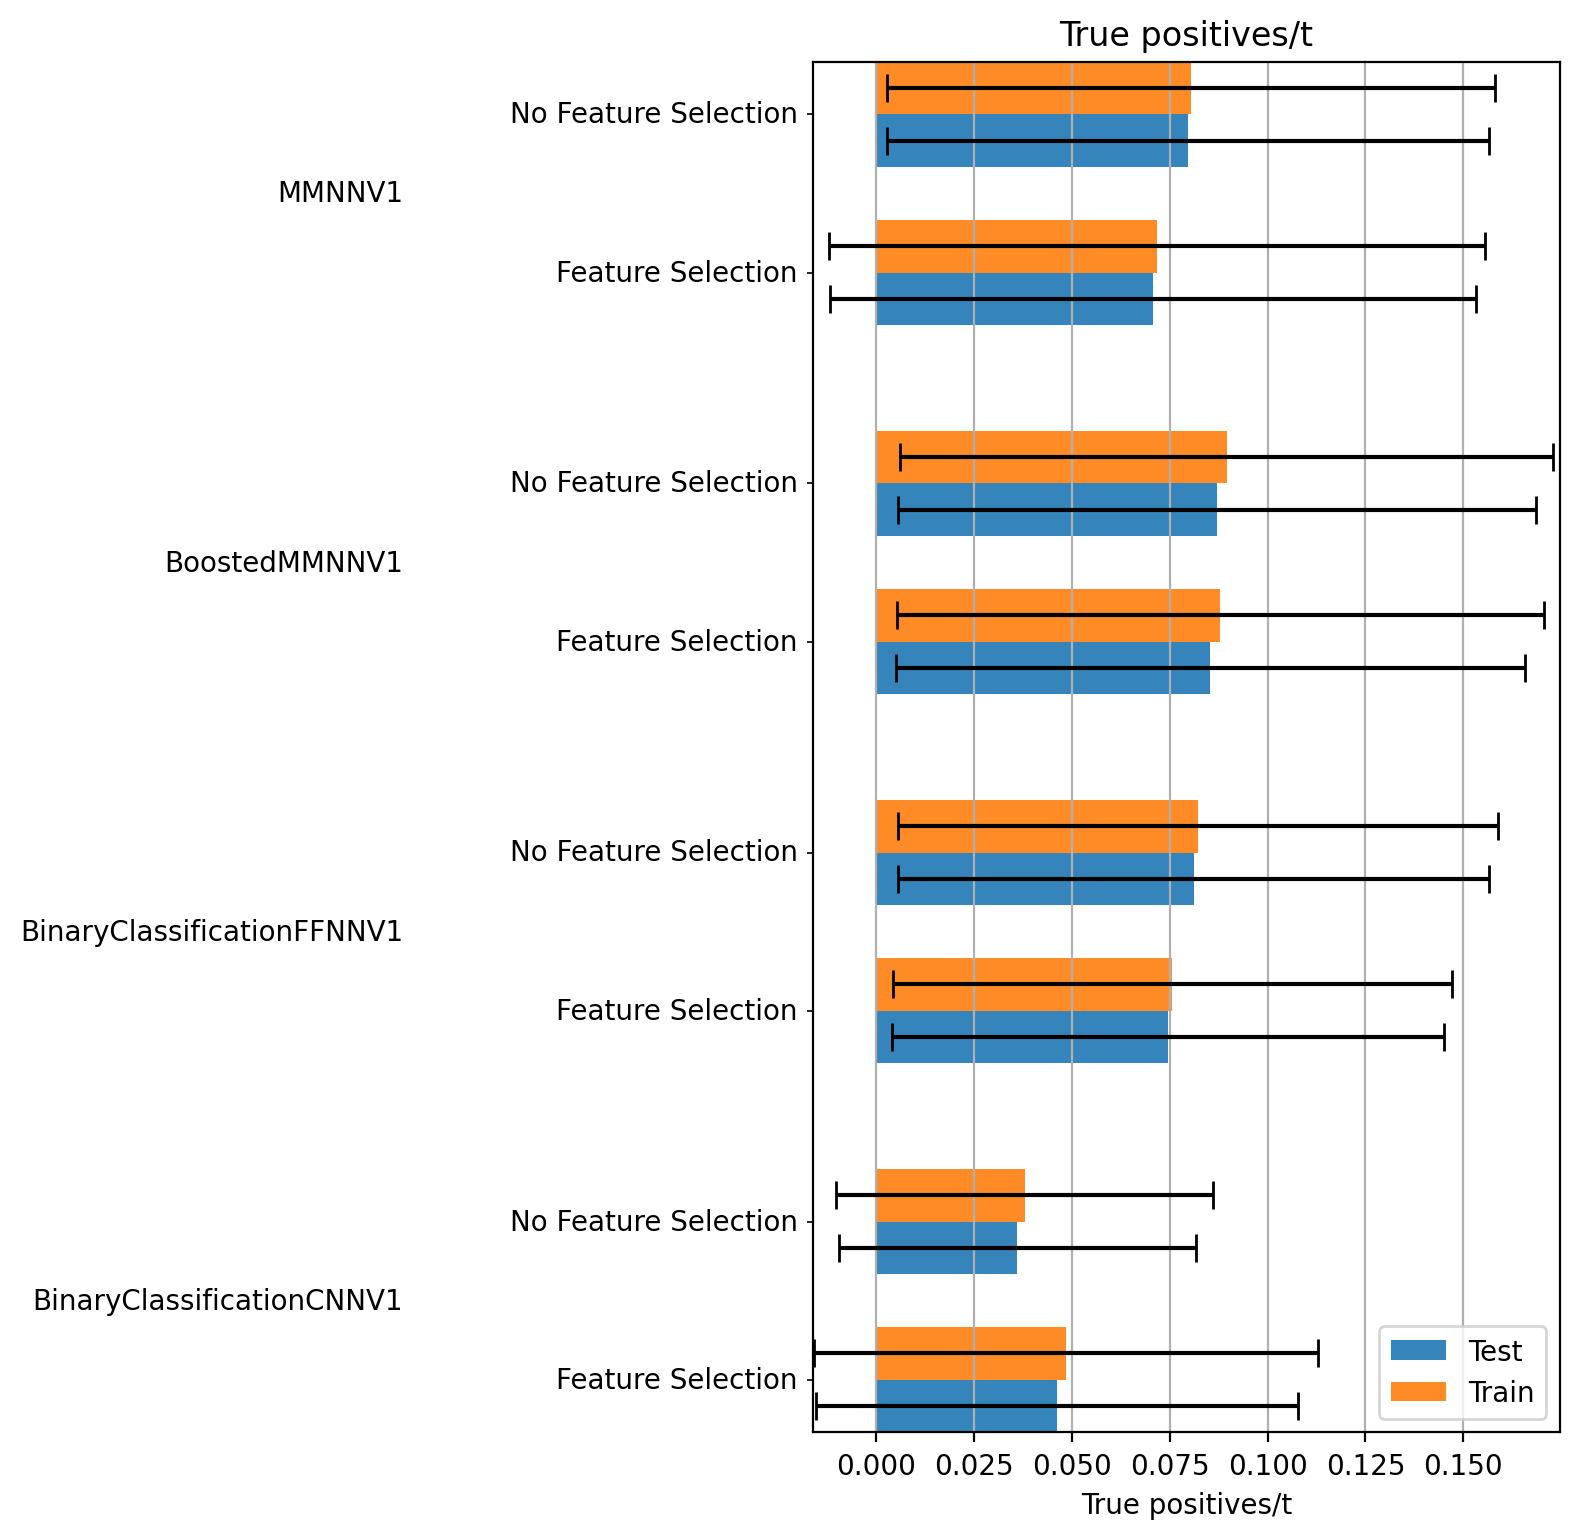

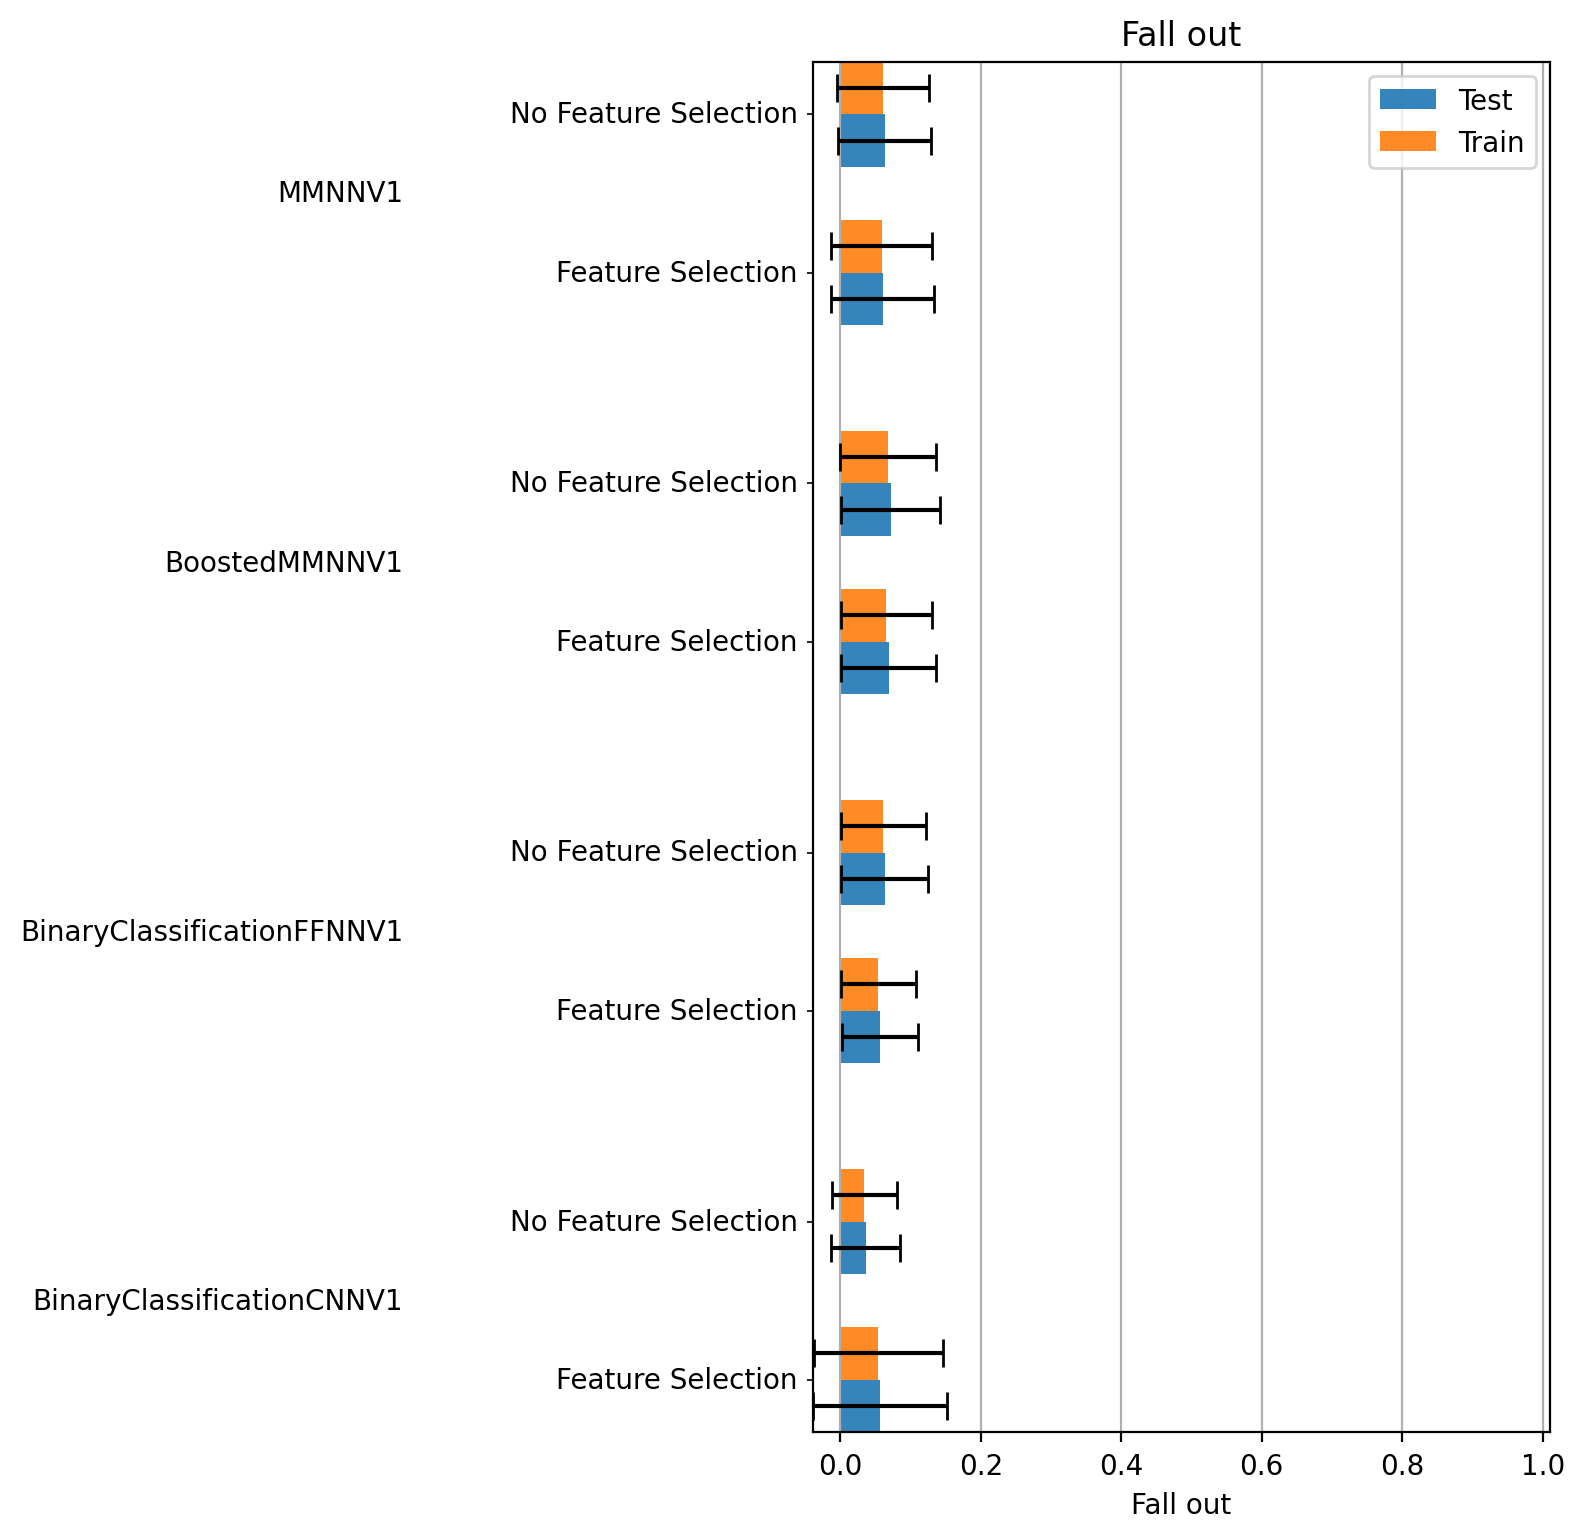

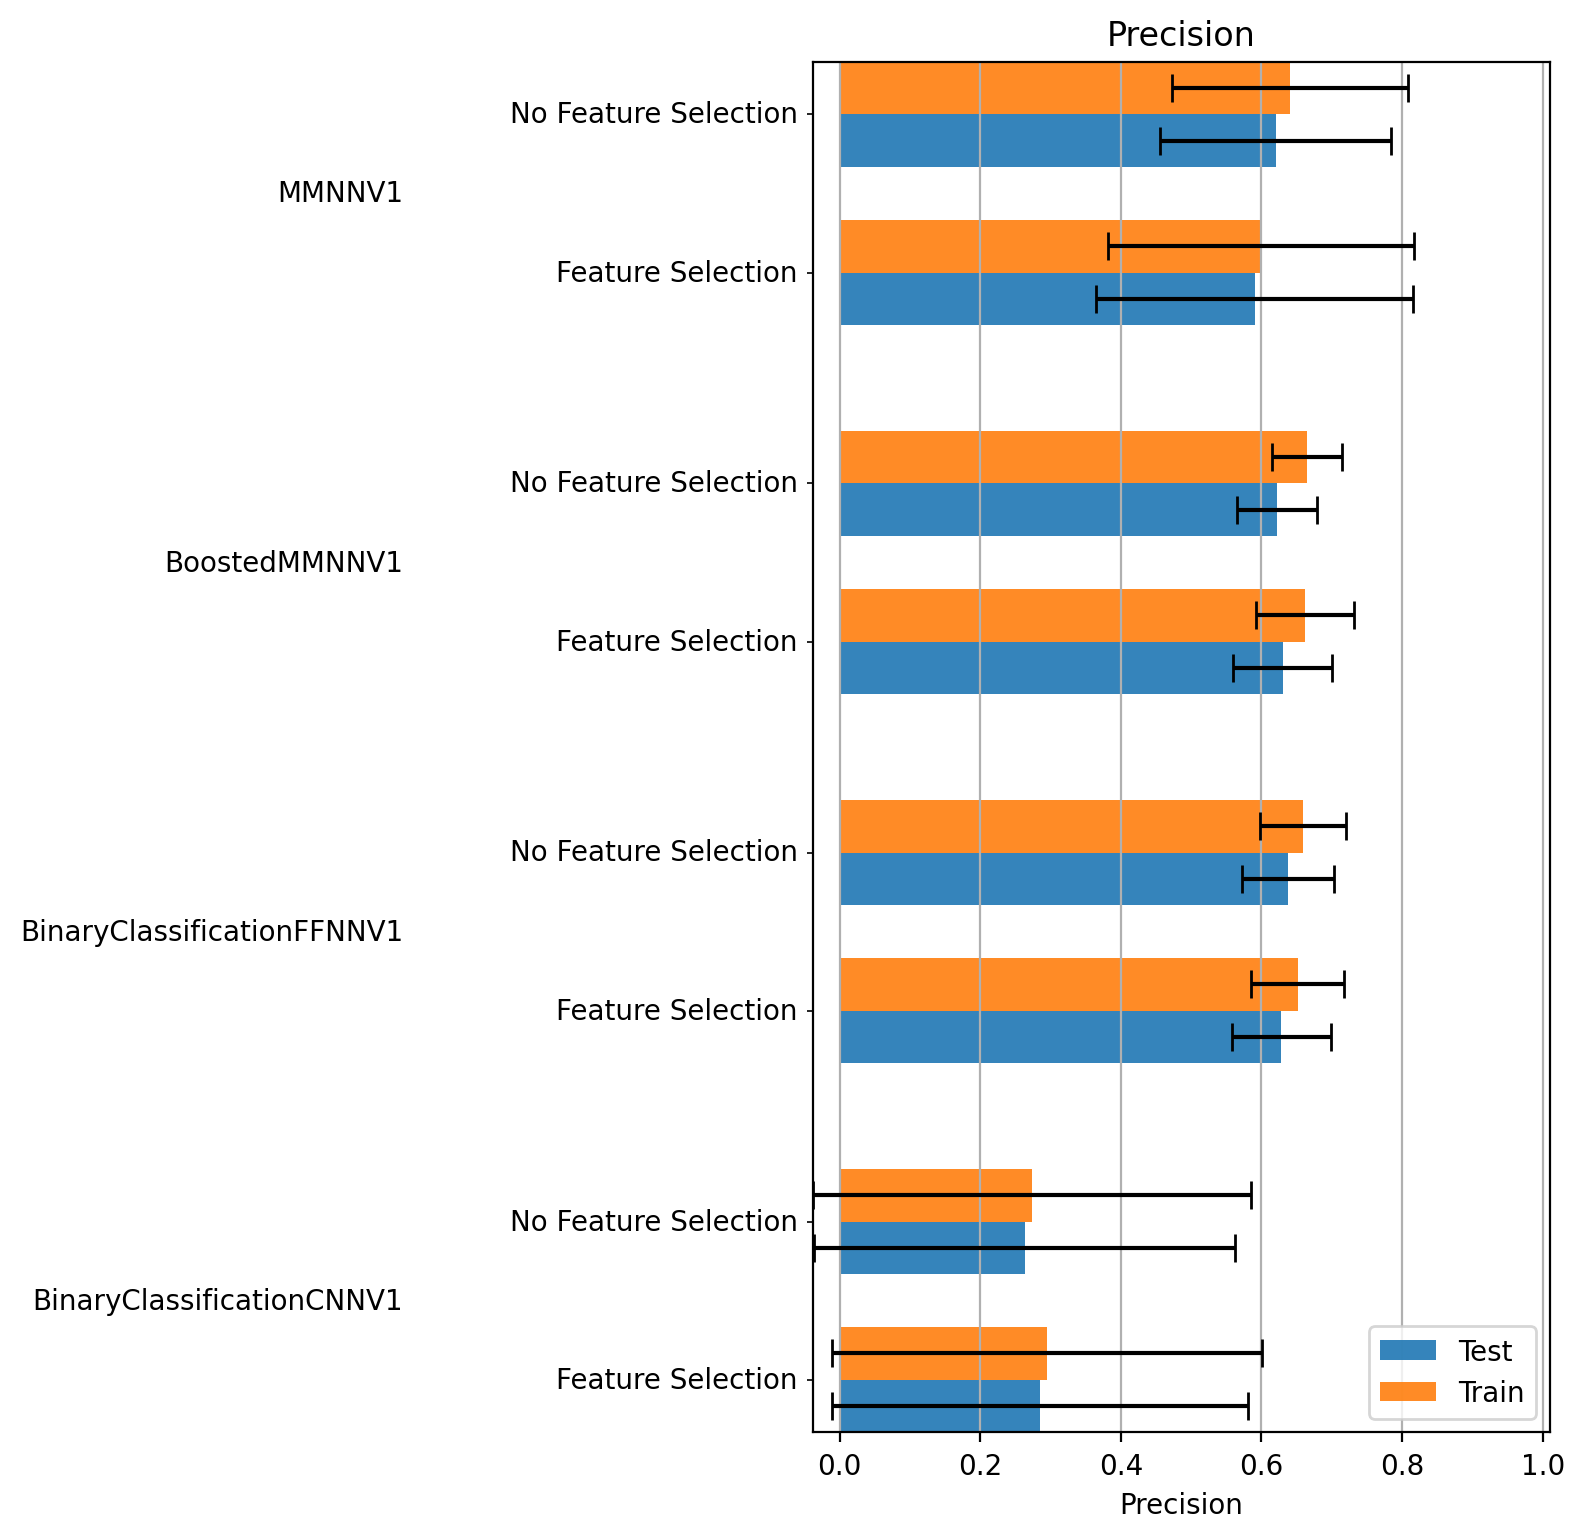

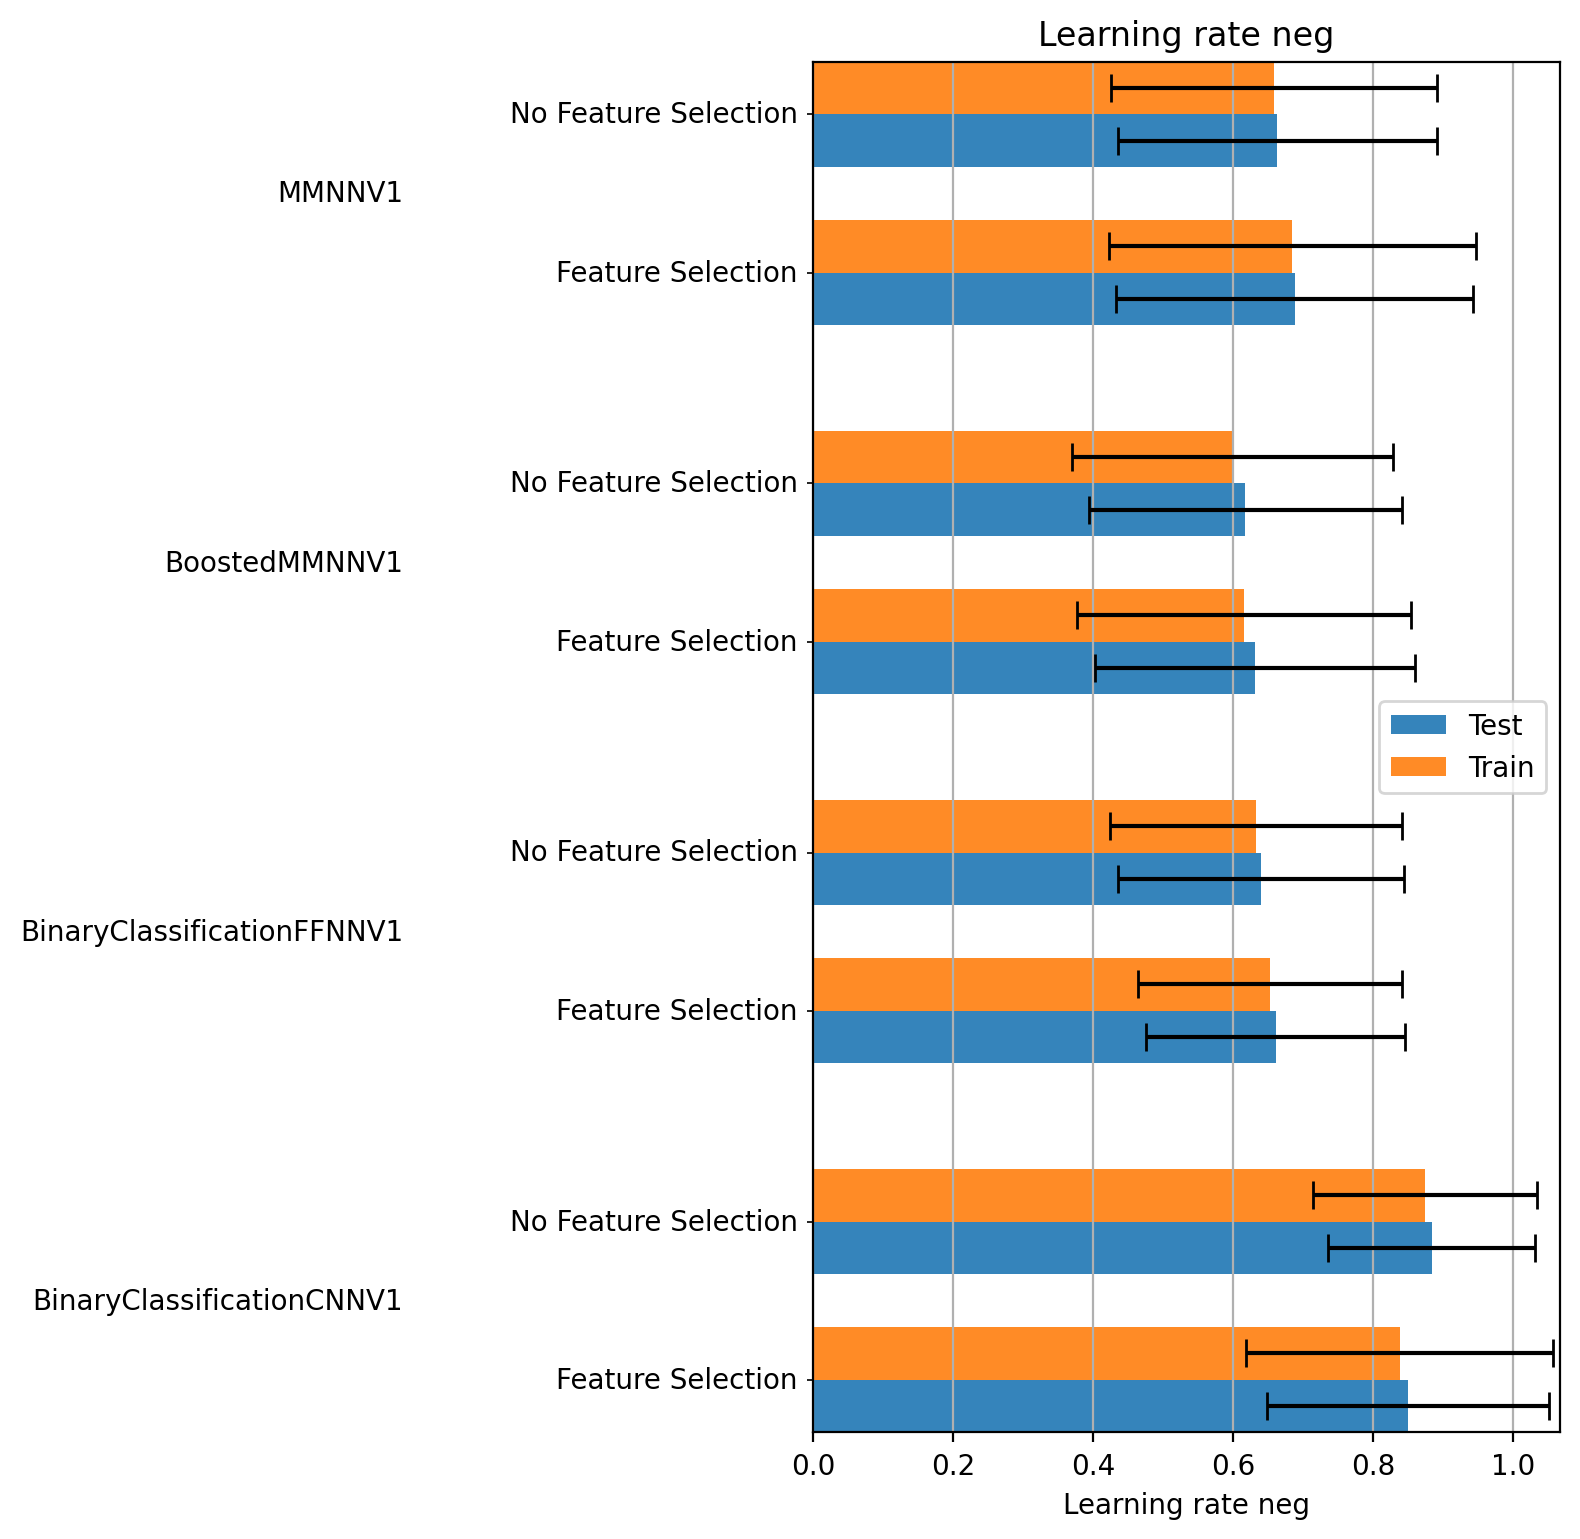

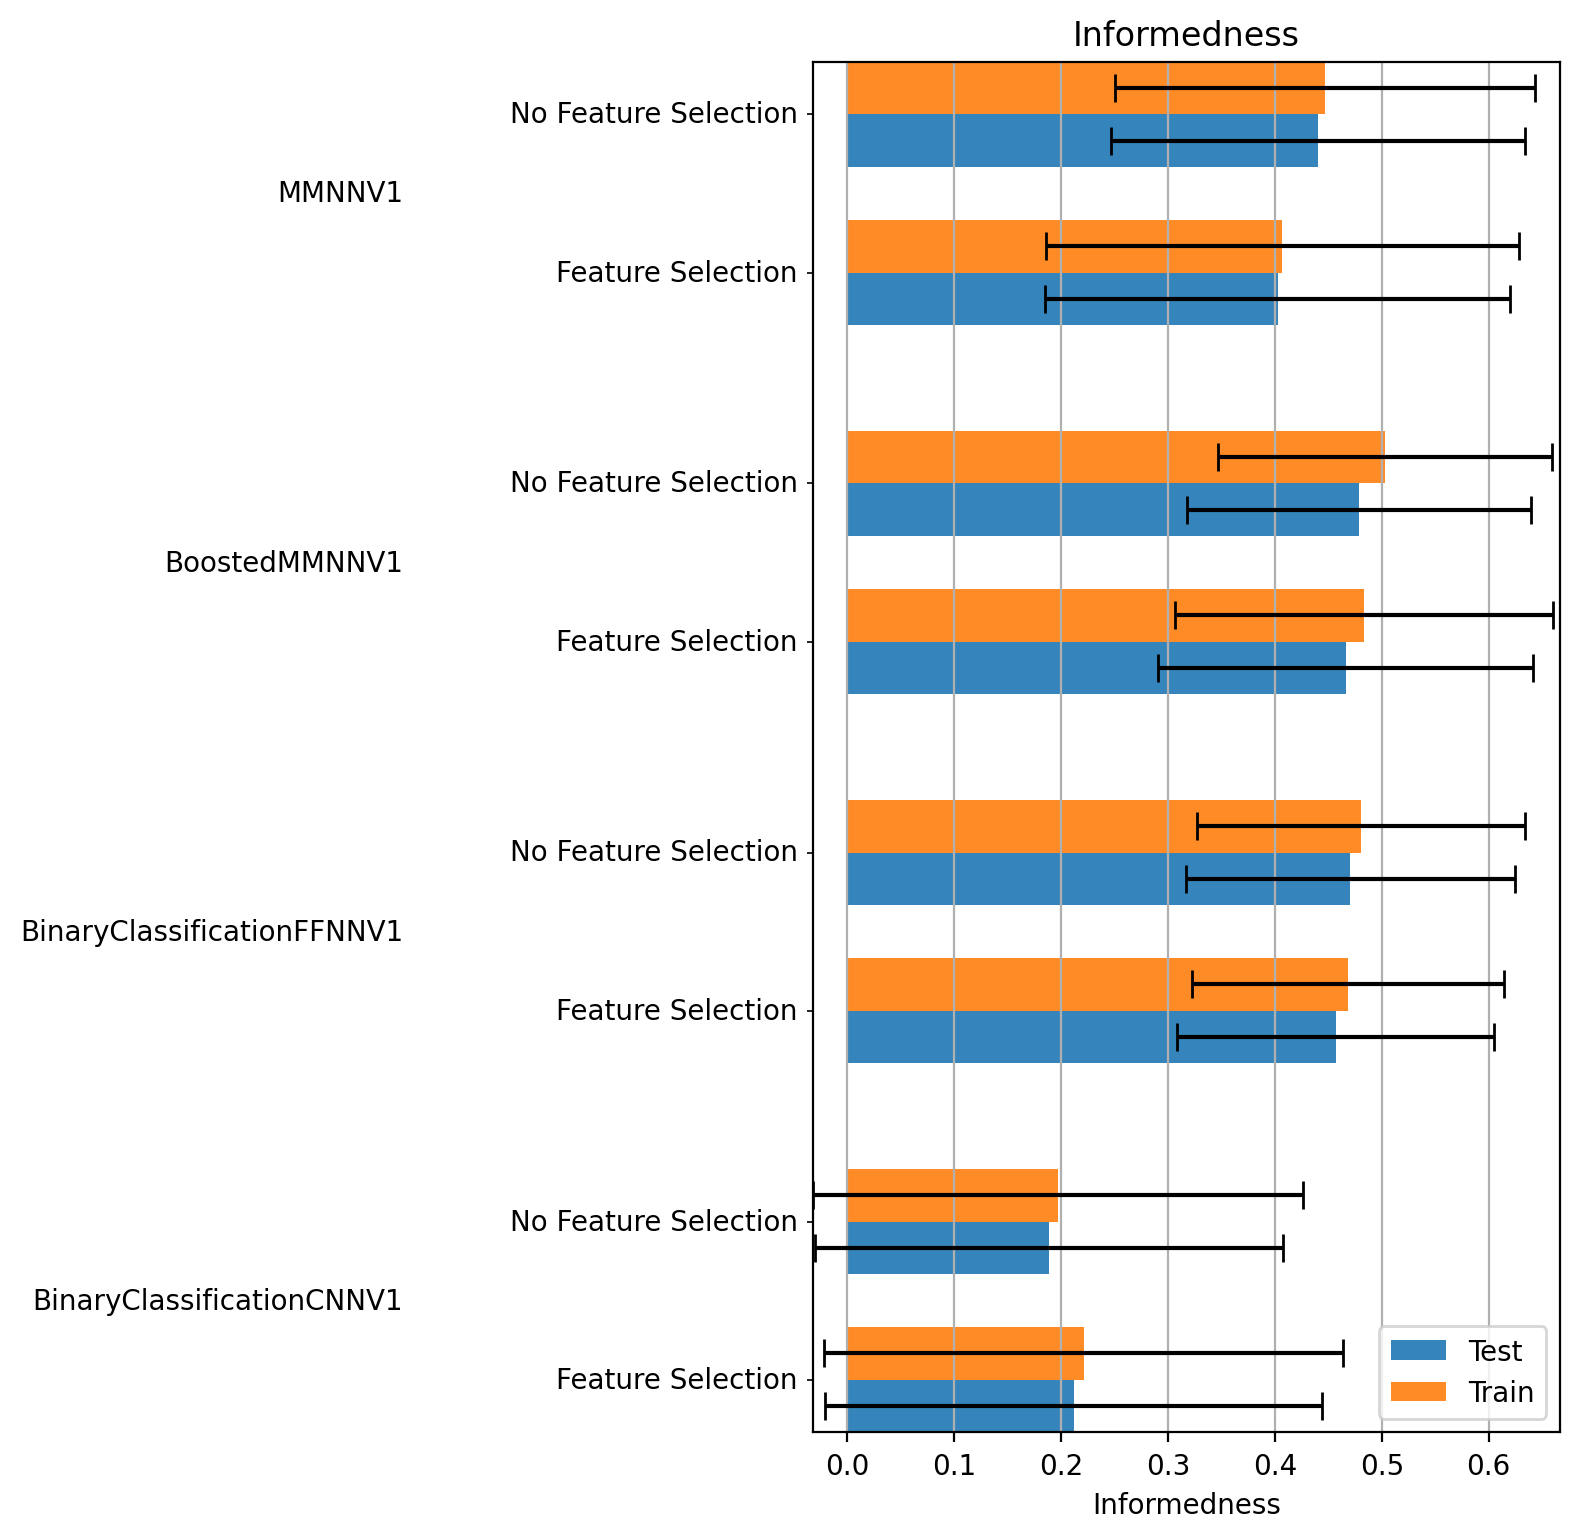

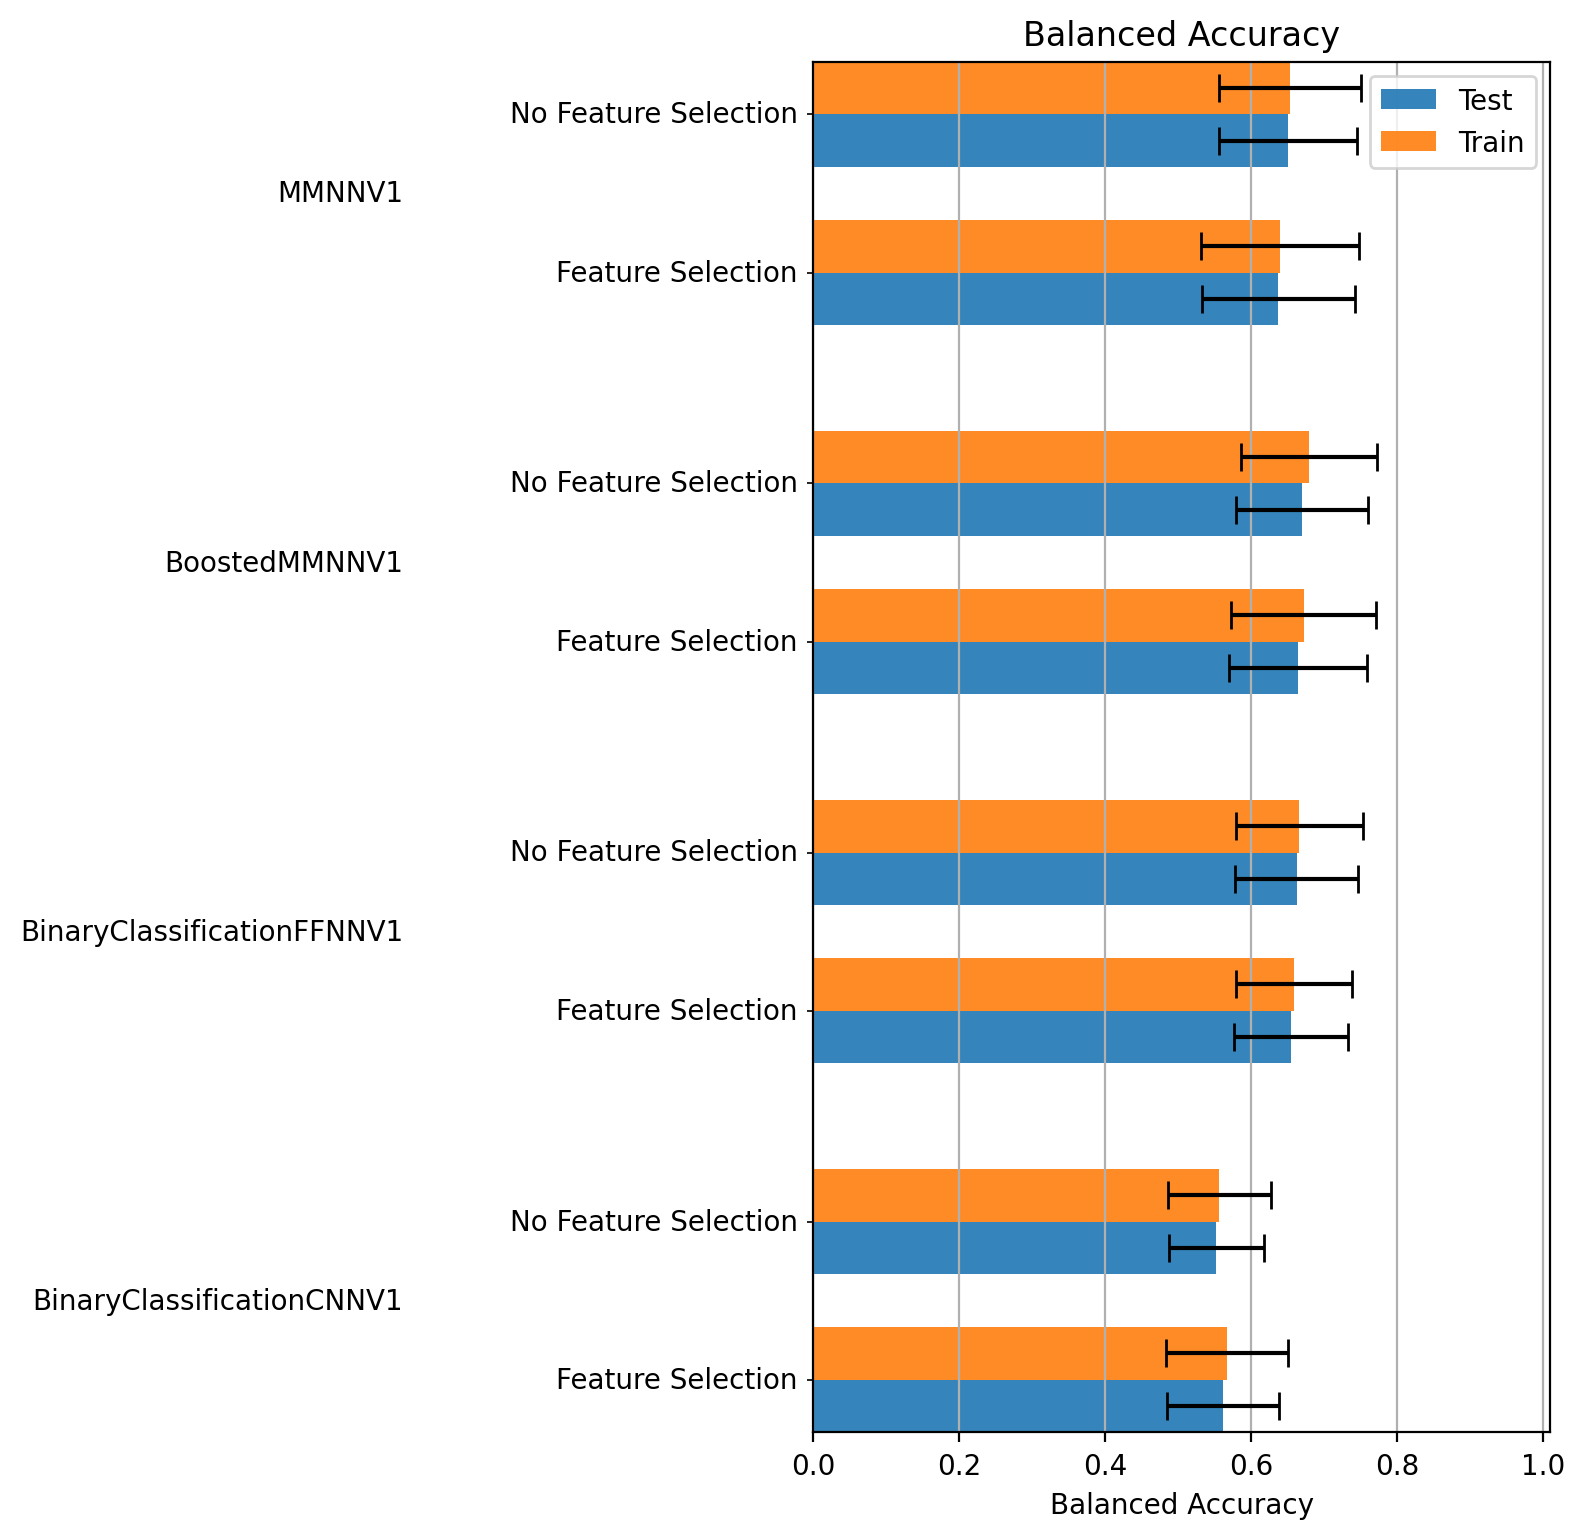

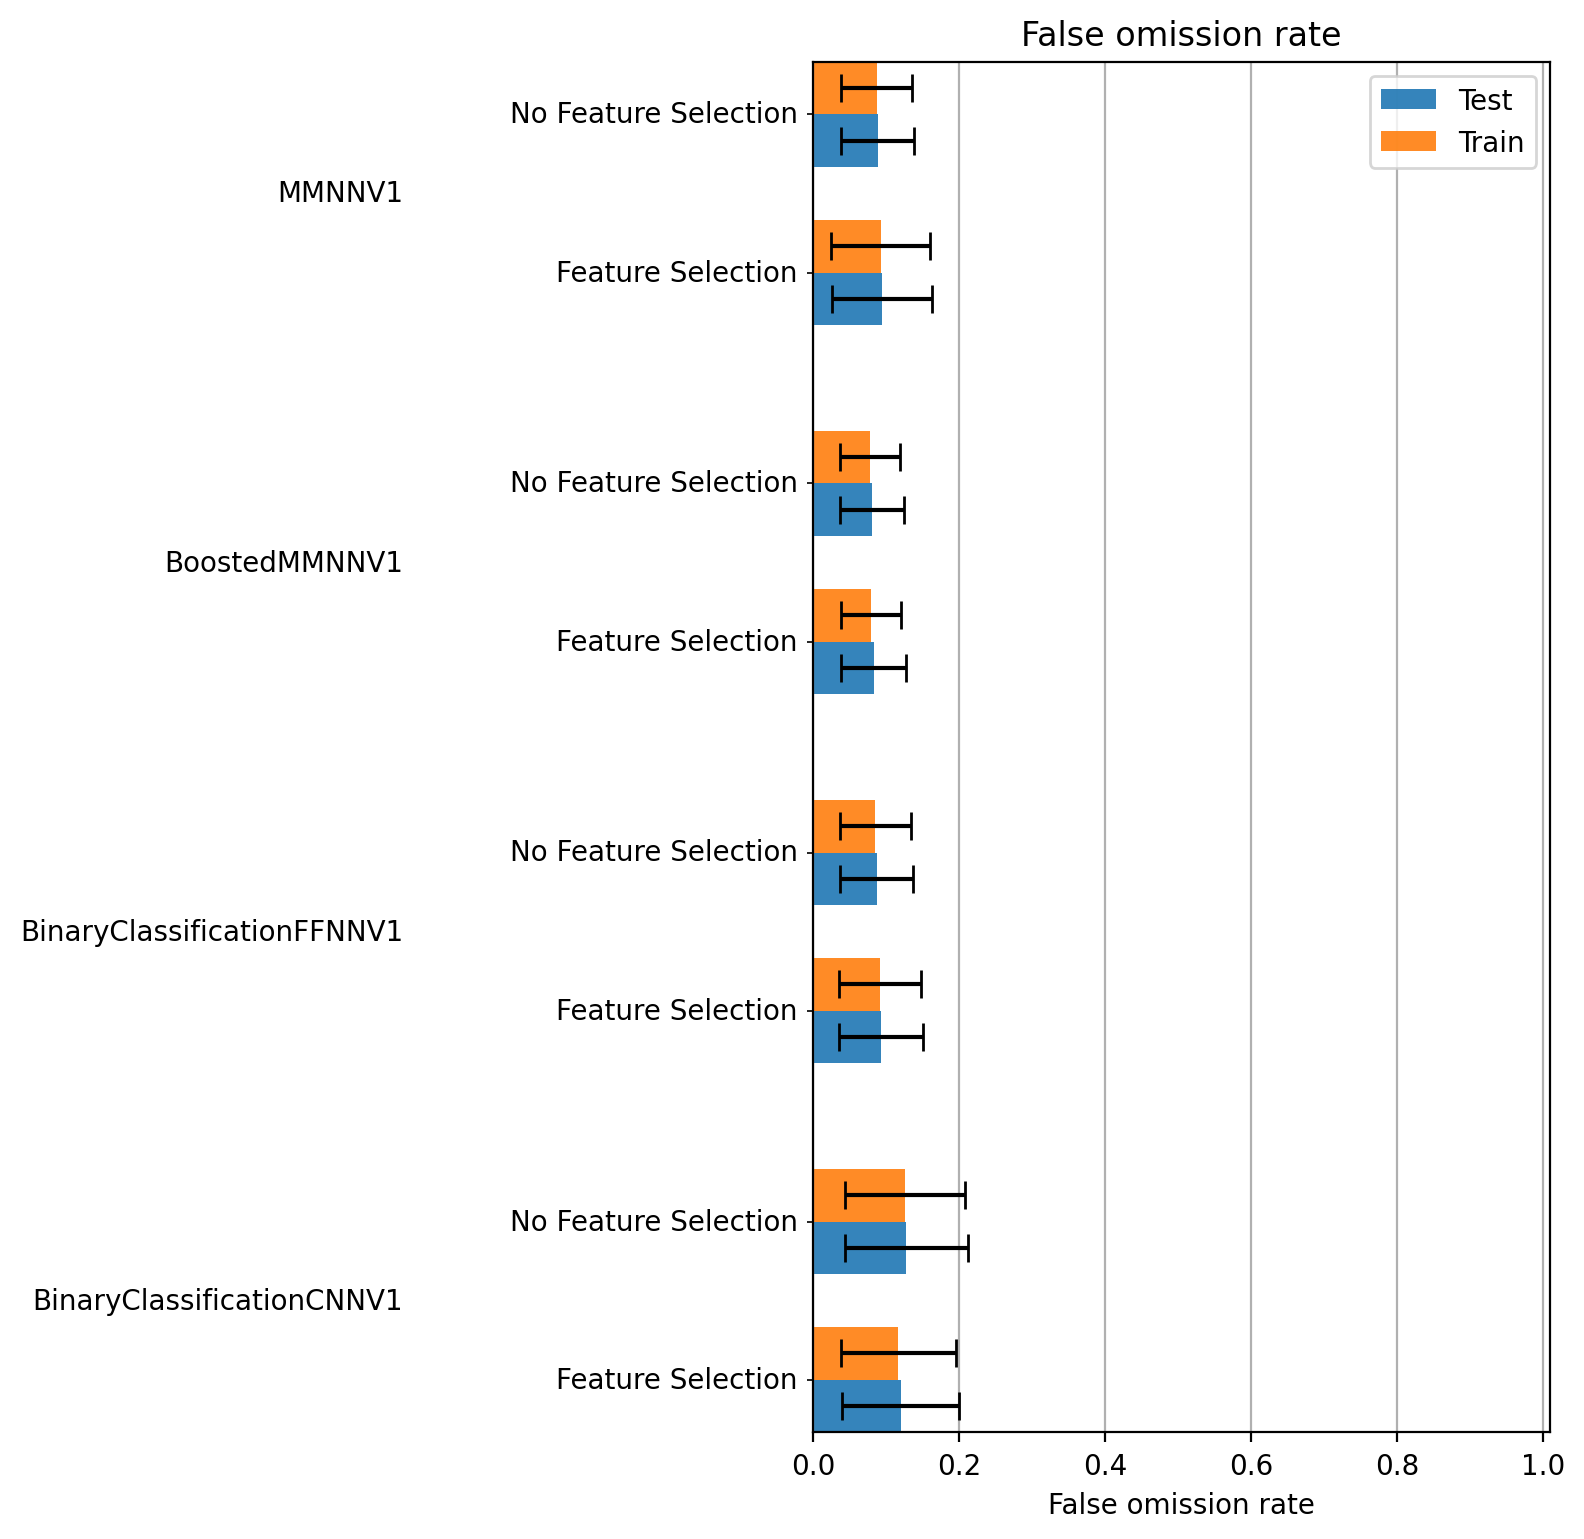

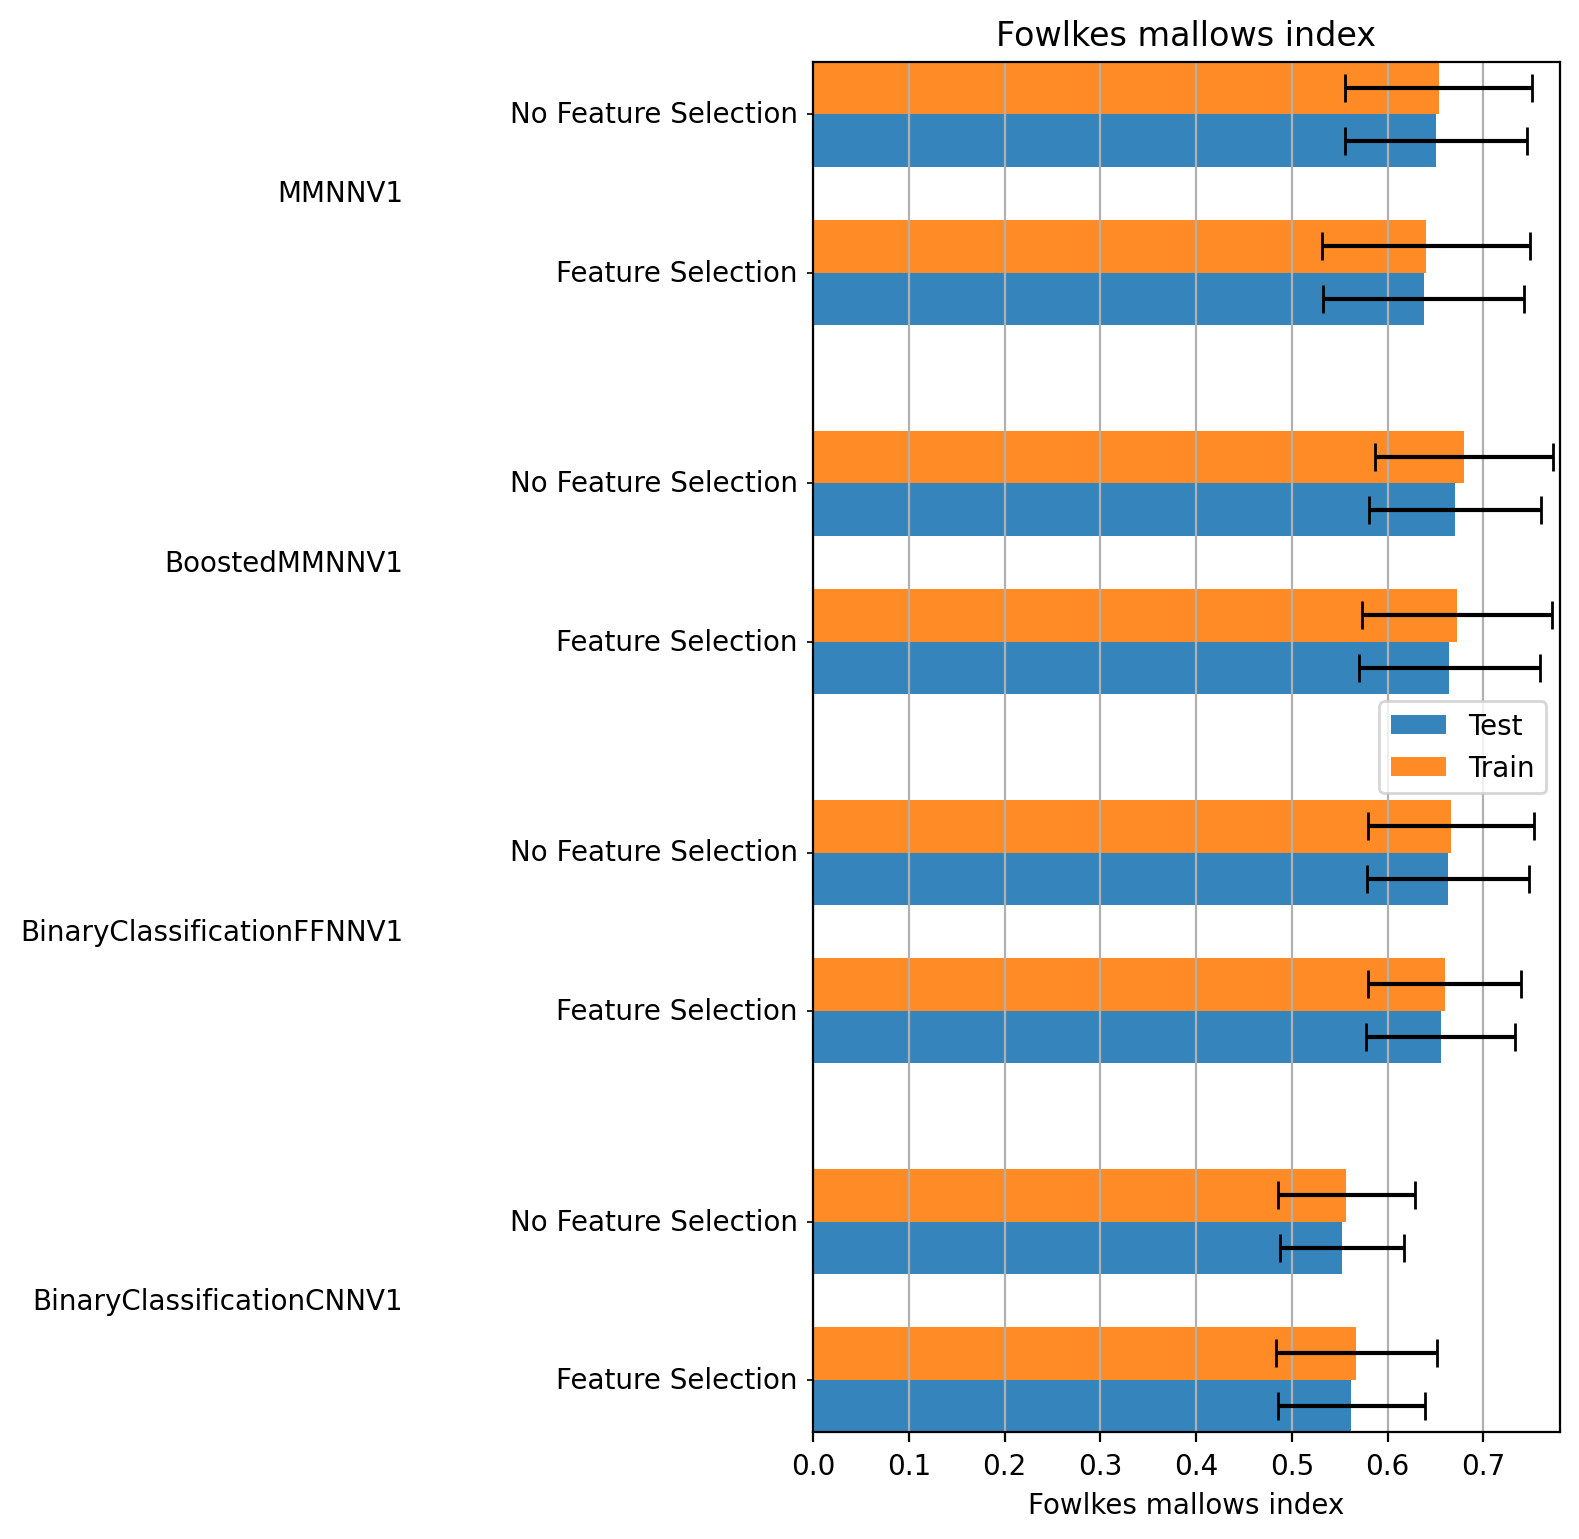

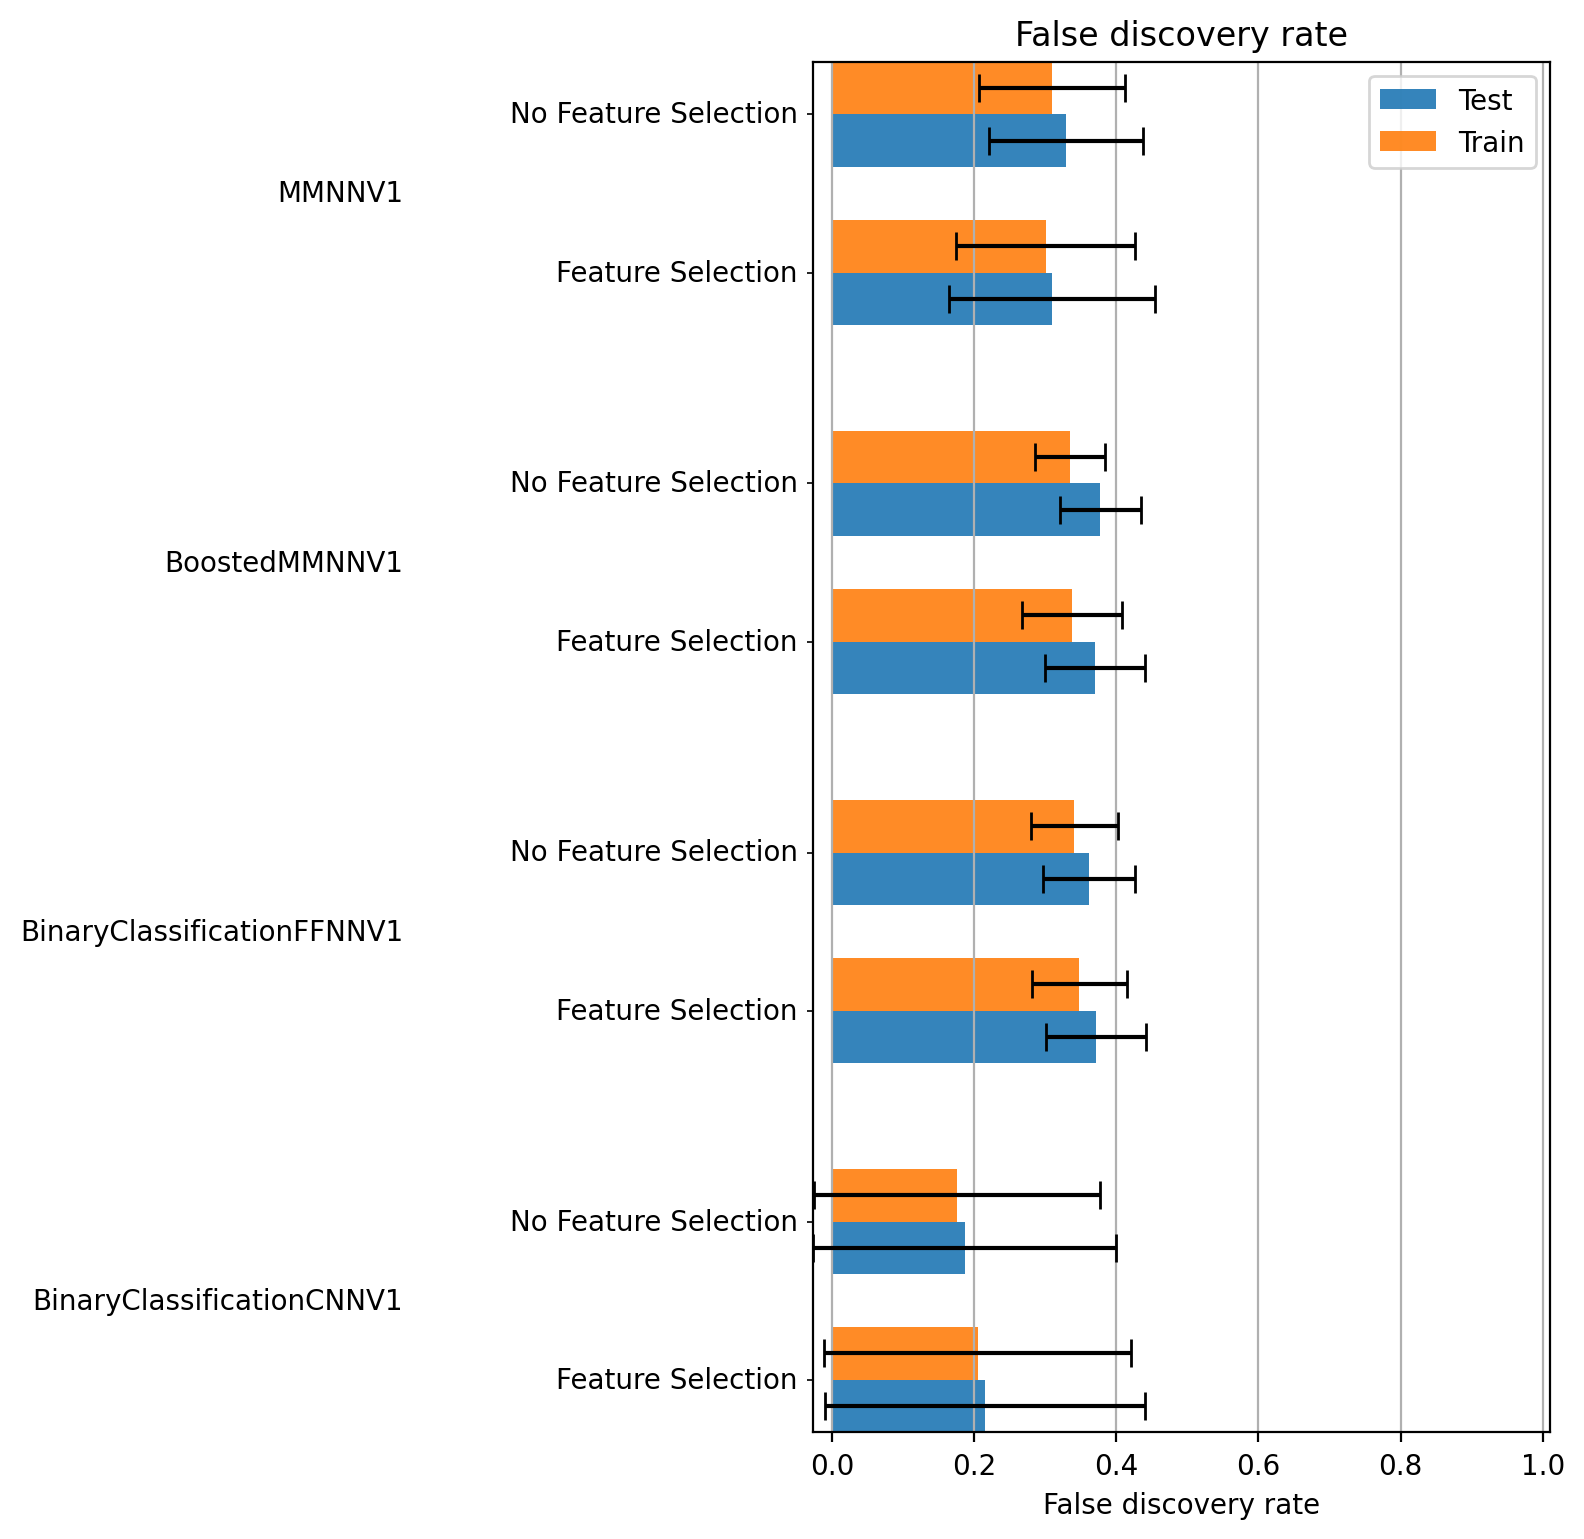

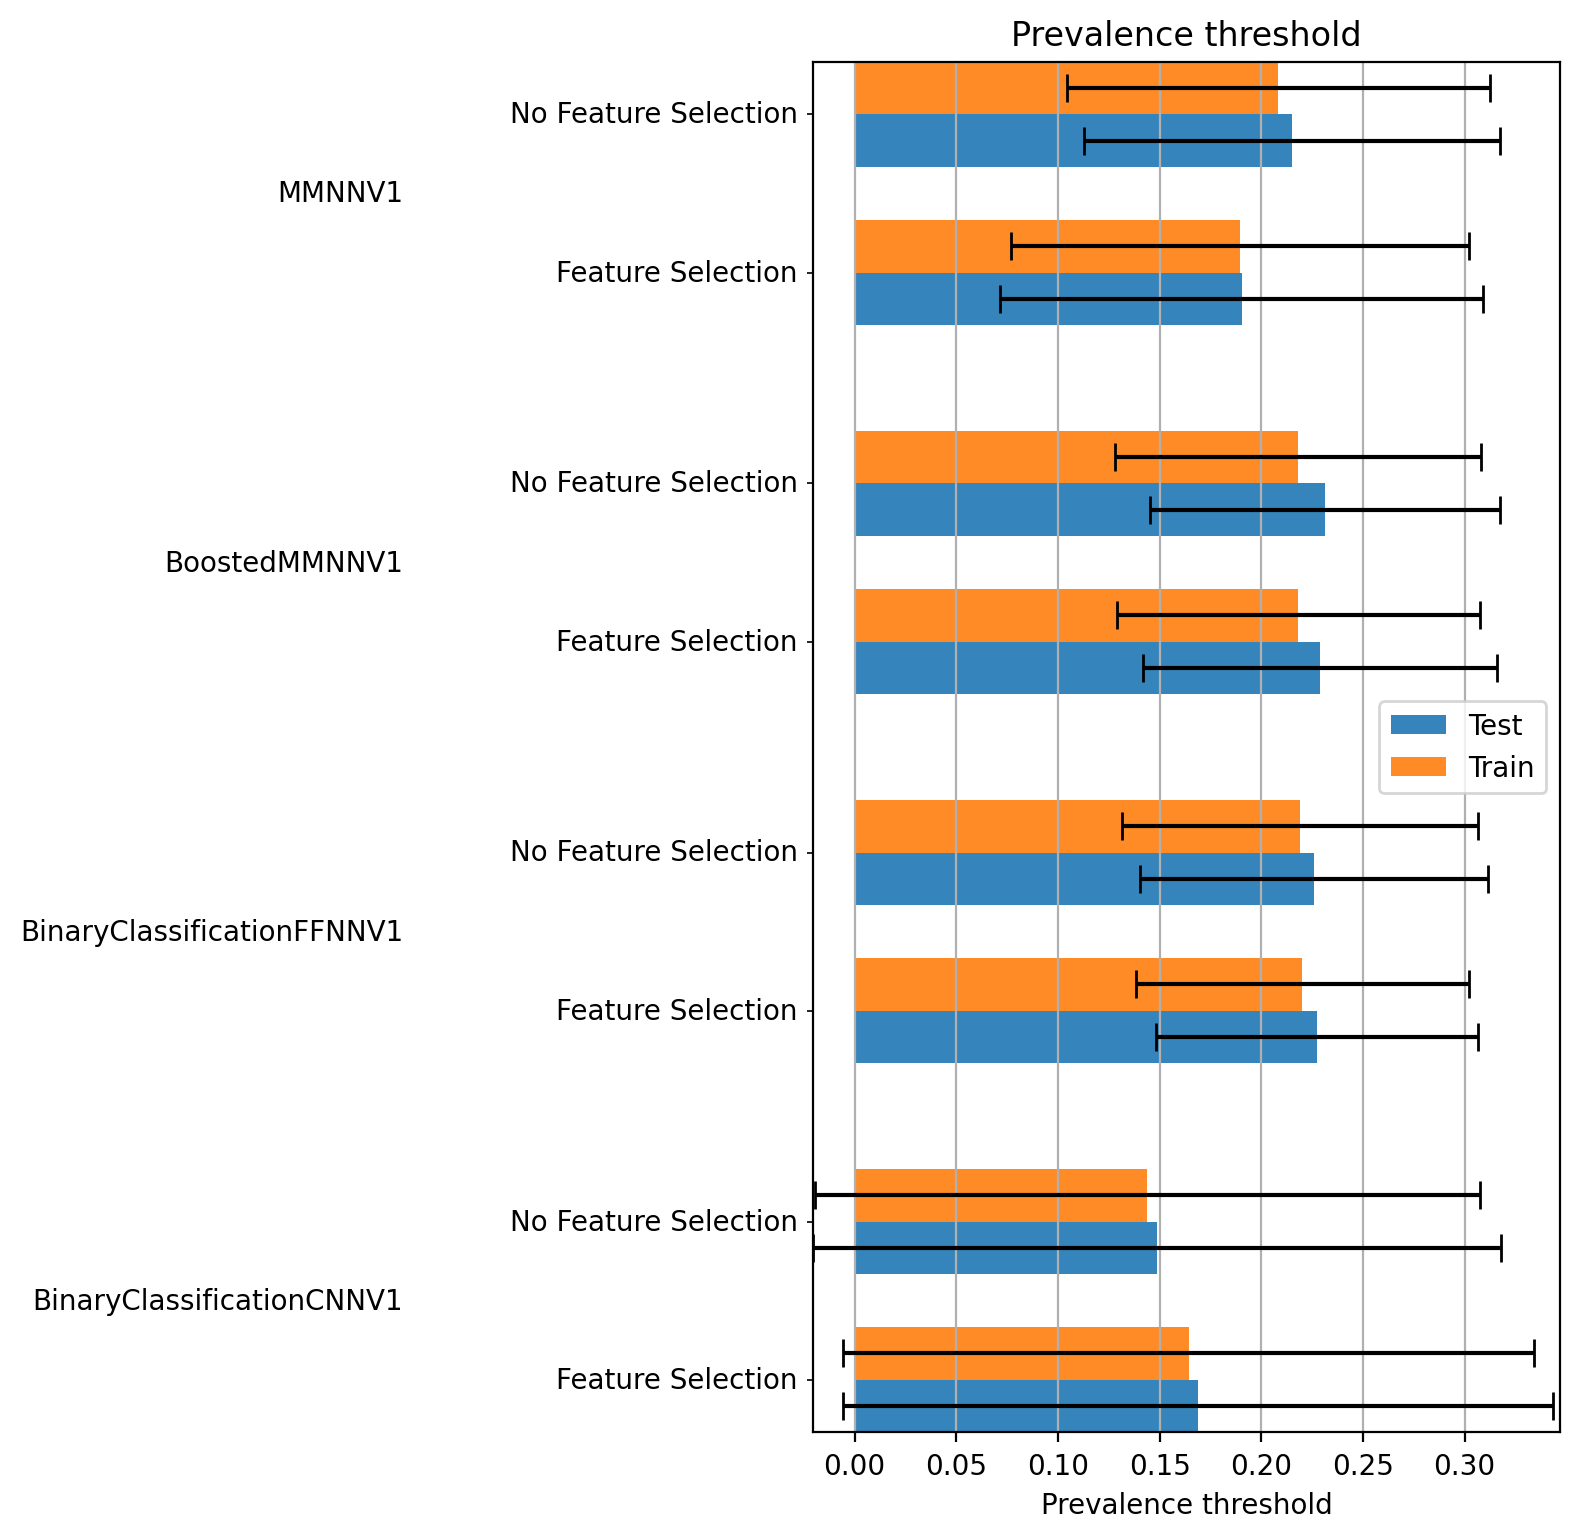

In [14]:
from barplots import barplots

barplots(
    all_performance,
    groupby=["model_name", "use_feature_selection", "run_type"],
    orientation="horizontal",
    height=8
)